<a href="https://colab.research.google.com/github/peeyushsinghal/da/blob/main/mitigating_bias_sa_da_v29.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mitigating bias in sentiment analysis using domain adaptation

In [ ]:
! pip install torchtext==0.10.0 --quiet # DOWNGRADE YOUR TORCHTEXT
! pip install ekphrasis --quiet # library to pre process twitter data
! pip install emoji --upgrade --quiet #library to deal with emoji data

In [ ]:
!pip install --pre pytorch-ignite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
## Import statements
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchtext.legacy.data import Dataset, Field, TabularDataset, BucketIterator
from torchtext.vocab import GloVe
import torchtext.vocab as vocab
import numpy as np
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
import emoji
from torchtext.legacy.vocab import Vectors
from tqdm import tqdm
import random
import torch.optim as optim
import scipy.stats as stats
from statistics import mean

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
en_stops = set(stopwords.words('english'))

import time

from copy import deepcopy

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


import matplotlib.pyplot as plt
# import EarlyStopping
# from pytorchtools import EarlyStopping

from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# checking device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:{}".format(DEVICE))

Running on:cuda


## Data loading

In [ ]:
#Mounting google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Data Configuration

In [ ]:

BASE_PATH = '/content/drive/MyDrive/semeval-2018'

DATA_DIR = os.path.join(BASE_PATH,'datasets')
TARGET_DIR = os.path.join(BASE_PATH,'targetdataset')

MODEL_DIR = os.path.join(BASE_PATH,'models')
REF_DIR = os.path.join(BASE_PATH,'reference')
EMBEDDINGS_DIR = os.path.join(BASE_PATH,'embeddings')

MAX_SIZE = 50
MAX_VOCAB_SIZE = 10000
BATCH_SIZE = 8

EMBEDDING_TO_BE_USED = 'glove' # {'glove', 'glove_gn'}
TARGET_BATCH_SIZE = 8

# NUM_EPOCHS = 100
# NUM_EPOCHS = 30
NUM_EPOCHS = 60
INITIAL_LR = 0.001
INITIAL_LR_EWC = INITIAL_LR / NUM_EPOCHS
LR_GAMMA = 0.9
LR = 2e-4

PATIENCE = 10
EWC_LAMBDA = 0.4

if not os.path.exists(MODEL_DIR):
  os.makedirs(MODEL_DIR)
  print("The new directory is created!")


BONFERRONI_CORRECTION = 5.0

In [ ]:
# data configuration

class TASK1(object):
  
    EI_reg = {
        'anger': {
            'train': os.path.join(
                DATA_DIR, 'task1/EI-reg/training/EI-reg-En-anger-train.txt'),
            'dev': os.path.join(
                DATA_DIR, 'task1/EI-reg/development/2018-EI-reg-En-anger-dev.txt'),
            'gold': os.path.join(
                DATA_DIR, 'task1/EI-reg/test-gold/2018-EI-reg-En-anger-test-gold.txt')
                },
        'joy': {
                'train': os.path.join(
                    DATA_DIR, 'task1/EI-reg/training/EI-reg-En-joy-train.txt'),
                'dev': os.path.join(
                    DATA_DIR, 'task1/EI-reg/development/2018-EI-reg-En-joy-dev.txt'),
                'gold': os.path.join(
                    DATA_DIR, 'task1/EI-reg/test-gold/2018-EI-reg-En-joy-test-gold.txt')
                },
        'fear': {
            'train': os.path.join(
                DATA_DIR, 'task1/EI-reg/training/EI-reg-En-fear-train.txt'),
            'dev': os.path.join(
                DATA_DIR, 'task1/EI-reg/development/2018-EI-reg-En-fear-dev.txt'),
            'gold': os.path.join(
                DATA_DIR, 'task1/EI-reg/test-gold/2018-EI-reg-En-fear-test-gold.txt')
                },
        'sadness': {
            'train': os.path.join(
                DATA_DIR, 'task1/EI-reg/training/EI-reg-En-sadness-train.txt'),
            'dev': os.path.join(
                DATA_DIR, 'task1/EI-reg/development/2018-EI-reg-En-sadness-dev.txt'),
            'gold': os.path.join(
                DATA_DIR, 'task1/EI-reg/test-gold/2018-EI-reg-En-sadness-test-gold.txt')
                }                     
        }

    V_reg = {
        'train': os.path.join(
            DATA_DIR, 'task1/V-reg/2018-Valence-reg-En-train.txt'),
        'dev': os.path.join(
            DATA_DIR, 'task1/V-reg/2018-Valence-reg-En-dev.txt'),
        'gold': os.path.join(
            DATA_DIR, 'task1/V-reg/2018-Valence-reg-En-test-gold.txt')
             }

    EEC = {
        'eec': os.path.join(
            DATA_DIR, 'task1/Equity-Evaluation-Corpus/Equity-Evaluation-Corpus.csv')
             }

## Source Data
Parsing Emotion and Valence regression data : `format [ID	Tweet	Affect Dimension	Intensity Score]`

In [ ]:
def parse_reg(data_file, label_format='tuple'):
    """
    This is for datasets for the EI-reg and V-reg English tasks 
    Returns:
        df: dataframe with columns in the first row of file [ID-Tweet-Affect Dimension-Intensity Score]
    """
    with open(data_file, 'r') as fd:
      data = [l.strip().split('\t') for l in fd.readlines()]
    # print(data)
    df = pd.DataFrame (data[1:],columns=data[0])
    csv_file_name = (data_file.split("/")[-1]).split('.')[0]+".csv"
    csv_file = df.to_csv(str(csv_file_name))
    return csv_file_name


Generic Source Data Parser

In [ ]:
def parse_csv(task, dataset, emotion='anger'):
    if task == 'EI-reg':
        data_train = TASK1.EI_reg[emotion][dataset]
        csv_file_name = parse_reg(data_train)
        return csv_file_name

    elif task == 'V-reg':
        data_train = TASK1.V_reg[dataset]

        csv_file_name = parse_reg(data_train)
        return csv_file_name

    else:
        return None

In [ ]:
emotions = ['anger','joy','fear','sadness']
dict_data ={'train':'train','dev':'val','gold':'test'}
dict_file_name ={}
for emotion in emotions:
  for data_info, data_usage in dict_data.items():
    file_name = str('file_EI_'+ emotion + "_" + data_usage)
    dict_file_name[file_name] = parse_csv('EI-reg', data_info, emotion)

    file_name2 = str('file_V_'+ data_usage)
    dict_file_name[file_name2] = parse_csv('V-reg', data_info)

(dict_file_name)

{'file_EI_anger_train': 'EI-reg-En-anger-train.csv',
 'file_V_train': '2018-Valence-reg-En-train.csv',
 'file_EI_anger_val': '2018-EI-reg-En-anger-dev.csv',
 'file_V_val': '2018-Valence-reg-En-dev.csv',
 'file_EI_anger_test': '2018-EI-reg-En-anger-test-gold.csv',
 'file_V_test': '2018-Valence-reg-En-test-gold.csv',
 'file_EI_joy_train': 'EI-reg-En-joy-train.csv',
 'file_EI_joy_val': '2018-EI-reg-En-joy-dev.csv',
 'file_EI_joy_test': '2018-EI-reg-En-joy-test-gold.csv',
 'file_EI_fear_train': 'EI-reg-En-fear-train.csv',
 'file_EI_fear_val': '2018-EI-reg-En-fear-dev.csv',
 'file_EI_fear_test': '2018-EI-reg-En-fear-test-gold.csv',
 'file_EI_sadness_train': 'EI-reg-En-sadness-train.csv',
 'file_EI_sadness_val': '2018-EI-reg-En-sadness-dev.csv',
 'file_EI_sadness_test': '2018-EI-reg-En-sadness-test-gold.csv'}

## Preprocess tweets

In [ ]:
# reference : https://github.com/cbaziotis/ekphrasis


text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'url', 'date', 'number'],
    # terms that will be annotated
    annotate={"hashtag", "allcaps", "elongated", "repeated",
        'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens
    
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter", 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter", 
    
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words
    
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)

Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


In [ ]:
def preprocess_tweet(tweet): 
  tweet_processed = text_processor.pre_process_doc(tweet)
  # print (tweet_processed)
  demojized_list =[]
  final_list =[]
  for index, tweet in enumerate(tweet_processed):
      demojized_list.append(emoji.demojize(tweet, language = 'en'))
  final_list = [w for w in demojized_list if w not in en_stops] 
  
  # print(df)
  return final_list

## TorchText Treatment

In [ ]:
dict_file_name.keys()

dict_keys(['file_EI_anger_train', 'file_V_train', 'file_EI_anger_val', 'file_V_val', 'file_EI_anger_test', 'file_V_test', 'file_EI_joy_train', 'file_EI_joy_val', 'file_EI_joy_test', 'file_EI_fear_train', 'file_EI_fear_val', 'file_EI_fear_test', 'file_EI_sadness_train', 'file_EI_sadness_val', 'file_EI_sadness_test'])

In [ ]:
dict_fields ={}
list_name = list(set(["_".join(key.split("_")[1:-1]) for key in list(dict_file_name.keys())]))


for name in list_name:
  field_tweet = Field(sequential=True, 
                      use_vocab = True, 
                      tokenize = preprocess_tweet, 
                      fix_length = MAX_SIZE, 
                      batch_first = True)
  field_intensity = Field(sequential= False, 
                        dtype = torch.float,
                        use_vocab = False)
  fields = {
    'Tweet':('tweet', field_tweet ), #
    'Intensity Score': ('intensity',field_intensity) # Intensity Score is name of the dataset column, field_intensity is how we have defined the field, intensity is the name of the variable going fwd
    }
  
  dict_fields[name] = fields

dict_fields

{'EI_joy': {'Tweet': ('tweet',
   <torchtext.legacy.data.field.Field at 0x7fbd5bb669a0>),
  'Intensity Score': ('intensity',
   <torchtext.legacy.data.field.Field at 0x7fbd5bb66b80>)},
 'EI_anger': {'Tweet': ('tweet',
   <torchtext.legacy.data.field.Field at 0x7fbd5bb66d00>),
  'Intensity Score': ('intensity',
   <torchtext.legacy.data.field.Field at 0x7fbce06202b0>)},
 'EI_fear': {'Tweet': ('tweet',
   <torchtext.legacy.data.field.Field at 0x7fbce0620310>),
  'Intensity Score': ('intensity',
   <torchtext.legacy.data.field.Field at 0x7fbce0620340>)},
 'V': {'Tweet': ('tweet',
   <torchtext.legacy.data.field.Field at 0x7fbce0620460>),
  'Intensity Score': ('intensity',
   <torchtext.legacy.data.field.Field at 0x7fbce06202e0>)},
 'EI_sadness': {'Tweet': ('tweet',
   <torchtext.legacy.data.field.Field at 0x7fbce0620a60>),
  'Intensity Score': ('intensity',
   <torchtext.legacy.data.field.Field at 0x7fbce0620280>)}}

In [ ]:
dict_fields['EI_sadness']['Tweet'][1]

In [ ]:
dict_dataset ={}
for file_key, file_name in dict_file_name.items():
  # print(file_key,file_name)
  if "train" in (file_key.split("_")[-1]):
    head_name = "_".join(file_key.split("_")[0:-1])
    base_name = "_".join(file_key.split("_")[1:-1])
    # print(base_name)
    train_file = dict_file_name[head_name+"_train"]
    val_file = dict_file_name[head_name+"_val"]
    test_file =  dict_file_name[head_name+"_test"]

    train, val, test =TabularDataset.splits( path = './', 
                                            train = train_file, 
                                            validation = val_file, 
                                            test = test_file,
                                            format = 'csv', 
                                            fields = dict_fields[base_name])
    
  
    dict_dataset[base_name] = {"train_dataset": train, "val_dataset":val,"test_dataset":test}

In [ ]:
dict_dataset

{'EI_anger': {'train_dataset': <torchtext.legacy.data.dataset.TabularDataset at 0x7fbd5b997a60>,
  'val_dataset': <torchtext.legacy.data.dataset.TabularDataset at 0x7fbd5b982220>,
  'test_dataset': <torchtext.legacy.data.dataset.TabularDataset at 0x7fbd5b2dcfa0>},
 'V': {'train_dataset': <torchtext.legacy.data.dataset.TabularDataset at 0x7fbd5b0b1520>,
  'val_dataset': <torchtext.legacy.data.dataset.TabularDataset at 0x7fbcbfd1f5e0>,
  'test_dataset': <torchtext.legacy.data.dataset.TabularDataset at 0x7fbd5b718280>},
 'EI_joy': {'train_dataset': <torchtext.legacy.data.dataset.TabularDataset at 0x7fbd5b718760>,
  'val_dataset': <torchtext.legacy.data.dataset.TabularDataset at 0x7fbd5b718400>,
  'test_dataset': <torchtext.legacy.data.dataset.TabularDataset at 0x7fbca529e730>},
 'EI_fear': {'train_dataset': <torchtext.legacy.data.dataset.TabularDataset at 0x7fbca520dfd0>,
  'val_dataset': <torchtext.legacy.data.dataset.TabularDataset at 0x7fbca520dfa0>,
  'test_dataset': <torchtext.legacy

In [ ]:
for key, value in dict_dataset.items():
  # count = 0
  for name, dataset in value.items():
    for example in dataset.examples:
      print(key, name, example.tweet, example.intensity)
      break


EI_anger train_dataset ['<user>', '<user>', 'shut', 'hashtags', 'cool', '<hashtag>', 'offended', '</hashtag>'] 0.562
EI_anger val_dataset ["'", 'need', 'something', '.', 'something', 'must', 'done', '!', '<repeated>', "'", '\\', 'n', '\\', 'nyour', 'anxiety', 'amusing', '.', 'nothing', 'done', '.', 'despair', '.'] 0.517
EI_anger test_dataset ['<user>', 'know', 'mean', 'well', 'offended', '.', 'prick', '.'] 0.734
V train_dataset ['<user>', 'yeah', '!', '<happy>', 'playing', 'well'] 0.600
V val_dataset ['<user>', 'site', 'crashes', 'everytime', 'try', 'book', '-', 'help', '?', 'tell', "'", 'nothing', 'wrong', '&', 'hang', '<hashtag>', 'furious', '</hashtag>', '<hashtag>', 'helpless', '</hashtag>', '<user>'] 0.141
V test_dataset ['gm', '<hashtag>', 'tuesday', '</hashtag>', '!'] 0.589
EI_joy train_dataset ['<user>', 'quite', 'saddened', '.', '<repeated>', 'us', 'dates', ',', 'joyous', 'anticipation', 'attending', 'dg', 'concert', '(', 'since', '<number>', ')', '.', 'happy', 'keeping', 'bus

## Building iterator and Vocabulary

In [ ]:
for name, value in dict_fields.items():
  print(name, value)

EI_joy {'Tweet': ('tweet', <torchtext.legacy.data.field.Field object at 0x7fbd5bb669a0>), 'Intensity Score': ('intensity', <torchtext.legacy.data.field.Field object at 0x7fbd5bb66b80>)}
EI_anger {'Tweet': ('tweet', <torchtext.legacy.data.field.Field object at 0x7fbd5bb66d00>), 'Intensity Score': ('intensity', <torchtext.legacy.data.field.Field object at 0x7fbce06202b0>)}
EI_fear {'Tweet': ('tweet', <torchtext.legacy.data.field.Field object at 0x7fbce0620310>), 'Intensity Score': ('intensity', <torchtext.legacy.data.field.Field object at 0x7fbce0620340>)}
V {'Tweet': ('tweet', <torchtext.legacy.data.field.Field object at 0x7fbce0620460>), 'Intensity Score': ('intensity', <torchtext.legacy.data.field.Field object at 0x7fbce06202e0>)}
EI_sadness {'Tweet': ('tweet', <torchtext.legacy.data.field.Field object at 0x7fbce0620a60>), 'Intensity Score': ('intensity', <torchtext.legacy.data.field.Field object at 0x7fbce0620280>)}


In [ ]:
dict_emb_file = {'glove':'glove.6B.300d.txt',
                 'glove_gn': '1b-vectors300-0.8-0.8.txt'}

print("EMBEDDING_TO_BE_USED:", EMBEDDING_TO_BE_USED)
emb_file_path = os.path.join(EMBEDDINGS_DIR ,dict_emb_file[EMBEDDING_TO_BE_USED])
emb_file_path

EMBEDDING_TO_BE_USED: glove


'/content/drive/MyDrive/semeval-2018/embeddings/glove.6B.300d.txt'

In [ ]:

for name, value in dict_fields.items():
  print(name, value['Tweet'][1])
  
  ## start for embeddings from text file
  value['Tweet'][1].build_vocab(dict_dataset[name]['train_dataset'])
  vectors = vocab.Vectors(emb_file_path) # location of embeddings file, full path
  value['Tweet'][1].vocab.set_vectors(vectors.stoi, vectors.vectors, vectors.dim)
  ## end for embeddings from text file

  value['Intensity Score'][1].build_vocab(dict_dataset[name]['train_dataset'])


EI_joy <torchtext.legacy.data.field.Field object at 0x7fbd5bb669a0>


100%|█████████▉| 399999/400000 [00:36<00:00, 10917.07it/s]


EI_anger <torchtext.legacy.data.field.Field object at 0x7fbd5bb66d00>
EI_fear <torchtext.legacy.data.field.Field object at 0x7fbce0620310>
V <torchtext.legacy.data.field.Field object at 0x7fbce0620460>
EI_sadness <torchtext.legacy.data.field.Field object at 0x7fbce0620a60>


In [ ]:
dict_iterator ={}
for name, value in dict_dataset.items():
  VALID_BATCH_SIZE = len(value['val_dataset']) - 1
  TEST_BATCH_SIZE = len(value['test_dataset'])  -1
  # VALID_TEST_BATCH_SIZE= min(len(value['val_dataset']),len(value['test_dataset']) )
  print(name, VALID_BATCH_SIZE , TEST_BATCH_SIZE)
  train_iterator, val_iterator, test_iterator= BucketIterator.splits(
      (value['train_dataset'], value['val_dataset'],value['test_dataset']),
      batch_sizes= (BATCH_SIZE,VALID_BATCH_SIZE, TEST_BATCH_SIZE),
      sort_key = lambda x: len(x.tweet),
      sort_within_batch=True,
      device = DEVICE,
      shuffle= True)
  
  dict_iterator[name] = {"train_iterator": train_iterator, "val_iterator":val_iterator,"test_iterator":test_iterator}


EI_anger 387 1001
V 448 936
EI_joy 289 1104
EI_fear 388 985
EI_sadness 396 974


In [ ]:
dict_iterator.items()

dict_items([('EI_anger', {'train_iterator': <torchtext.legacy.data.iterator.BucketIterator object at 0x7fbca1ecc970>, 'val_iterator': <torchtext.legacy.data.iterator.BucketIterator object at 0x7fbca1ecca30>, 'test_iterator': <torchtext.legacy.data.iterator.BucketIterator object at 0x7fbca1ecca90>}), ('V', {'train_iterator': <torchtext.legacy.data.iterator.BucketIterator object at 0x7fbd5b2c5790>, 'val_iterator': <torchtext.legacy.data.iterator.BucketIterator object at 0x7fbca1ecc9a0>, 'test_iterator': <torchtext.legacy.data.iterator.BucketIterator object at 0x7fbca1ecc850>}), ('EI_joy', {'train_iterator': <torchtext.legacy.data.iterator.BucketIterator object at 0x7fbca1eccca0>, 'val_iterator': <torchtext.legacy.data.iterator.BucketIterator object at 0x7fbca1eccdc0>, 'test_iterator': <torchtext.legacy.data.iterator.BucketIterator object at 0x7fbca1ecce80>}), ('EI_fear', {'train_iterator': <torchtext.legacy.data.iterator.BucketIterator object at 0x7fbca0662040>, 'val_iterator': <torchtex

In [ ]:
# for key, value in dict_iterator.items():
#   for name, iterator in value.items():
#     for batch in iterator:
#       print(key, name, batch.tweet)
#       print(batch.intensity)
#       break
#     break
#   break


In [ ]:
for name in list_name:
  print(dict_fields[name]['Tweet'][1].vocab.stoi.items())

dict_items([('<unk>', 0), ('<pad>', 1), ('</hashtag>', 2), ('<hashtag>', 3), ('.', 4), ('<user>', 5), (',', 6), ("'", 7), ('!', 8), ('<repeated>', 9), ('\\', 10), ('<number>', 11), ('happy', 12), ('-', 13), ('n', 14), ('</allcaps>', 15), ('<allcaps>', 16), ('day', 17), ('love', 18), ('&', 19), ('?', 20), ('smile', 21), (':', 22), ('good', 23), ('hilarious', 24), ('like', 25), ('watch', 26), ('optimism', 27), ('live', 28), ('amazing', 29), ('laughter', 30), ('make', 31), ('lively', 32), ('life', 33), ('time', 34), ('glee', 35), ('one', 36), ('get', 37), ('musically', 38), ('broadcast', 39), ('ly', 40), ('see', 41), ('/', 42), ('know', 43), ('go', 44), ('smiling', 45), ('always', 46), ('cheer', 47), ('much', 48), (':face_with_tears_of_joy:', 49), ('new', 50), ('u', 51), ('today', 52), ('us', 53), ('people', 54), ('want', 55), ('feel', 56), ('got', 57), ('<happy>', 58), ('joyful', 59), ('breezy', 60), ('delight', 61), ('rejoice', 62), ('great', 63), ('cheerful', 64), ('pleasing', 65), ('s

## TorchText treatment of Target Data

In [ ]:
# Target Data
df_target = pd.read_csv(os.path.join(TARGET_DIR,'winomt_saunders_combined.csv'))
print(df_target.head())
target_file_name = 'target_csv.csv'
target_csv_file = df_target.to_csv(str(target_file_name))

                             Tweet  Intensity Score
0    the actor finished her work .                0
1    the actor finished his work .                0
2  the actuary finished her work .                0
3  the actuary finished his work .                0
4    the agent finished her work .                0


In [ ]:
dict_target_dataset = {}
for name in list_name:
  # print(dict_fields[name])
  dict_target_dataset [name] = TabularDataset( path = os.path.join(TARGET_DIR,'winomt_saunders_combined.csv'), 
                                              format = 'csv',
                                              fields = dict_fields[name] )

print(dict_target_dataset)

{'EI_joy': <torchtext.legacy.data.dataset.TabularDataset object at 0x7fbca448f0a0>, 'EI_anger': <torchtext.legacy.data.dataset.TabularDataset object at 0x7fbca448f5b0>, 'EI_fear': <torchtext.legacy.data.dataset.TabularDataset object at 0x7fbca448f250>, 'V': <torchtext.legacy.data.dataset.TabularDataset object at 0x7fbca448fb50>, 'EI_sadness': <torchtext.legacy.data.dataset.TabularDataset object at 0x7fbca13a7940>}


In [ ]:
for name, dataset in dict_target_dataset.items():
  count=0
  for example in dataset:
    print(example.tweet, example.intensity)
    count += 1
    if count > 2:
      break

['actor', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actuary', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actuary', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actuary', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actuary', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actuary', 'finished', 'work', '.'] 0


In [ ]:
dict_target_iterator = {}
for name in list_name:
  dict_target_iterator [name] = BucketIterator(dict_target_dataset[name], # given that there is only one dataset we are not using splits
                                 batch_size= TARGET_BATCH_SIZE,
                                 sort_key = lambda x: len(x.tweet),
                                 sort_within_batch=True,
                                 device = DEVICE,
                                 repeat=True,
                                 shuffle= True)

print(dict_target_iterator)

{'EI_joy': <torchtext.legacy.data.iterator.BucketIterator object at 0x7fbca1dbf1c0>, 'EI_anger': <torchtext.legacy.data.iterator.BucketIterator object at 0x7fbca1dbf190>, 'EI_fear': <torchtext.legacy.data.iterator.BucketIterator object at 0x7fbca1dbf250>, 'V': <torchtext.legacy.data.iterator.BucketIterator object at 0x7fbca1dbf3d0>, 'EI_sadness': <torchtext.legacy.data.iterator.BucketIterator object at 0x7fbca1dbf460>}


In [ ]:
# next(iter(target_iterator))

In [ ]:
for name, iterator in dict_target_iterator.items():
  count = 0
  for batch in iterator:
    print(name)
    print(batch)
    print (batch.tweet)
    print (batch.intensity)
    count += 1
    break
    if count > 2:
      break

EI_joy

[torchtext.legacy.data.batch.Batch of size 8]
	[.tweet]:[torch.cuda.LongTensor of size 8x50 (GPU 0)]
	[.intensity]:[torch.cuda.FloatTensor of size 8 (GPU 0)]
tensor([[  0, 947, 165,   4,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1],
        [  0, 947, 165,   4,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1],
        [  0, 947, 165,   4,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,

## CNN 1d model

### Gradient Reversal layer

In [ ]:
from torch.autograd import Function


class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

CNN 1 D model
Reference: A Sensitivity Analysis of (and Practitioners' Guide to) Convolutional Neural Networks for Sentence Classification, Ye Zhang, Byron Wallace 2015

Difference:

use of embedding
use of sigmoid function, as we are having a regression model not a classififer as the main task

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN1d(nn.Module):
    def __init__(self, 
                 vocab_size, 
                 embedding_dim, 
                 n_filters, 
                 filter_sizes, 
                 output_dim, 
                 dropout, 
                 pad_idx
                 ):
        super().__init__()
        
        #---------------------Feature Extractor Network----------------------#
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)

        # Convolutional Network
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = embedding_dim, 
                                              out_channels = n_filters, 
                                              kernel_size = fs)
                                    for fs in filter_sizes
                                    ])
        
        #---------------------Regression Network------------------------#
        # Fully-connected layer and Dropout
        self.regression = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(len(filter_sizes) * n_filters, len(filter_sizes) * n_filters // 2),
            nn.ReLU(),
            nn.Linear(len(filter_sizes) * n_filters // 2, output_dim * 10),
            nn.ReLU(),
            nn.Linear(output_dim * 10, output_dim)
            # ,
            # nn.Sigmoid()
        )
        # self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim * 10)
        # self.fc2 = nn.Linear(output_dim * 10, output_dim)
        # self.dropout = nn.Dropout(dropout)

        #---------------------Domain Classifier Network------------------------#
        # Fully-connected layer and Dropout
        self.domain_classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(len(filter_sizes) * n_filters, len(filter_sizes) * n_filters // 2),
            nn.ReLU(),
            nn.Linear(len(filter_sizes) * n_filters // 2, output_dim * 10),
            nn.ReLU(),
            nn.Linear(output_dim * 10, 2),
            nn.LogSoftmax(dim=1),
        )
        
    def forward(self, text, alpha=1.0):
        
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.permute(0, 2, 1)
        
        #embedded = [batch size, emb dim, sent len]
        
        conved = [F.relu(conv(embedded)) for conv in self.convs]
            
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        x_feature = torch.cat(pooled, dim = 1)
        
        #x_feature = [batch size, n_filters * len(filter_sizes)]
        
        reverse_feature = GradientReversalFn.apply(x_feature, alpha)
        # print("reverse_feature",reverse_feature)
    
        regression_output = self.regression(x_feature)
    
        domain_classifier_output = self.domain_classifier(reverse_feature)


        return regression_output, domain_classifier_output

In [ ]:
# INPUT_DIM = len(field_tweet.vocab) # these change for each model
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [2, 3, 4, 5]
OUTPUT_DIM = 1
DROPOUT = 0.5
# PAD_IDX = field_tweet.vocab.stoi[field_tweet.pad_token] # these change for each model

### Model Architecture Creation for each variant, Loading pre-trained embeddings

In [ ]:
dict_model_arch ={}
for name in list_name:
  
  # INPUT_DIM = len(field_tweet.vocab) # single model
  INPUT_DIM = len(dict_fields[name]['Tweet'][1].vocab)
  # print(INPUT_DIM)

  # PAD_IDX = field_tweet.vocab.stoi[field_tweet.pad_token] # # single model
  PAD_IDX = dict_fields[name]['Tweet'][1].vocab.stoi[dict_fields[name]['Tweet'][1].pad_token]
  # print(PAD_IDX)

  dict_model_arch[name] = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
  dict_model_arch[name].to(DEVICE)

  # pretrained_embeddings = field_tweet.vocab.vectors # single model
  pretrained_embeddings = dict_fields[name]['Tweet'][1].vocab.vectors

  # model.embedding.weight.data.copy_(pretrained_embeddings) # single model
  # dict_model_arch[name].embedding.weight.data.copy_(pretrained_embeddings)

  ## start for embeddings from text file
  dict_model_arch[name].embedding.from_pretrained(torch.FloatTensor(dict_fields[name]['Tweet'][1].vocab.vectors))
  ## end for embeddings from text file

  # UNK_IDX = field_tweet.vocab.stoi[field_tweet.unk_token] # single model
  UNK_IDX = dict_fields[name]['Tweet'][1].vocab.stoi[dict_fields[name]['Tweet'][1].unk_token]

  # model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM) # single model
  dict_model_arch[name].embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM) 
  
  # model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM) # single model
  dict_model_arch[name].embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM) 

dict_model_arch

{'EI_joy': CNN1d(
   (embedding): Embedding(4653, 100, padding_idx=1)
   (convs): ModuleList(
     (0): Conv1d(100, 100, kernel_size=(2,), stride=(1,))
     (1): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
     (2): Conv1d(100, 100, kernel_size=(4,), stride=(1,))
     (3): Conv1d(100, 100, kernel_size=(5,), stride=(1,))
   )
   (regression): Sequential(
     (0): Dropout(p=0.5, inplace=False)
     (1): Linear(in_features=400, out_features=200, bias=True)
     (2): ReLU()
     (3): Linear(in_features=200, out_features=10, bias=True)
     (4): ReLU()
     (5): Linear(in_features=10, out_features=1, bias=True)
   )
   (domain_classifier): Sequential(
     (0): Dropout(p=0.5, inplace=False)
     (1): Linear(in_features=400, out_features=200, bias=True)
     (2): ReLU()
     (3): Linear(in_features=200, out_features=10, bias=True)
     (4): ReLU()
     (5): Linear(in_features=10, out_features=2, bias=True)
     (6): LogSoftmax(dim=1)
   )
 ), 'EI_anger': CNN1d(
   (embedding): Embedding

In [ ]:
# model = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
# model.to(DEVICE)

## Learning Rate

### LR Class

In [ ]:
# 
"""
Reference: https://github.com/davidtvs/pytorch-lr-finder

"""

from __future__ import print_function, with_statement, division
import copy
import os
import torch
from tqdm.autonotebook import tqdm
from torch.optim.lr_scheduler import _LRScheduler
import matplotlib.pyplot as plt

try:
    from apex import amp

    IS_AMP_AVAILABLE = True
except ImportError:
    import logging

    logging.basicConfig()
    logger = logging.getLogger(__name__)
    logger.warning(
        "To enable mixed precision training, please install `apex`. "
        "Or you can re-install this package by the following command:\n"
        '  pip install torch-lr-finder -v --global-option="amp"'
    )
    IS_AMP_AVAILABLE = False
    del logging


class LRFinder(object):
    """Learning rate range test.
    The learning rate range test increases the learning rate in a pre-training run
    between two boundaries in a linear or exponential manner. It provides valuable
    information on how well the network can be trained over a range of learning rates
    and what is the optimal learning rate.
    Arguments:
        model (torch.nn.Module): wrapped model.
        optimizer (torch.optim.Optimizer): wrapped optimizer where the defined learning
            is assumed to be the lower boundary of the range test.
        criterion (torch.nn.Module): wrapped loss function.
        device (str or torch.device, optional): a string ("cpu" or "cuda") with an
            optional ordinal for the device type (e.g. "cuda:X", where is the ordinal).
            Alternatively, can be an object representing the device on which the
            computation will take place. Default: None, uses the same device as `model`.
        memory_cache (boolean, optional): if this flag is set to True, `state_dict` of
            model and optimizer will be cached in memory. Otherwise, they will be saved
            to files under the `cache_dir`.
        cache_dir (string, optional): path for storing temporary files. If no path is
            specified, system-wide temporary directory is used. Notice that this
            parameter will be ignored if `memory_cache` is True.
    Example:
        >>> lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
        >>> lr_finder.range_test(dataloader, end_lr=100, num_iter=100)
        >>> lr_finder.plot() # to inspect the loss-learning rate graph
        >>> lr_finder.reset() # to reset the model and optimizer to their initial state
    Reference:
    Cyclical Learning Rates for Training Neural Networks: https://arxiv.org/abs/1506.01186
    fastai/lr_find: https://github.com/fastai/fastai
    """

    def __init__(
        self,
        model,
        optimizer,
        criterion,
        device=None,
        memory_cache=True,
        cache_dir=None,
    ):
        # Check if the optimizer is already attached to a scheduler
        self.optimizer = optimizer
        self._check_for_scheduler()

        self.model = model
        self.criterion = criterion
        self.history = {"lr": [], "loss": []}
        self.best_loss = None
        self.memory_cache = memory_cache
        self.cache_dir = cache_dir

        # Save the original state of the model and optimizer so they can be restored if
        # needed
        self.model_device = next(self.model.parameters()).device
        self.state_cacher = StateCacher(memory_cache, cache_dir=cache_dir)
        self.state_cacher.store("model", self.model.state_dict())
        self.state_cacher.store("optimizer", self.optimizer.state_dict())

        # If device is None, use the same as the model
        if device:
            self.device = device
        else:
            self.device = self.model_device

    def reset(self):
        """Restores the model and optimizer to their initial states."""

        self.model.load_state_dict(self.state_cacher.retrieve("model"))
        self.optimizer.load_state_dict(self.state_cacher.retrieve("optimizer"))
        self.model.to(self.model_device)

    def range_test(
        self,
        train_loader,
        val_loader=None,
        start_lr=None,
        end_lr=10,
        num_iter=100,
        step_mode="exp",
        smooth_f=0.05,
        diverge_th=5,
        accumulation_steps=1,
    ):
        """Performs the learning rate range test.
        Arguments:
            train_loader (torch.utils.data.DataLoader): the training set data laoder.
            val_loader (torch.utils.data.DataLoader, optional): if `None` the range test
                will only use the training loss. When given a data loader, the model is
                evaluated after each iteration on that dataset and the evaluation loss
                is used. Note that in this mode the test takes significantly longer but
                generally produces more precise results. Default: None.
            start_lr (float, optional): the starting learning rate for the range test.
                Default: None (uses the learning rate from the optimizer).
            end_lr (float, optional): the maximum learning rate to test. Default: 10.
            num_iter (int, optional): the number of iterations over which the test
                occurs. Default: 100.
            step_mode (str, optional): one of the available learning rate policies,
                linear or exponential ("linear", "exp"). Default: "exp".
            smooth_f (float, optional): the loss smoothing factor within the [0, 1[
                interval. Disabled if set to 0, otherwise the loss is smoothed using
                exponential smoothing. Default: 0.05.
            diverge_th (int, optional): the test is stopped when the loss surpasses the
                threshold:  diverge_th * best_loss. Default: 5.
            accumulation_steps (int, optional): steps for gradient accumulation. If it
                is 1, gradients are not accumulated. Default: 1.
        Example (fastai approach):
            >>> lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
            >>> lr_finder.range_test(dataloader, end_lr=100, num_iter=100)
        Example (Leslie Smith's approach):
            >>> lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
            >>> lr_finder.range_test(trainloader, val_loader=val_loader, end_lr=1, num_iter=100, step_mode="linear")
        Gradient accumulation is supported; example:
            >>> train_data = ...    # prepared dataset
            >>> desired_bs, real_bs = 32, 4         # batch size
            >>> accumulation_steps = desired_bs // real_bs     # required steps for accumulation
            >>> dataloader = torch.utils.data.DataLoader(train_data, batch_size=real_bs, shuffle=True)
            >>> acc_lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
            >>> acc_lr_finder.range_test(dataloader, end_lr=10, num_iter=100, accumulation_steps=accumulation_steps)
        Reference:
        [Training Neural Nets on Larger Batches: Practical Tips for 1-GPU, Multi-GPU & Distributed setups](
        https://medium.com/huggingface/ec88c3e51255)
        [thomwolf/gradient_accumulation](https://gist.github.com/thomwolf/ac7a7da6b1888c2eeac8ac8b9b05d3d3)
        """

        # Reset test results
        self.history = {"lr": [], "loss": []}
        self.best_loss = None

        # Move the model to the proper device
        self.model.to(self.device)

        # Check if the optimizer is already attached to a scheduler
        self._check_for_scheduler()

        # Set the starting learning rate
        if start_lr:
            self._set_learning_rate(start_lr)

        # Initialize the proper learning rate policy
        if step_mode.lower() == "exp":
            lr_schedule = ExponentialLR(self.optimizer, end_lr, num_iter)
        elif step_mode.lower() == "linear":
            lr_schedule = LinearLR(self.optimizer, end_lr, num_iter)
        else:
            raise ValueError("expected one of (exp, linear), got {}".format(step_mode))

        if smooth_f < 0 or smooth_f >= 1:
            raise ValueError("smooth_f is outside the range [0, 1[")

        # Create an iterator to get data batch by batch
        iter_wrapper = DataLoaderIterWrapper(train_loader)
        for iteration in tqdm(range(num_iter)):
            # Train on batch and retrieve loss
            loss = self._train_batch(iter_wrapper, accumulation_steps)
            if val_loader:
                loss = self._validate(val_loader)

            # Update the learning rate
            lr_schedule.step()
            self.history["lr"].append(lr_schedule.get_lr()[0])

            # Track the best loss and smooth it if smooth_f is specified
            if iteration == 0:
                self.best_loss = loss
            else:
                if smooth_f > 0:
                    loss = smooth_f * loss + (1 - smooth_f) * self.history["loss"][-1]
                if loss < self.best_loss:
                    self.best_loss = loss

            # Check if the loss has diverged; if it has, stop the test
            self.history["loss"].append(loss)
            if loss > diverge_th * self.best_loss:
                print("Stopping early, the loss has diverged")
                break

        print("Learning rate search finished. See the graph with {finder_name}.plot()")

    def _set_learning_rate(self, new_lrs):
        if not isinstance(new_lrs, list):
            new_lrs = [new_lrs] * len(self.optimizer.param_groups)
        if len(new_lrs) != len(self.optimizer.param_groups):
            raise ValueError(
                "Length of `new_lrs` is not equal to the number of parameter groups "
                + "in the given optimizer"
            )

        for param_group, new_lr in zip(self.optimizer.param_groups, new_lrs):
            param_group["lr"] = new_lr

    def _check_for_scheduler(self):
        for param_group in self.optimizer.param_groups:
            if "initial_lr" in param_group:
                raise RuntimeError("Optimizer already has a scheduler attached to it")

    def _train_batch(self, iter_wrapper, accumulation_steps):
        self.model.train()
        total_loss = None  # for late initialization

        self.optimizer.zero_grad()
        for i in range(accumulation_steps):
            inputs, labels = iter_wrapper.get_batch()
            inputs, labels = self._move_to_device(inputs, labels)

            # Forward pass
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)

            # Loss should be averaged in each step
            loss /= accumulation_steps

            # Backward pass
            if IS_AMP_AVAILABLE and hasattr(self.optimizer, "_amp_stash"):
                # For minor performance optimization, see also:
                # https://nvidia.github.io/apex/advanced.html#gradient-accumulation-across-iterations
                delay_unscale = ((i + 1) % accumulation_steps) != 0

                with amp.scale_loss(
                    loss, self.optimizer, delay_unscale=delay_unscale
                ) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            if total_loss is None:
                total_loss = loss
            else:
                total_loss += loss

        self.optimizer.step()

        return total_loss.item()

    def _move_to_device(self, inputs, labels):
        def move(obj, device):
            if isinstance(obj, tuple):
                return tuple(move(o, device) for o in obj)
            elif torch.is_tensor(obj):
                return obj.to(device)
            elif isinstance(obj, list):
                return [move(o, device) for o in obj]
            else:
                return obj

        inputs = move(inputs, self.device)
        labels = move(labels, self.device)
        return inputs, labels

    def _validate(self, dataloader):
        # Set model to evaluation mode and disable gradient computation
        running_loss = 0
        self.model.eval()
        with torch.no_grad():
            for inputs, labels in dataloader:
                # Move data to the correct device
                inputs, labels = self._move_to_device(inputs, labels)

                if isinstance(inputs, tuple) or isinstance(inputs, list):
                    batch_size = inputs[0].size(0)
                else:
                    batch_size = inputs.size(0)

                # Forward pass and loss computation
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item() * batch_size

        return running_loss / len(dataloader.dataset)

    def plot(self, skip_start=10, skip_end=5, log_lr=True, show_lr=None, ax=None):
        """Plots the learning rate range test.
        Arguments:
            skip_start (int, optional): number of batches to trim from the start.
                Default: 10.
            skip_end (int, optional): number of batches to trim from the start.
                Default: 5.
            log_lr (bool, optional): True to plot the learning rate in a logarithmic
                scale; otherwise, plotted in a linear scale. Default: True.
            show_lr (float, optional): if set, adds a vertical line to visualize the
                specified learning rate. Default: None.
            ax (matplotlib.axes.Axes, optional): the plot is created in the specified
                matplotlib axes object and the figure is not be shown. If `None`, then
                the figure and axes object are created in this method and the figure is
                shown . Default: None.
        Returns:
            The matplotlib.axes.Axes object that contains the plot.
        """

        if skip_start < 0:
            raise ValueError("skip_start cannot be negative")
        if skip_end < 0:
            raise ValueError("skip_end cannot be negative")
        if show_lr is not None and not isinstance(show_lr, float):
            raise ValueError("show_lr must be float")

        # Get the data to plot from the history dictionary. Also, handle skip_end=0
        # properly so the behaviour is the expected
        lrs = self.history["lr"]
        losses = self.history["loss"]
        if skip_end == 0:
            lrs = lrs[skip_start:]
            losses = losses[skip_start:]
        else:
            lrs = lrs[skip_start:-skip_end]
            losses = losses[skip_start:-skip_end]

        # Create the figure and axes object if axes was not already given
        fig = None
        if ax is None:
            fig, ax = plt.subplots()

        # Plot loss as a function of the learning rate
        ax.plot(lrs, losses)
        if log_lr:
            ax.set_xscale("log")
        ax.set_xlabel("Learning rate")
        ax.set_ylabel("Loss")

        if show_lr is not None:
            ax.axvline(x=show_lr, color="red")

        # Show only if the figure was created internally
        if fig is not None:
            plt.show()

        return ax


class LinearLR(_LRScheduler):
    """Linearly increases the learning rate between two boundaries over a number of
    iterations.
    Arguments:
        optimizer (torch.optim.Optimizer): wrapped optimizer.
        end_lr (float): the final learning rate.
        num_iter (int): the number of iterations over which the test occurs.
        last_epoch (int, optional): the index of last epoch. Default: -1.
    """

    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(LinearLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr + r * (self.end_lr - base_lr) for base_lr in self.base_lrs]


class ExponentialLR(_LRScheduler):
    """Exponentially increases the learning rate between two boundaries over a number of
    iterations.
    Arguments:
        optimizer (torch.optim.Optimizer): wrapped optimizer.
        end_lr (float): the final learning rate.
        num_iter (int): the number of iterations over which the test occurs.
        last_epoch (int, optional): the index of last epoch. Default: -1.
    """

    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]


class StateCacher(object):
    def __init__(self, in_memory, cache_dir=None):
        self.in_memory = in_memory
        self.cache_dir = cache_dir

        if self.cache_dir is None:
            import tempfile

            self.cache_dir = tempfile.gettempdir()
        else:
            if not os.path.isdir(self.cache_dir):
                raise ValueError("Given `cache_dir` is not a valid directory.")

        self.cached = {}

    def store(self, key, state_dict):
        if self.in_memory:
            self.cached.update({key: copy.deepcopy(state_dict)})
        else:
            fn = os.path.join(self.cache_dir, "state_{}_{}.pt".format(key, id(self)))
            self.cached.update({key: fn})
            torch.save(state_dict, fn)

    def retrieve(self, key):
        if key not in self.cached:
            raise KeyError("Target {} was not cached.".format(key))

        if self.in_memory:
            return self.cached.get(key)
        else:
            fn = self.cached.get(key)
            if not os.path.exists(fn):
                raise RuntimeError(
                    "Failed to load state in {}. File doesn't exist anymore.".format(fn)
                )
            state_dict = torch.load(fn, map_location=lambda storage, location: storage)
            return state_dict

    def __del__(self):
        """Check whether there are unused cached files existing in `cache_dir` before
        this instance being destroyed."""

        if self.in_memory:
            return

        for k in self.cached:
            if os.path.exists(self.cached[k]):
                os.remove(self.cached[k])


class DataLoaderIterWrapper(object):
    """A wrapper for iterating `torch.utils.data.DataLoader` with the ability to reset
    itself while `StopIteration` is raised."""

    def __init__(self, data_loader, auto_reset=True):
        self.data_loader = data_loader
        self.auto_reset = auto_reset
        self._iterator = iter(data_loader)

    def __next__(self):
        # Get a new set of inputs and labels
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            if not self.auto_reset:
                raise
            self._iterator = iter(self.data_loader)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    # make it compatible with python 2
    next = __next__

    def get_batch(self):
        return next(self)

  pip install torch-lr-finder -v --global-option="amp"


### LR Finder

In [ ]:
## Weight initialization

def weights_init(m):
    if isinstance(m, nn.Conv1d):
      nn.init.xavier_normal_(m.weight)
      # m.weight.data.normal_(0.0, 0.02)
    elif isinstance(m, nn.Linear):
      nn.init.xavier_normal_(m.weight)
      nn.init.zeros_(m.bias)
      # m.weight.data.normal_(1.0, 0.02)
      # m.bias.data.fill_(0)

### LR with Fast Ai

In [ ]:
# from ignite.handlers import FastaiLRFinder

# for name, model_arch in dict_model_arch.items():
#   model = model_arch
#   optimizer = optim.Adam(model.parameters(), lr=lr)
#   # domain_loss_function= nn.BCEWithLogitsLoss()
#   regression_loss_function = nn.L1Loss()
#   model = model.to(DEVICE)
#   model.apply(weights_init)
#   trainloader = dict_iterator[name]['train_iterator']
#   valloader = dict_iterator[name]['val_iterator']
#   learn = cnn_learner()

### LR with custom class

In [ ]:
# lr= LR

# for name, model_arch in dict_model_arch.items():
#   model = model_arch
#   optimizer = optim.Adam(model.parameters(), lr=lr)
#   domain_loss_function= nn.BCEWithLogitsLoss()
#   regression_loss_function = nn.L1Loss()
#   model = model.to(DEVICE)
#   model.apply(weights_init)
#   trainloader = dict_iterator[name]['train_iterator']
#   valloader = dict_iterator[name]['val_iterator']
#   lr_finder = LRFinder(model,optimizer,regression_loss_function,device=DEVICE)
#   lr_finder.range_test(trainloader, valloader, start_lr=1e-5, end_lr=2, num_iter=len(trainloader), step_mode="exp")
#   print(f'LR Finder for {name}')
#   lr_finder.plot()
#   lr_finder.reset()

## Training the model

### Without training one forward pass

In [ ]:
for name, model_arch in dict_model_arch.items():
  for batch in dict_iterator[name]['train_iterator']:
    print(batch.tweet)
    output = model_arch(batch.tweet)
    print (output)
    break

tensor([[   5,  189,   23,  143,  160,   64,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1],
        [   5, 1339,  226,  956,  194,   30,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1],
        [   5,   63,  758,   94, 1229,    4,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,   

### Typical Train Model Function

In [ ]:
## Weight initialization

def weights_init(m):
    if isinstance(m, nn.Conv1d):
      nn.init.xavier_normal_(m.weight)
      # m.weight.data.normal_(0.0, 0.02)
    elif isinstance(m, nn.Linear):
      nn.init.xavier_normal_(m.weight)
      nn.init.zeros_(m.bias)
      # m.weight.data.normal_(1.0, 0.02)
      # m.bias.data.fill_(0)

In [ ]:
# Typical Training Function with Learning rate

from tqdm import tqdm # for beautiful model training updates

def train_model(model, device, train_loader, optimizer, epoch, scheduler= None):
    # model.train() # setting the model in training mode
    pbar = tqdm(train_loader) # putting the iterator in pbar

    processed =0 # for accuracy denominator
    epoch_loss = 0.0

    for batch_idx, batch in enumerate(pbar):

      tweets, intensities = batch.tweet.to(device), batch.intensity.to(device)  # plural, we are not interested in domain
      #sending data to CPU or GPU as per device
      model.train() # setting the model in training mode
      optimizer.zero_grad() # setting gradients to zero to avoid accumulation

      y_preds,_ = model(tweets) # forward pass, result captured in y_preds (plural as there are many body in a batch)
      # we are not interested in domain prediction
      # the predictions are in one hot vector

      regression_loss = regression_loss_function(y_preds,intensities.unsqueeze(1)) # Computing loss
      # loss = F.mse_loss(y_preds,intensities.unsqueeze(1)) # Computing loss

      # train_regresion_losses.append(regression_loss.item()) # to capture loss over many epochs

      regression_loss.backward() # backpropagation, creating gradients

      optimizer.step() # updating the params

      epoch_loss += regression_loss.item()

      processed += len(tweets)

      curr_lr = optimizer.param_groups[0]['lr']

      pbar.set_description(desc= f'Loss={regression_loss.item()} Batch_id={batch_idx} Epoch Average loss={epoch_loss/processed:0.4f} LR={curr_lr:0.6f}')
    return float("{:.6f}".format(epoch_loss/processed)),  curr_lr

In [ ]:
# # Typical Training Function

# from tqdm import tqdm # for beautiful model training updates

# def train_model(model, device, train_loader, optimizer, epoch):
#     # model.train() # setting the model in training mode
#     pbar = tqdm(train_loader) # putting the iterator in pbar

#     processed =0 # for accuracy denominator
#     epoch_loss = 0.0

#     for batch_idx, batch in enumerate(pbar):

#         tweets, intensities = batch.tweet.to(device), batch.intensity.to(device)  # plural, we are not interested in domain
#         #sending data to CPU or GPU as per device
#         model.train() # setting the model in training mode
#         optimizer.zero_grad() # setting gradients to zero to avoid accumulation

#         y_preds,_ = model(tweets) # forward pass, result captured in y_preds (plural as there are many body in a batch)
#         # we are not interested in domain prediction
#         # the predictions are in one hot vector

#         regression_loss = regression_loss_function(y_preds,intensities.unsqueeze(1)) # Computing loss
#         # loss = F.mse_loss(y_preds,intensities.unsqueeze(1)) # Computing loss

#         # train_regresion_losses.append(regression_loss.item()) # to capture loss over many epochs

#         regression_loss.backward() # backpropagation, creating gradients

#         optimizer.step() # updating the params

#         epoch_loss += regression_loss.item()

#         processed += len(tweets)

#         pbar.set_description(desc= f'Loss={regression_loss.item()} Batch_id={batch_idx} Epoch Average loss={epoch_loss/processed:0.4f}')
#     return float("{:.6f}".format(epoch_loss/processed)) 

### Typical Test Function

In [ ]:
def test_model(model,device, data_loader, mode= 'test'):
    model.eval() # setting the model in evaluation mode
    loss = 0
    correct = 0 # for accuracy numerator
    test_regresion_losses =[] # for overall epoch (summed over batches)
    valid_regresion_losses =[] # for overall epoch (summed over batches)

    with torch.no_grad():
        for batch in data_loader:

            tweets, intensities  = batch.tweet.to(device), batch.intensity.to(device) #sending data to CPU or GPU as per device
            # we are not interested in domains
            
            y_preds,_ = model(tweets) # forward pass, result captured in outputs (plural as there are many bodies in a batch)
            # the outputs are in batch size x one hot vector 
            # not interested in domain output

            regression_loss = regression_loss_function(y_preds,intensities.unsqueeze(1))

            if mode == 'test':
              test_regresion_losses.append(regression_loss.item())
              # print(f'...in the batch...{regression_loss}')
            else:
              valid_regresion_losses.append(regression_loss.item())
              # print(f'...in the batch...{regression_loss}')

        # regression_loss.item() /= len(data_loader.dataset) # average test loss
        if mode == 'test':
          avg_epoch_test_loss = float("{:.6f}".format(sum(test_regresion_losses) / len(data_loader)))
          print(f'TEST LOSS (Average) : {avg_epoch_test_loss}')
          return float(avg_epoch_test_loss)
        else:
          avg_epoch_valid_loss = float("{:.6f}".format(sum(valid_regresion_losses) / len(data_loader)))
          print(f'VALIDATION LOSS (Average) : {avg_epoch_valid_loss}')
          return float(avg_epoch_valid_loss)

In [ ]:
def early_stopping(list_loss: list, patience = 5):
  if len(list_loss) > patience:
    reverse_list_loss = list_loss[::-1]
    reverse_list_loss = reverse_list_loss[0:patience+1]
    for index in range(0,len(reverse_list_loss)-1): 
      if reverse_list_loss[index] > reverse_list_loss[index+1]:
        return False
    return True
  else:
    return False

In [ ]:
def early_stopping_difference (list_loss: list, patience = 5,difference = 0.0002):
  if len(list_loss) > patience:
    reverse_list_loss = list_loss[::-1]
    reverse_list_loss = reverse_list_loss[0:patience+1]
    for index in range(0,len(reverse_list_loss)-1): 
      if abs(reverse_list_loss[index] - reverse_list_loss[index+1]) > difference:
        return False
    return True
  else:
    return False

### Execution Non DANN

In [ ]:
# EXECUTION (NON DANN) FOR MULTIPLE MODELS
# lr = LR
lr = INITIAL_LR

# EPOCHS = min(2*NUM_EPOCHS,150)
EPOCHS = NUM_EPOCHS
dict_non_dann_model_saved= {}
dict_non_dann_losses_list = {}


for name, model_arch in dict_model_arch.items():
  model = model_arch
  optimizer = optim.Adam(model.parameters(), lr=lr)
  domain_loss_function= nn.BCEWithLogitsLoss()
  regression_loss_function = nn.L1Loss()
  model = model.to(DEVICE)
  model.apply(weights_init)
  domain_loss_function = domain_loss_function.to(DEVICE)
  regression_loss_function = regression_loss_function.to(DEVICE)


  train_losses = [] # to capture train losses over training epochs
  val_losses = [] # to capture validation loss over epochs


  print(f'----------------------training started for {name}-----------------')
  for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    # train_model(model, DEVICE, train_iterator, optimizer, epoch) # single model
    avg_epoch_loss, curr_lr = train_model(model, DEVICE, dict_iterator[name]['train_iterator'], optimizer, epoch)
    optimizer = optim.Adam(model.parameters(), lr=curr_lr*LR_GAMMA)
    train_losses.append(avg_epoch_loss)
    
    # test_model(model, DEVICE, valid_iterator, mode = 'val')# single model
    avg_epoch_valid_loss = test_model(model, DEVICE, dict_iterator[name]['val_iterator'], mode = 'val')
    val_losses.append(avg_epoch_valid_loss)

    if early_stopping_difference(val_losses, patience = PATIENCE):
      print (f'-------Early Stopping at epoch {epoch}---')
      break

  # testing the model when all epochs are finished (outsied epoch loop)
  # test_model(model, DEVICE, test_iterator, mode = 'test')# single model
  test_loss = test_model(model, DEVICE, dict_iterator[name]['test_iterator'], mode = 'test')

  dict_non_dann_losses_list [name] = {'train_losses' : train_losses, 'val_losses': val_losses, 'test_loss' : test_loss }

  model_name = name + "_" +str(time.strftime("%d_%m"))+ "_non_dann_"+EMBEDDING_TO_BE_USED+".pt"
  torch.save(model.state_dict(), os.path.join(MODEL_DIR, model_name))
  dict_non_dann_model_saved[name]= model_name
  print(f'----------------------training complete for {name}-----------------')
for name, values in dict_non_dann_losses_list.items():
    print ("test loss for ", name, " \t:\t\t\t",  values['test_loss'])

----------------------training started for EI_joy-----------------
EPOCH: 1


Loss=0.20560568571090698 Batch_id=201 Epoch Average loss=0.0289 LR=0.001000: 100%|██████████| 202/202 [00:01<00:00, 120.45it/s]


VALIDATION LOSS (Average) : 0.213303
EPOCH: 2


Loss=0.15523353219032288 Batch_id=201 Epoch Average loss=0.0209 LR=0.000900: 100%|██████████| 202/202 [00:01<00:00, 116.90it/s]


VALIDATION LOSS (Average) : 0.105801
EPOCH: 3


Loss=0.19604893028736115 Batch_id=201 Epoch Average loss=0.0185 LR=0.000810: 100%|██████████| 202/202 [00:01<00:00, 115.80it/s]


VALIDATION LOSS (Average) : 0.173648
EPOCH: 4


Loss=0.1128903478384018 Batch_id=201 Epoch Average loss=0.0165 LR=0.000729: 100%|██████████| 202/202 [00:01<00:00, 118.13it/s]


VALIDATION LOSS (Average) : 0.157837
EPOCH: 5


Loss=0.12483453750610352 Batch_id=201 Epoch Average loss=0.0149 LR=0.000656: 100%|██████████| 202/202 [00:01<00:00, 120.07it/s]


VALIDATION LOSS (Average) : 0.117999
EPOCH: 6


Loss=0.09586114436388016 Batch_id=201 Epoch Average loss=0.0135 LR=0.000590: 100%|██████████| 202/202 [00:01<00:00, 120.45it/s]


VALIDATION LOSS (Average) : 0.142733
EPOCH: 7


Loss=0.07170230150222778 Batch_id=201 Epoch Average loss=0.0129 LR=0.000531: 100%|██████████| 202/202 [00:01<00:00, 119.53it/s]


VALIDATION LOSS (Average) : 0.121611
EPOCH: 8


Loss=0.059857409447431564 Batch_id=201 Epoch Average loss=0.0121 LR=0.000478: 100%|██████████| 202/202 [00:01<00:00, 121.27it/s]


VALIDATION LOSS (Average) : 0.142679
EPOCH: 9


Loss=0.0865795686841011 Batch_id=201 Epoch Average loss=0.0112 LR=0.000430: 100%|██████████| 202/202 [00:01<00:00, 117.71it/s]


VALIDATION LOSS (Average) : 0.155654
EPOCH: 10


Loss=0.08288057148456573 Batch_id=201 Epoch Average loss=0.0107 LR=0.000387: 100%|██████████| 202/202 [00:01<00:00, 116.59it/s]


VALIDATION LOSS (Average) : 0.157427
EPOCH: 11


Loss=0.04808938130736351 Batch_id=201 Epoch Average loss=0.0106 LR=0.000349: 100%|██████████| 202/202 [00:01<00:00, 117.47it/s]


VALIDATION LOSS (Average) : 0.16871
EPOCH: 12


Loss=0.07079141587018967 Batch_id=201 Epoch Average loss=0.0096 LR=0.000314: 100%|██████████| 202/202 [00:01<00:00, 119.11it/s]


VALIDATION LOSS (Average) : 0.168466
EPOCH: 13


Loss=0.07168304175138474 Batch_id=201 Epoch Average loss=0.0097 LR=0.000282: 100%|██████████| 202/202 [00:01<00:00, 113.00it/s]


VALIDATION LOSS (Average) : 0.154125
EPOCH: 14


Loss=0.07790721952915192 Batch_id=201 Epoch Average loss=0.0093 LR=0.000254: 100%|██████████| 202/202 [00:02<00:00, 79.19it/s]


VALIDATION LOSS (Average) : 0.158546
EPOCH: 15


Loss=0.06741027534008026 Batch_id=201 Epoch Average loss=0.0091 LR=0.000229: 100%|██████████| 202/202 [00:03<00:00, 65.72it/s]


VALIDATION LOSS (Average) : 0.174131
EPOCH: 16


Loss=0.0391635000705719 Batch_id=201 Epoch Average loss=0.0088 LR=0.000206: 100%|██████████| 202/202 [00:02<00:00, 67.37it/s]


VALIDATION LOSS (Average) : 0.175433
EPOCH: 17


Loss=0.08173640072345734 Batch_id=201 Epoch Average loss=0.0085 LR=0.000185: 100%|██████████| 202/202 [00:02<00:00, 80.15it/s]


VALIDATION LOSS (Average) : 0.15913
EPOCH: 18


Loss=0.052974700927734375 Batch_id=201 Epoch Average loss=0.0086 LR=0.000167: 100%|██████████| 202/202 [00:02<00:00, 72.44it/s] 


VALIDATION LOSS (Average) : 0.162659
EPOCH: 19


Loss=0.07349854707717896 Batch_id=201 Epoch Average loss=0.0083 LR=0.000150: 100%|██████████| 202/202 [00:01<00:00, 117.51it/s]


VALIDATION LOSS (Average) : 0.168676
EPOCH: 20


Loss=0.07482393085956573 Batch_id=201 Epoch Average loss=0.0082 LR=0.000135: 100%|██████████| 202/202 [00:01<00:00, 118.66it/s]


VALIDATION LOSS (Average) : 0.167137
EPOCH: 21


Loss=0.040864247828722 Batch_id=201 Epoch Average loss=0.0081 LR=0.000122: 100%|██████████| 202/202 [00:01<00:00, 117.32it/s]


VALIDATION LOSS (Average) : 0.171615
EPOCH: 22


Loss=0.056761376559734344 Batch_id=201 Epoch Average loss=0.0081 LR=0.000109: 100%|██████████| 202/202 [00:01<00:00, 117.89it/s]


VALIDATION LOSS (Average) : 0.164661
EPOCH: 23


Loss=0.04724465310573578 Batch_id=201 Epoch Average loss=0.0078 LR=0.000098: 100%|██████████| 202/202 [00:01<00:00, 117.68it/s]


VALIDATION LOSS (Average) : 0.158359
EPOCH: 24


Loss=0.038281336426734924 Batch_id=201 Epoch Average loss=0.0079 LR=0.000089: 100%|██████████| 202/202 [00:02<00:00, 83.82it/s] 


VALIDATION LOSS (Average) : 0.171166
EPOCH: 25


Loss=0.059096768498420715 Batch_id=201 Epoch Average loss=0.0078 LR=0.000080: 100%|██████████| 202/202 [00:01<00:00, 113.04it/s]


VALIDATION LOSS (Average) : 0.163202
EPOCH: 26


Loss=0.03449547290802002 Batch_id=201 Epoch Average loss=0.0075 LR=0.000072: 100%|██████████| 202/202 [00:01<00:00, 118.31it/s]


VALIDATION LOSS (Average) : 0.169199
EPOCH: 27


Loss=0.06155414134263992 Batch_id=201 Epoch Average loss=0.0075 LR=0.000065: 100%|██████████| 202/202 [00:01<00:00, 113.72it/s]


VALIDATION LOSS (Average) : 0.168844
EPOCH: 28


Loss=0.060881540179252625 Batch_id=201 Epoch Average loss=0.0077 LR=0.000058: 100%|██████████| 202/202 [00:01<00:00, 116.37it/s]


VALIDATION LOSS (Average) : 0.167072
EPOCH: 29


Loss=0.07130445539951324 Batch_id=201 Epoch Average loss=0.0076 LR=0.000052: 100%|██████████| 202/202 [00:01<00:00, 114.02it/s]


VALIDATION LOSS (Average) : 0.165551
EPOCH: 30


Loss=0.04773998260498047 Batch_id=201 Epoch Average loss=0.0074 LR=0.000047: 100%|██████████| 202/202 [00:01<00:00, 114.97it/s]


VALIDATION LOSS (Average) : 0.167687
EPOCH: 31


Loss=0.07443852722644806 Batch_id=201 Epoch Average loss=0.0075 LR=0.000042: 100%|██████████| 202/202 [00:01<00:00, 114.16it/s]


VALIDATION LOSS (Average) : 0.163362
EPOCH: 32


Loss=0.05205419659614563 Batch_id=201 Epoch Average loss=0.0073 LR=0.000038: 100%|██████████| 202/202 [00:01<00:00, 117.34it/s]


VALIDATION LOSS (Average) : 0.165204
EPOCH: 33


Loss=0.03310904651880264 Batch_id=201 Epoch Average loss=0.0071 LR=0.000034: 100%|██████████| 202/202 [00:01<00:00, 114.30it/s]


VALIDATION LOSS (Average) : 0.169329
EPOCH: 34


Loss=0.07205630838871002 Batch_id=201 Epoch Average loss=0.0075 LR=0.000031: 100%|██████████| 202/202 [00:01<00:00, 115.65it/s]


VALIDATION LOSS (Average) : 0.169943
EPOCH: 35


Loss=0.05712240934371948 Batch_id=201 Epoch Average loss=0.0074 LR=0.000028: 100%|██████████| 202/202 [00:01<00:00, 113.50it/s]


VALIDATION LOSS (Average) : 0.172201
EPOCH: 36


Loss=0.07112915813922882 Batch_id=201 Epoch Average loss=0.0073 LR=0.000025: 100%|██████████| 202/202 [00:01<00:00, 107.63it/s]


VALIDATION LOSS (Average) : 0.169297
EPOCH: 37


Loss=0.05500718951225281 Batch_id=201 Epoch Average loss=0.0071 LR=0.000023: 100%|██████████| 202/202 [00:01<00:00, 113.78it/s]


VALIDATION LOSS (Average) : 0.166961
EPOCH: 38


Loss=0.10268376767635345 Batch_id=201 Epoch Average loss=0.0073 LR=0.000020: 100%|██████████| 202/202 [00:01<00:00, 114.79it/s]


VALIDATION LOSS (Average) : 0.167024
EPOCH: 39


Loss=0.0855238139629364 Batch_id=201 Epoch Average loss=0.0069 LR=0.000018: 100%|██████████| 202/202 [00:01<00:00, 116.00it/s]


VALIDATION LOSS (Average) : 0.16822
EPOCH: 40


Loss=0.04520519822835922 Batch_id=201 Epoch Average loss=0.0075 LR=0.000016: 100%|██████████| 202/202 [00:01<00:00, 116.64it/s]


VALIDATION LOSS (Average) : 0.168632
EPOCH: 41


Loss=0.05887995660305023 Batch_id=201 Epoch Average loss=0.0073 LR=0.000015: 100%|██████████| 202/202 [00:01<00:00, 113.41it/s]


VALIDATION LOSS (Average) : 0.165225
EPOCH: 42


Loss=0.07943310588598251 Batch_id=201 Epoch Average loss=0.0072 LR=0.000013: 100%|██████████| 202/202 [00:01<00:00, 110.27it/s]


VALIDATION LOSS (Average) : 0.169173
EPOCH: 43


Loss=0.07325130701065063 Batch_id=201 Epoch Average loss=0.0072 LR=0.000012: 100%|██████████| 202/202 [00:03<00:00, 65.03it/s]


VALIDATION LOSS (Average) : 0.168789
EPOCH: 44


Loss=0.05139109492301941 Batch_id=201 Epoch Average loss=0.0072 LR=0.000011: 100%|██████████| 202/202 [00:01<00:00, 115.17it/s]


VALIDATION LOSS (Average) : 0.168698
EPOCH: 45


Loss=0.06932717561721802 Batch_id=201 Epoch Average loss=0.0071 LR=0.000010: 100%|██████████| 202/202 [00:01<00:00, 112.03it/s]


VALIDATION LOSS (Average) : 0.169441
EPOCH: 46


Loss=0.037107616662979126 Batch_id=201 Epoch Average loss=0.0070 LR=0.000009: 100%|██████████| 202/202 [00:01<00:00, 114.79it/s]


VALIDATION LOSS (Average) : 0.16992
EPOCH: 47


Loss=0.05607147142291069 Batch_id=201 Epoch Average loss=0.0071 LR=0.000008: 100%|██████████| 202/202 [00:01<00:00, 114.77it/s]


VALIDATION LOSS (Average) : 0.168459
EPOCH: 48


Loss=0.03919019550085068 Batch_id=201 Epoch Average loss=0.0070 LR=0.000007: 100%|██████████| 202/202 [00:01<00:00, 114.71it/s]


VALIDATION LOSS (Average) : 0.167154
EPOCH: 49


Loss=0.047129686921834946 Batch_id=201 Epoch Average loss=0.0073 LR=0.000006: 100%|██████████| 202/202 [00:01<00:00, 113.54it/s]


VALIDATION LOSS (Average) : 0.168347
EPOCH: 50


Loss=0.07299571484327316 Batch_id=201 Epoch Average loss=0.0071 LR=0.000006: 100%|██████████| 202/202 [00:01<00:00, 112.71it/s]


VALIDATION LOSS (Average) : 0.168701
EPOCH: 51


Loss=0.070773184299469 Batch_id=201 Epoch Average loss=0.0070 LR=0.000005: 100%|██████████| 202/202 [00:01<00:00, 113.51it/s]


VALIDATION LOSS (Average) : 0.170002
EPOCH: 52


Loss=0.07517623901367188 Batch_id=201 Epoch Average loss=0.0071 LR=0.000005: 100%|██████████| 202/202 [00:01<00:00, 113.45it/s]


VALIDATION LOSS (Average) : 0.168752
EPOCH: 53


Loss=0.045961253345012665 Batch_id=201 Epoch Average loss=0.0072 LR=0.000004: 100%|██████████| 202/202 [00:01<00:00, 115.40it/s]


VALIDATION LOSS (Average) : 0.16921
EPOCH: 54


Loss=0.03094584494829178 Batch_id=201 Epoch Average loss=0.0069 LR=0.000004: 100%|██████████| 202/202 [00:01<00:00, 113.43it/s]


VALIDATION LOSS (Average) : 0.168328
EPOCH: 55


Loss=0.05950777977705002 Batch_id=201 Epoch Average loss=0.0071 LR=0.000003: 100%|██████████| 202/202 [00:01<00:00, 115.00it/s]


VALIDATION LOSS (Average) : 0.168941
EPOCH: 56


Loss=0.03944414481520653 Batch_id=201 Epoch Average loss=0.0070 LR=0.000003: 100%|██████████| 202/202 [00:01<00:00, 113.91it/s]


VALIDATION LOSS (Average) : 0.169191
EPOCH: 57


Loss=0.07811656594276428 Batch_id=201 Epoch Average loss=0.0071 LR=0.000003: 100%|██████████| 202/202 [00:01<00:00, 113.35it/s]


VALIDATION LOSS (Average) : 0.168564
EPOCH: 58


Loss=0.07600584626197815 Batch_id=201 Epoch Average loss=0.0070 LR=0.000002: 100%|██████████| 202/202 [00:02<00:00, 85.74it/s]


VALIDATION LOSS (Average) : 0.169033
EPOCH: 59


Loss=0.04252972826361656 Batch_id=201 Epoch Average loss=0.0068 LR=0.000002: 100%|██████████| 202/202 [00:02<00:00, 99.89it/s] 


VALIDATION LOSS (Average) : 0.169822
EPOCH: 60


Loss=0.05101056396961212 Batch_id=201 Epoch Average loss=0.0071 LR=0.000002: 100%|██████████| 202/202 [00:01<00:00, 111.73it/s]


VALIDATION LOSS (Average) : 0.168643
TEST LOSS (Average) : 0.071872
----------------------training complete for EI_joy-----------------
----------------------training started for EI_anger-----------------
EPOCH: 1


Loss=0.14110535383224487 Batch_id=212 Epoch Average loss=0.0254 LR=0.001000: 100%|██████████| 213/213 [00:01<00:00, 109.54it/s]


VALIDATION LOSS (Average) : 0.311439
EPOCH: 2


Loss=0.18201439082622528 Batch_id=212 Epoch Average loss=0.0184 LR=0.000900: 100%|██████████| 213/213 [00:01<00:00, 109.87it/s]


VALIDATION LOSS (Average) : 0.275897
EPOCH: 3


Loss=0.15935765206813812 Batch_id=212 Epoch Average loss=0.0164 LR=0.000810: 100%|██████████| 213/213 [00:01<00:00, 112.86it/s]


VALIDATION LOSS (Average) : 0.284439
EPOCH: 4


Loss=0.095861054956913 Batch_id=212 Epoch Average loss=0.0138 LR=0.000729: 100%|██████████| 213/213 [00:01<00:00, 109.37it/s]


VALIDATION LOSS (Average) : 0.233208
EPOCH: 5


Loss=0.1387094110250473 Batch_id=212 Epoch Average loss=0.0123 LR=0.000656: 100%|██████████| 213/213 [00:01<00:00, 112.71it/s]


VALIDATION LOSS (Average) : 0.267668
EPOCH: 6


Loss=0.09405064582824707 Batch_id=212 Epoch Average loss=0.0114 LR=0.000590: 100%|██████████| 213/213 [00:01<00:00, 112.79it/s]


VALIDATION LOSS (Average) : 0.250872
EPOCH: 7


Loss=0.13498027622699738 Batch_id=212 Epoch Average loss=0.0108 LR=0.000531: 100%|██████████| 213/213 [00:01<00:00, 110.12it/s]


VALIDATION LOSS (Average) : 0.263217
EPOCH: 8


Loss=0.07447956502437592 Batch_id=212 Epoch Average loss=0.0101 LR=0.000478: 100%|██████████| 213/213 [00:01<00:00, 114.86it/s]


VALIDATION LOSS (Average) : 0.242947
EPOCH: 9


Loss=0.06246022880077362 Batch_id=212 Epoch Average loss=0.0096 LR=0.000430: 100%|██████████| 213/213 [00:01<00:00, 112.91it/s]


VALIDATION LOSS (Average) : 0.263557
EPOCH: 10


Loss=0.09004656970500946 Batch_id=212 Epoch Average loss=0.0093 LR=0.000387: 100%|██████████| 213/213 [00:02<00:00, 103.86it/s]


VALIDATION LOSS (Average) : 0.25073
EPOCH: 11


Loss=0.1489957571029663 Batch_id=212 Epoch Average loss=0.0089 LR=0.000349: 100%|██████████| 213/213 [00:02<00:00, 103.31it/s]


VALIDATION LOSS (Average) : 0.243119
EPOCH: 12


Loss=0.054919254034757614 Batch_id=212 Epoch Average loss=0.0087 LR=0.000314: 100%|██████████| 213/213 [00:02<00:00, 104.81it/s]


VALIDATION LOSS (Average) : 0.255426
EPOCH: 13


Loss=0.0592757984995842 Batch_id=212 Epoch Average loss=0.0082 LR=0.000282: 100%|██████████| 213/213 [00:02<00:00, 98.39it/s] 


VALIDATION LOSS (Average) : 0.246036
EPOCH: 14


Loss=0.07519669830799103 Batch_id=212 Epoch Average loss=0.0081 LR=0.000254: 100%|██████████| 213/213 [00:02<00:00, 96.49it/s]


VALIDATION LOSS (Average) : 0.251187
EPOCH: 15


Loss=0.07218994200229645 Batch_id=212 Epoch Average loss=0.0079 LR=0.000229: 100%|██████████| 213/213 [00:02<00:00, 100.76it/s]


VALIDATION LOSS (Average) : 0.250499
EPOCH: 16


Loss=0.11663839221000671 Batch_id=212 Epoch Average loss=0.0077 LR=0.000206: 100%|██████████| 213/213 [00:02<00:00, 90.38it/s]


VALIDATION LOSS (Average) : 0.254432
EPOCH: 17


Loss=0.08665577322244644 Batch_id=212 Epoch Average loss=0.0075 LR=0.000185: 100%|██████████| 213/213 [00:02<00:00, 90.34it/s]


VALIDATION LOSS (Average) : 0.255417
EPOCH: 18


Loss=0.03459565341472626 Batch_id=212 Epoch Average loss=0.0074 LR=0.000167: 100%|██████████| 213/213 [00:02<00:00, 104.55it/s]


VALIDATION LOSS (Average) : 0.251347
EPOCH: 19


Loss=0.056721772998571396 Batch_id=212 Epoch Average loss=0.0074 LR=0.000150: 100%|██████████| 213/213 [00:01<00:00, 111.27it/s]


VALIDATION LOSS (Average) : 0.254437
EPOCH: 20


Loss=0.1056782454252243 Batch_id=212 Epoch Average loss=0.0072 LR=0.000135: 100%|██████████| 213/213 [00:01<00:00, 108.60it/s]


VALIDATION LOSS (Average) : 0.246443
EPOCH: 21


Loss=0.03650098294019699 Batch_id=212 Epoch Average loss=0.0069 LR=0.000122: 100%|██████████| 213/213 [00:01<00:00, 111.90it/s]


VALIDATION LOSS (Average) : 0.250777
EPOCH: 22


Loss=0.036316514015197754 Batch_id=212 Epoch Average loss=0.0067 LR=0.000109: 100%|██████████| 213/213 [00:01<00:00, 110.86it/s]


VALIDATION LOSS (Average) : 0.25172
EPOCH: 23


Loss=0.039073873311281204 Batch_id=212 Epoch Average loss=0.0069 LR=0.000098: 100%|██████████| 213/213 [00:01<00:00, 112.01it/s]


VALIDATION LOSS (Average) : 0.248287
EPOCH: 24


Loss=0.09221640229225159 Batch_id=212 Epoch Average loss=0.0066 LR=0.000089: 100%|██████████| 213/213 [00:01<00:00, 111.77it/s]


VALIDATION LOSS (Average) : 0.252119
EPOCH: 25


Loss=0.03858109563589096 Batch_id=212 Epoch Average loss=0.0065 LR=0.000080: 100%|██████████| 213/213 [00:01<00:00, 112.08it/s]


VALIDATION LOSS (Average) : 0.250386
EPOCH: 26


Loss=0.06307335197925568 Batch_id=212 Epoch Average loss=0.0066 LR=0.000072: 100%|██████████| 213/213 [00:01<00:00, 111.72it/s]


VALIDATION LOSS (Average) : 0.252871
EPOCH: 27


Loss=0.06123974546790123 Batch_id=212 Epoch Average loss=0.0066 LR=0.000065: 100%|██████████| 213/213 [00:02<00:00, 98.23it/s]


VALIDATION LOSS (Average) : 0.254413
EPOCH: 28


Loss=0.06823588907718658 Batch_id=212 Epoch Average loss=0.0066 LR=0.000058: 100%|██████████| 213/213 [00:01<00:00, 109.20it/s]


VALIDATION LOSS (Average) : 0.256691
EPOCH: 29


Loss=0.027350451797246933 Batch_id=212 Epoch Average loss=0.0065 LR=0.000052: 100%|██████████| 213/213 [00:01<00:00, 108.03it/s]


VALIDATION LOSS (Average) : 0.251222
EPOCH: 30


Loss=0.06004992127418518 Batch_id=212 Epoch Average loss=0.0064 LR=0.000047: 100%|██████████| 213/213 [00:01<00:00, 113.44it/s]


VALIDATION LOSS (Average) : 0.250999
EPOCH: 31


Loss=0.040963247418403625 Batch_id=212 Epoch Average loss=0.0065 LR=0.000042: 100%|██████████| 213/213 [00:02<00:00, 102.30it/s]


VALIDATION LOSS (Average) : 0.253418
EPOCH: 32


Loss=0.07768532633781433 Batch_id=212 Epoch Average loss=0.0064 LR=0.000038: 100%|██████████| 213/213 [00:01<00:00, 106.87it/s]


VALIDATION LOSS (Average) : 0.252561
EPOCH: 33


Loss=0.06929124891757965 Batch_id=212 Epoch Average loss=0.0063 LR=0.000034: 100%|██████████| 213/213 [00:01<00:00, 110.21it/s]


VALIDATION LOSS (Average) : 0.252389
EPOCH: 34


Loss=0.0466194823384285 Batch_id=212 Epoch Average loss=0.0063 LR=0.000031: 100%|██████████| 213/213 [00:01<00:00, 110.35it/s]


VALIDATION LOSS (Average) : 0.253318
EPOCH: 35


Loss=0.06539233028888702 Batch_id=212 Epoch Average loss=0.0061 LR=0.000028: 100%|██████████| 213/213 [00:01<00:00, 106.76it/s]


VALIDATION LOSS (Average) : 0.253682
EPOCH: 36


Loss=0.0479918047785759 Batch_id=212 Epoch Average loss=0.0062 LR=0.000025: 100%|██████████| 213/213 [00:01<00:00, 109.04it/s]


VALIDATION LOSS (Average) : 0.254081
EPOCH: 37


Loss=0.028345327824354172 Batch_id=212 Epoch Average loss=0.0062 LR=0.000023: 100%|██████████| 213/213 [00:01<00:00, 109.32it/s]


VALIDATION LOSS (Average) : 0.252929
EPOCH: 38


Loss=0.053710054606199265 Batch_id=212 Epoch Average loss=0.0063 LR=0.000020: 100%|██████████| 213/213 [00:01<00:00, 107.18it/s]


VALIDATION LOSS (Average) : 0.252576
EPOCH: 39


Loss=0.03840969502925873 Batch_id=212 Epoch Average loss=0.0063 LR=0.000018: 100%|██████████| 213/213 [00:01<00:00, 109.80it/s]


VALIDATION LOSS (Average) : 0.254996
EPOCH: 40


Loss=0.03120475634932518 Batch_id=212 Epoch Average loss=0.0062 LR=0.000016: 100%|██████████| 213/213 [00:01<00:00, 112.23it/s]


VALIDATION LOSS (Average) : 0.254927
EPOCH: 41


Loss=0.04577670246362686 Batch_id=212 Epoch Average loss=0.0062 LR=0.000015: 100%|██████████| 213/213 [00:01<00:00, 110.78it/s]


VALIDATION LOSS (Average) : 0.255591
EPOCH: 42


Loss=0.054051466286182404 Batch_id=212 Epoch Average loss=0.0063 LR=0.000013: 100%|██████████| 213/213 [00:01<00:00, 107.53it/s]


VALIDATION LOSS (Average) : 0.253757
EPOCH: 43


Loss=0.031862229108810425 Batch_id=212 Epoch Average loss=0.0061 LR=0.000012: 100%|██████████| 213/213 [00:01<00:00, 109.32it/s]


VALIDATION LOSS (Average) : 0.254435
EPOCH: 44


Loss=0.06532305479049683 Batch_id=212 Epoch Average loss=0.0062 LR=0.000011: 100%|██████████| 213/213 [00:01<00:00, 110.88it/s]


VALIDATION LOSS (Average) : 0.254421
EPOCH: 45


Loss=0.04504178836941719 Batch_id=212 Epoch Average loss=0.0061 LR=0.000010: 100%|██████████| 213/213 [00:01<00:00, 109.67it/s]


VALIDATION LOSS (Average) : 0.255825
EPOCH: 46


Loss=0.06402695178985596 Batch_id=212 Epoch Average loss=0.0061 LR=0.000009: 100%|██████████| 213/213 [00:01<00:00, 107.22it/s]


VALIDATION LOSS (Average) : 0.255669
EPOCH: 47


Loss=0.057409822940826416 Batch_id=212 Epoch Average loss=0.0062 LR=0.000008: 100%|██████████| 213/213 [00:01<00:00, 109.32it/s]


VALIDATION LOSS (Average) : 0.255478
EPOCH: 48


Loss=0.04577622935175896 Batch_id=212 Epoch Average loss=0.0061 LR=0.000007: 100%|██████████| 213/213 [00:01<00:00, 108.95it/s]


VALIDATION LOSS (Average) : 0.255728
EPOCH: 49


Loss=0.06468170136213303 Batch_id=212 Epoch Average loss=0.0061 LR=0.000006: 100%|██████████| 213/213 [00:01<00:00, 107.10it/s]


VALIDATION LOSS (Average) : 0.256531
EPOCH: 50


Loss=0.07073403894901276 Batch_id=212 Epoch Average loss=0.0061 LR=0.000006: 100%|██████████| 213/213 [00:01<00:00, 106.89it/s]


VALIDATION LOSS (Average) : 0.25482
EPOCH: 51


Loss=0.053764477372169495 Batch_id=212 Epoch Average loss=0.0062 LR=0.000005: 100%|██████████| 213/213 [00:01<00:00, 109.36it/s]


VALIDATION LOSS (Average) : 0.255192
EPOCH: 52


Loss=0.032373640686273575 Batch_id=212 Epoch Average loss=0.0060 LR=0.000005: 100%|██████████| 213/213 [00:01<00:00, 107.93it/s]


VALIDATION LOSS (Average) : 0.255211
EPOCH: 53


Loss=0.039740901440382004 Batch_id=212 Epoch Average loss=0.0060 LR=0.000004: 100%|██████████| 213/213 [00:01<00:00, 111.07it/s]


VALIDATION LOSS (Average) : 0.254335
EPOCH: 54


Loss=0.041075579822063446 Batch_id=212 Epoch Average loss=0.0063 LR=0.000004: 100%|██████████| 213/213 [00:01<00:00, 109.87it/s]


VALIDATION LOSS (Average) : 0.255918
EPOCH: 55


Loss=0.0456840842962265 Batch_id=212 Epoch Average loss=0.0059 LR=0.000003: 100%|██████████| 213/213 [00:01<00:00, 108.83it/s]


VALIDATION LOSS (Average) : 0.25542
EPOCH: 56


Loss=0.04321671649813652 Batch_id=212 Epoch Average loss=0.0060 LR=0.000003: 100%|██████████| 213/213 [00:01<00:00, 108.64it/s]


VALIDATION LOSS (Average) : 0.254949
EPOCH: 57


Loss=0.034953124821186066 Batch_id=212 Epoch Average loss=0.0061 LR=0.000003: 100%|██████████| 213/213 [00:01<00:00, 108.80it/s]


VALIDATION LOSS (Average) : 0.254438
EPOCH: 58


Loss=0.048085495829582214 Batch_id=212 Epoch Average loss=0.0063 LR=0.000002: 100%|██████████| 213/213 [00:01<00:00, 107.13it/s]


VALIDATION LOSS (Average) : 0.254474
EPOCH: 59


Loss=0.04514511302113533 Batch_id=212 Epoch Average loss=0.0061 LR=0.000002: 100%|██████████| 213/213 [00:01<00:00, 108.70it/s]


VALIDATION LOSS (Average) : 0.254569
EPOCH: 60


Loss=0.05012113228440285 Batch_id=212 Epoch Average loss=0.0059 LR=0.000002: 100%|██████████| 213/213 [00:01<00:00, 108.87it/s]


VALIDATION LOSS (Average) : 0.254893
TEST LOSS (Average) : 0.185771
----------------------training complete for EI_anger-----------------
----------------------training started for EI_fear-----------------
EPOCH: 1


Loss=0.22002950310707092 Batch_id=281 Epoch Average loss=0.0277 LR=0.001000: 100%|██████████| 282/282 [00:02<00:00, 106.67it/s]


VALIDATION LOSS (Average) : 0.256855
EPOCH: 2


Loss=0.28264129161834717 Batch_id=281 Epoch Average loss=0.0209 LR=0.000900: 100%|██████████| 282/282 [00:02<00:00, 108.29it/s]


VALIDATION LOSS (Average) : 0.241708
EPOCH: 3


Loss=0.13893672823905945 Batch_id=281 Epoch Average loss=0.0178 LR=0.000810: 100%|██████████| 282/282 [00:02<00:00, 107.56it/s]


VALIDATION LOSS (Average) : 0.181285
EPOCH: 4


Loss=0.1546967625617981 Batch_id=281 Epoch Average loss=0.0154 LR=0.000729: 100%|██████████| 282/282 [00:02<00:00, 108.28it/s]


VALIDATION LOSS (Average) : 0.230224
EPOCH: 5


Loss=0.08777259290218353 Batch_id=281 Epoch Average loss=0.0142 LR=0.000656: 100%|██████████| 282/282 [00:02<00:00, 106.63it/s]


VALIDATION LOSS (Average) : 0.223219
EPOCH: 6


Loss=0.12719398736953735 Batch_id=281 Epoch Average loss=0.0128 LR=0.000590: 100%|██████████| 282/282 [00:02<00:00, 107.48it/s]


VALIDATION LOSS (Average) : 0.228213
EPOCH: 7


Loss=0.10196325182914734 Batch_id=281 Epoch Average loss=0.0123 LR=0.000531: 100%|██████████| 282/282 [00:02<00:00, 108.56it/s]


VALIDATION LOSS (Average) : 0.206712
EPOCH: 8


Loss=0.14540830254554749 Batch_id=281 Epoch Average loss=0.0112 LR=0.000478: 100%|██████████| 282/282 [00:02<00:00, 108.78it/s]


VALIDATION LOSS (Average) : 0.191642
EPOCH: 9


Loss=0.10881660878658295 Batch_id=281 Epoch Average loss=0.0108 LR=0.000430: 100%|██████████| 282/282 [00:02<00:00, 104.78it/s]


VALIDATION LOSS (Average) : 0.181974
EPOCH: 10


Loss=0.056297414004802704 Batch_id=281 Epoch Average loss=0.0102 LR=0.000387: 100%|██████████| 282/282 [00:02<00:00, 107.57it/s]


VALIDATION LOSS (Average) : 0.178107
EPOCH: 11


Loss=0.06755153834819794 Batch_id=281 Epoch Average loss=0.0094 LR=0.000349: 100%|██████████| 282/282 [00:02<00:00, 110.84it/s]


VALIDATION LOSS (Average) : 0.199554
EPOCH: 12


Loss=0.06595440208911896 Batch_id=281 Epoch Average loss=0.0093 LR=0.000314: 100%|██████████| 282/282 [00:02<00:00, 107.76it/s]


VALIDATION LOSS (Average) : 0.181838
EPOCH: 13


Loss=0.09622018039226532 Batch_id=281 Epoch Average loss=0.0090 LR=0.000282: 100%|██████████| 282/282 [00:02<00:00, 108.26it/s]


VALIDATION LOSS (Average) : 0.210105
EPOCH: 14


Loss=0.08304691314697266 Batch_id=281 Epoch Average loss=0.0088 LR=0.000254: 100%|██████████| 282/282 [00:02<00:00, 108.58it/s]


VALIDATION LOSS (Average) : 0.19497
EPOCH: 15


Loss=0.05050942301750183 Batch_id=281 Epoch Average loss=0.0084 LR=0.000229: 100%|██████████| 282/282 [00:02<00:00, 106.11it/s]


VALIDATION LOSS (Average) : 0.193403
EPOCH: 16


Loss=0.059362348169088364 Batch_id=281 Epoch Average loss=0.0083 LR=0.000206: 100%|██████████| 282/282 [00:02<00:00, 106.07it/s]


VALIDATION LOSS (Average) : 0.189549
EPOCH: 17


Loss=0.07245577871799469 Batch_id=281 Epoch Average loss=0.0082 LR=0.000185: 100%|██████████| 282/282 [00:02<00:00, 106.61it/s]


VALIDATION LOSS (Average) : 0.184305
EPOCH: 18


Loss=0.03083556890487671 Batch_id=281 Epoch Average loss=0.0081 LR=0.000167: 100%|██████████| 282/282 [00:02<00:00, 108.52it/s]


VALIDATION LOSS (Average) : 0.200044
EPOCH: 19


Loss=0.0499209463596344 Batch_id=281 Epoch Average loss=0.0080 LR=0.000150: 100%|██████████| 282/282 [00:02<00:00, 100.57it/s]


VALIDATION LOSS (Average) : 0.196263
EPOCH: 20


Loss=0.07169792056083679 Batch_id=281 Epoch Average loss=0.0077 LR=0.000135: 100%|██████████| 282/282 [00:02<00:00, 99.59it/s] 


VALIDATION LOSS (Average) : 0.194715
EPOCH: 21


Loss=0.08096759021282196 Batch_id=281 Epoch Average loss=0.0075 LR=0.000122: 100%|██████████| 282/282 [00:02<00:00, 105.56it/s]


VALIDATION LOSS (Average) : 0.193695
EPOCH: 22


Loss=0.05668535828590393 Batch_id=281 Epoch Average loss=0.0074 LR=0.000109: 100%|██████████| 282/282 [00:02<00:00, 107.64it/s]


VALIDATION LOSS (Average) : 0.193503
EPOCH: 23


Loss=0.03858685865998268 Batch_id=281 Epoch Average loss=0.0076 LR=0.000098: 100%|██████████| 282/282 [00:02<00:00, 108.96it/s]


VALIDATION LOSS (Average) : 0.195235
EPOCH: 24


Loss=0.08787724375724792 Batch_id=281 Epoch Average loss=0.0073 LR=0.000089: 100%|██████████| 282/282 [00:02<00:00, 105.27it/s]


VALIDATION LOSS (Average) : 0.19725
EPOCH: 25


Loss=0.06030949205160141 Batch_id=281 Epoch Average loss=0.0071 LR=0.000080: 100%|██████████| 282/282 [00:02<00:00, 108.17it/s]


VALIDATION LOSS (Average) : 0.196374
EPOCH: 26


Loss=0.06987248361110687 Batch_id=281 Epoch Average loss=0.0072 LR=0.000072: 100%|██████████| 282/282 [00:02<00:00, 108.16it/s]


VALIDATION LOSS (Average) : 0.199451
EPOCH: 27


Loss=0.03743203356862068 Batch_id=281 Epoch Average loss=0.0071 LR=0.000065: 100%|██████████| 282/282 [00:02<00:00, 103.26it/s]


VALIDATION LOSS (Average) : 0.196958
EPOCH: 28


Loss=0.04446299001574516 Batch_id=281 Epoch Average loss=0.0072 LR=0.000058: 100%|██████████| 282/282 [00:02<00:00, 106.71it/s]


VALIDATION LOSS (Average) : 0.194376
EPOCH: 29


Loss=0.04141455143690109 Batch_id=281 Epoch Average loss=0.0072 LR=0.000052: 100%|██████████| 282/282 [00:02<00:00, 108.49it/s]


VALIDATION LOSS (Average) : 0.190585
EPOCH: 30


Loss=0.044888123869895935 Batch_id=281 Epoch Average loss=0.0069 LR=0.000047: 100%|██████████| 282/282 [00:02<00:00, 107.38it/s]


VALIDATION LOSS (Average) : 0.196718
EPOCH: 31


Loss=0.044681284576654434 Batch_id=281 Epoch Average loss=0.0069 LR=0.000042: 100%|██████████| 282/282 [00:02<00:00, 106.54it/s]


VALIDATION LOSS (Average) : 0.197024
EPOCH: 32


Loss=0.06714047491550446 Batch_id=281 Epoch Average loss=0.0069 LR=0.000038: 100%|██████████| 282/282 [00:02<00:00, 106.94it/s]


VALIDATION LOSS (Average) : 0.194616
EPOCH: 33


Loss=0.030555354431271553 Batch_id=281 Epoch Average loss=0.0068 LR=0.000034: 100%|██████████| 282/282 [00:02<00:00, 107.30it/s]


VALIDATION LOSS (Average) : 0.1942
EPOCH: 34


Loss=0.07077135890722275 Batch_id=281 Epoch Average loss=0.0068 LR=0.000031: 100%|██████████| 282/282 [00:02<00:00, 107.56it/s]


VALIDATION LOSS (Average) : 0.193076
EPOCH: 35


Loss=0.03500265255570412 Batch_id=281 Epoch Average loss=0.0067 LR=0.000028: 100%|██████████| 282/282 [00:02<00:00, 104.06it/s]


VALIDATION LOSS (Average) : 0.197071
EPOCH: 36


Loss=0.06753663718700409 Batch_id=281 Epoch Average loss=0.0068 LR=0.000025: 100%|██████████| 282/282 [00:02<00:00, 107.44it/s]


VALIDATION LOSS (Average) : 0.196336
EPOCH: 37


Loss=0.06142302230000496 Batch_id=281 Epoch Average loss=0.0070 LR=0.000023: 100%|██████████| 282/282 [00:02<00:00, 106.04it/s]


VALIDATION LOSS (Average) : 0.194655
EPOCH: 38


Loss=0.024087563157081604 Batch_id=281 Epoch Average loss=0.0070 LR=0.000020: 100%|██████████| 282/282 [00:02<00:00, 105.28it/s]


VALIDATION LOSS (Average) : 0.19454
EPOCH: 39


Loss=0.06516233831644058 Batch_id=281 Epoch Average loss=0.0067 LR=0.000018: 100%|██████████| 282/282 [00:02<00:00, 103.61it/s]


VALIDATION LOSS (Average) : 0.196166
EPOCH: 40


Loss=0.05123281478881836 Batch_id=281 Epoch Average loss=0.0068 LR=0.000016: 100%|██████████| 282/282 [00:02<00:00, 104.97it/s]


VALIDATION LOSS (Average) : 0.19564
EPOCH: 41


Loss=0.05869394913315773 Batch_id=281 Epoch Average loss=0.0068 LR=0.000015: 100%|██████████| 282/282 [00:02<00:00, 106.43it/s]


VALIDATION LOSS (Average) : 0.195264
EPOCH: 42


Loss=0.06498683989048004 Batch_id=281 Epoch Average loss=0.0067 LR=0.000013: 100%|██████████| 282/282 [00:02<00:00, 108.68it/s]


VALIDATION LOSS (Average) : 0.191926
EPOCH: 43


Loss=0.044718481600284576 Batch_id=281 Epoch Average loss=0.0066 LR=0.000012: 100%|██████████| 282/282 [00:02<00:00, 104.48it/s]


VALIDATION LOSS (Average) : 0.19255
EPOCH: 44


Loss=0.06367778033018112 Batch_id=281 Epoch Average loss=0.0067 LR=0.000011: 100%|██████████| 282/282 [00:02<00:00, 106.34it/s]


VALIDATION LOSS (Average) : 0.194542
EPOCH: 45


Loss=0.03305220976471901 Batch_id=281 Epoch Average loss=0.0067 LR=0.000010: 100%|██████████| 282/282 [00:02<00:00, 106.91it/s]


VALIDATION LOSS (Average) : 0.193158
EPOCH: 46


Loss=0.05164816975593567 Batch_id=281 Epoch Average loss=0.0068 LR=0.000009: 100%|██████████| 282/282 [00:02<00:00, 104.45it/s]


VALIDATION LOSS (Average) : 0.194363
EPOCH: 47


Loss=0.06462264060974121 Batch_id=281 Epoch Average loss=0.0068 LR=0.000008: 100%|██████████| 282/282 [00:02<00:00, 105.95it/s]


VALIDATION LOSS (Average) : 0.193787
EPOCH: 48


Loss=0.07298540323972702 Batch_id=281 Epoch Average loss=0.0066 LR=0.000007: 100%|██████████| 282/282 [00:02<00:00, 106.29it/s]


VALIDATION LOSS (Average) : 0.194518
EPOCH: 49


Loss=0.030254080891609192 Batch_id=281 Epoch Average loss=0.0066 LR=0.000006: 100%|██████████| 282/282 [00:02<00:00, 107.38it/s]


VALIDATION LOSS (Average) : 0.192437
EPOCH: 50


Loss=0.08440420031547546 Batch_id=281 Epoch Average loss=0.0065 LR=0.000006: 100%|██████████| 282/282 [00:02<00:00, 104.34it/s]


VALIDATION LOSS (Average) : 0.192576
EPOCH: 51


Loss=0.06669649481773376 Batch_id=281 Epoch Average loss=0.0067 LR=0.000005: 100%|██████████| 282/282 [00:02<00:00, 105.91it/s]


VALIDATION LOSS (Average) : 0.192795
EPOCH: 52


Loss=0.05370987951755524 Batch_id=281 Epoch Average loss=0.0066 LR=0.000005: 100%|██████████| 282/282 [00:02<00:00, 106.24it/s]


VALIDATION LOSS (Average) : 0.192821
EPOCH: 53


Loss=0.03843146562576294 Batch_id=281 Epoch Average loss=0.0068 LR=0.000004: 100%|██████████| 282/282 [00:02<00:00, 106.42it/s]


VALIDATION LOSS (Average) : 0.192182
EPOCH: 54


Loss=0.027641043066978455 Batch_id=281 Epoch Average loss=0.0067 LR=0.000004: 100%|██████████| 282/282 [00:02<00:00, 105.08it/s]


VALIDATION LOSS (Average) : 0.193699
EPOCH: 55


Loss=0.058553546667099 Batch_id=281 Epoch Average loss=0.0069 LR=0.000003: 100%|██████████| 282/282 [00:02<00:00, 107.70it/s]


VALIDATION LOSS (Average) : 0.192882
EPOCH: 56


Loss=0.04140735790133476 Batch_id=281 Epoch Average loss=0.0065 LR=0.000003: 100%|██████████| 282/282 [00:02<00:00, 107.16it/s]


VALIDATION LOSS (Average) : 0.192339
EPOCH: 57


Loss=0.03859737887978554 Batch_id=281 Epoch Average loss=0.0067 LR=0.000003: 100%|██████████| 282/282 [00:02<00:00, 105.12it/s]


VALIDATION LOSS (Average) : 0.191999
EPOCH: 58


Loss=0.03013327345252037 Batch_id=281 Epoch Average loss=0.0066 LR=0.000002: 100%|██████████| 282/282 [00:02<00:00, 105.11it/s]


VALIDATION LOSS (Average) : 0.192286
EPOCH: 59


Loss=0.06879247725009918 Batch_id=281 Epoch Average loss=0.0067 LR=0.000002: 100%|██████████| 282/282 [00:02<00:00, 107.54it/s]


VALIDATION LOSS (Average) : 0.192544
EPOCH: 60


Loss=0.04819255694746971 Batch_id=281 Epoch Average loss=0.0065 LR=0.000002: 100%|██████████| 282/282 [00:02<00:00, 107.04it/s]


VALIDATION LOSS (Average) : 0.192815
TEST LOSS (Average) : 0.103978
----------------------training complete for EI_fear-----------------
----------------------training started for V-----------------
EPOCH: 1


Loss=0.19623032212257385 Batch_id=147 Epoch Average loss=0.0325 LR=0.001000: 100%|██████████| 148/148 [00:01<00:00, 104.88it/s]


VALIDATION LOSS (Average) : 0.157975
EPOCH: 2


Loss=0.30425360798835754 Batch_id=147 Epoch Average loss=0.0247 LR=0.000900: 100%|██████████| 148/148 [00:01<00:00, 106.40it/s]


VALIDATION LOSS (Average) : 0.119203
EPOCH: 3


Loss=0.17200323939323425 Batch_id=147 Epoch Average loss=0.0213 LR=0.000810: 100%|██████████| 148/148 [00:01<00:00, 106.64it/s]


VALIDATION LOSS (Average) : 0.186296
EPOCH: 4


Loss=0.11781516671180725 Batch_id=147 Epoch Average loss=0.0190 LR=0.000729: 100%|██████████| 148/148 [00:01<00:00, 107.66it/s]


VALIDATION LOSS (Average) : 0.148097
EPOCH: 5


Loss=0.11127237975597382 Batch_id=147 Epoch Average loss=0.0163 LR=0.000656: 100%|██████████| 148/148 [00:01<00:00, 107.06it/s]


VALIDATION LOSS (Average) : 0.242342
EPOCH: 6


Loss=0.18448969721794128 Batch_id=147 Epoch Average loss=0.0147 LR=0.000590: 100%|██████████| 148/148 [00:01<00:00, 106.93it/s]


VALIDATION LOSS (Average) : 0.147432
EPOCH: 7


Loss=0.09689150005578995 Batch_id=147 Epoch Average loss=0.0139 LR=0.000531: 100%|██████████| 148/148 [00:01<00:00, 107.74it/s]


VALIDATION LOSS (Average) : 0.153554
EPOCH: 8


Loss=0.10738740861415863 Batch_id=147 Epoch Average loss=0.0130 LR=0.000478: 100%|██████████| 148/148 [00:01<00:00, 103.48it/s]


VALIDATION LOSS (Average) : 0.17477
EPOCH: 9


Loss=0.10706638544797897 Batch_id=147 Epoch Average loss=0.0123 LR=0.000430: 100%|██████████| 148/148 [00:01<00:00, 106.42it/s]


VALIDATION LOSS (Average) : 0.162089
EPOCH: 10


Loss=0.13244441151618958 Batch_id=147 Epoch Average loss=0.0121 LR=0.000387: 100%|██████████| 148/148 [00:01<00:00, 103.01it/s]


VALIDATION LOSS (Average) : 0.166469
EPOCH: 11


Loss=0.08196771889925003 Batch_id=147 Epoch Average loss=0.0111 LR=0.000349: 100%|██████████| 148/148 [00:01<00:00, 110.18it/s]


VALIDATION LOSS (Average) : 0.18804
EPOCH: 12


Loss=0.15299785137176514 Batch_id=147 Epoch Average loss=0.0109 LR=0.000314: 100%|██████████| 148/148 [00:01<00:00, 106.19it/s]


VALIDATION LOSS (Average) : 0.161628
EPOCH: 13


Loss=0.10323268175125122 Batch_id=147 Epoch Average loss=0.0105 LR=0.000282: 100%|██████████| 148/148 [00:01<00:00, 106.12it/s]


VALIDATION LOSS (Average) : 0.17716
EPOCH: 14


Loss=0.14065192639827728 Batch_id=147 Epoch Average loss=0.0101 LR=0.000254: 100%|██████████| 148/148 [00:01<00:00, 107.22it/s]


VALIDATION LOSS (Average) : 0.148228
EPOCH: 15


Loss=0.04137910529971123 Batch_id=147 Epoch Average loss=0.0097 LR=0.000229: 100%|██████████| 148/148 [00:01<00:00, 101.89it/s]


VALIDATION LOSS (Average) : 0.165789
EPOCH: 16


Loss=0.06621330976486206 Batch_id=147 Epoch Average loss=0.0092 LR=0.000206: 100%|██████████| 148/148 [00:01<00:00, 108.26it/s]


VALIDATION LOSS (Average) : 0.146959
EPOCH: 17


Loss=0.10700403153896332 Batch_id=147 Epoch Average loss=0.0089 LR=0.000185: 100%|██████████| 148/148 [00:01<00:00, 103.47it/s]


VALIDATION LOSS (Average) : 0.155046
EPOCH: 18


Loss=0.08199386298656464 Batch_id=147 Epoch Average loss=0.0086 LR=0.000167: 100%|██████████| 148/148 [00:01<00:00, 104.62it/s]


VALIDATION LOSS (Average) : 0.148064
EPOCH: 19


Loss=0.07091181725263596 Batch_id=147 Epoch Average loss=0.0087 LR=0.000150: 100%|██████████| 148/148 [00:01<00:00, 108.57it/s]


VALIDATION LOSS (Average) : 0.166591
EPOCH: 20


Loss=0.07080325484275818 Batch_id=147 Epoch Average loss=0.0089 LR=0.000135: 100%|██████████| 148/148 [00:01<00:00, 103.09it/s]


VALIDATION LOSS (Average) : 0.175525
EPOCH: 21


Loss=0.05054432526230812 Batch_id=147 Epoch Average loss=0.0087 LR=0.000122: 100%|██████████| 148/148 [00:01<00:00, 105.90it/s]


VALIDATION LOSS (Average) : 0.168757
EPOCH: 22


Loss=0.05846519023180008 Batch_id=147 Epoch Average loss=0.0086 LR=0.000109: 100%|██████████| 148/148 [00:01<00:00, 100.32it/s]


VALIDATION LOSS (Average) : 0.169201
EPOCH: 23


Loss=0.06502074748277664 Batch_id=147 Epoch Average loss=0.0084 LR=0.000098: 100%|██████████| 148/148 [00:01<00:00, 103.84it/s]


VALIDATION LOSS (Average) : 0.165641
EPOCH: 24


Loss=0.048597536981105804 Batch_id=147 Epoch Average loss=0.0080 LR=0.000089: 100%|██████████| 148/148 [00:01<00:00, 109.18it/s]


VALIDATION LOSS (Average) : 0.159424
EPOCH: 25


Loss=0.06371471285820007 Batch_id=147 Epoch Average loss=0.0082 LR=0.000080: 100%|██████████| 148/148 [00:01<00:00, 105.88it/s]


VALIDATION LOSS (Average) : 0.159928
EPOCH: 26


Loss=0.04309985786676407 Batch_id=147 Epoch Average loss=0.0079 LR=0.000072: 100%|██████████| 148/148 [00:01<00:00, 104.28it/s]


VALIDATION LOSS (Average) : 0.161599
EPOCH: 27


Loss=0.0906340628862381 Batch_id=147 Epoch Average loss=0.0079 LR=0.000065: 100%|██████████| 148/148 [00:01<00:00, 108.19it/s]


VALIDATION LOSS (Average) : 0.167386
EPOCH: 28


Loss=0.060208842158317566 Batch_id=147 Epoch Average loss=0.0080 LR=0.000058: 100%|██████████| 148/148 [00:01<00:00, 104.53it/s]


VALIDATION LOSS (Average) : 0.16661
EPOCH: 29


Loss=0.03947865590453148 Batch_id=147 Epoch Average loss=0.0075 LR=0.000052: 100%|██████████| 148/148 [00:01<00:00, 98.33it/s]


VALIDATION LOSS (Average) : 0.157888
EPOCH: 30


Loss=0.03730706870555878 Batch_id=147 Epoch Average loss=0.0078 LR=0.000047: 100%|██████████| 148/148 [00:01<00:00, 99.54it/s] 


VALIDATION LOSS (Average) : 0.157794
EPOCH: 31


Loss=0.03812932223081589 Batch_id=147 Epoch Average loss=0.0078 LR=0.000042: 100%|██████████| 148/148 [00:01<00:00, 101.70it/s]


VALIDATION LOSS (Average) : 0.156085
EPOCH: 32


Loss=0.0406758189201355 Batch_id=147 Epoch Average loss=0.0077 LR=0.000038: 100%|██████████| 148/148 [00:01<00:00, 106.17it/s]


VALIDATION LOSS (Average) : 0.154681
EPOCH: 33


Loss=0.09971518814563751 Batch_id=147 Epoch Average loss=0.0081 LR=0.000034: 100%|██████████| 148/148 [00:01<00:00, 90.85it/s]


VALIDATION LOSS (Average) : 0.154651
EPOCH: 34


Loss=0.050961997359991074 Batch_id=147 Epoch Average loss=0.0073 LR=0.000031: 100%|██████████| 148/148 [00:01<00:00, 96.57it/s]


VALIDATION LOSS (Average) : 0.162006
EPOCH: 35


Loss=0.06752447783946991 Batch_id=147 Epoch Average loss=0.0078 LR=0.000028: 100%|██████████| 148/148 [00:01<00:00, 98.20it/s]


VALIDATION LOSS (Average) : 0.156949
EPOCH: 36


Loss=0.06300309300422668 Batch_id=147 Epoch Average loss=0.0075 LR=0.000025: 100%|██████████| 148/148 [00:01<00:00, 105.04it/s]


VALIDATION LOSS (Average) : 0.154109
EPOCH: 37


Loss=0.07628564536571503 Batch_id=147 Epoch Average loss=0.0076 LR=0.000023: 100%|██████████| 148/148 [00:01<00:00, 97.05it/s]


VALIDATION LOSS (Average) : 0.155808
EPOCH: 38


Loss=0.03329461067914963 Batch_id=147 Epoch Average loss=0.0076 LR=0.000020: 100%|██████████| 148/148 [00:01<00:00, 96.40it/s]


VALIDATION LOSS (Average) : 0.155906
EPOCH: 39


Loss=0.05544312298297882 Batch_id=147 Epoch Average loss=0.0076 LR=0.000018: 100%|██████████| 148/148 [00:01<00:00, 93.75it/s]


VALIDATION LOSS (Average) : 0.162101
EPOCH: 40


Loss=0.05196286737918854 Batch_id=147 Epoch Average loss=0.0076 LR=0.000016: 100%|██████████| 148/148 [00:01<00:00, 89.51it/s]


VALIDATION LOSS (Average) : 0.155546
EPOCH: 41


Loss=0.05123545974493027 Batch_id=147 Epoch Average loss=0.0074 LR=0.000015: 100%|██████████| 148/148 [00:01<00:00, 95.74it/s]


VALIDATION LOSS (Average) : 0.157345
EPOCH: 42


Loss=0.0984703004360199 Batch_id=147 Epoch Average loss=0.0071 LR=0.000013: 100%|██████████| 148/148 [00:01<00:00, 98.57it/s] 


VALIDATION LOSS (Average) : 0.15574
EPOCH: 43


Loss=0.07755142450332642 Batch_id=147 Epoch Average loss=0.0076 LR=0.000012: 100%|██████████| 148/148 [00:01<00:00, 98.00it/s]


VALIDATION LOSS (Average) : 0.158639
EPOCH: 44


Loss=0.0791044533252716 Batch_id=147 Epoch Average loss=0.0075 LR=0.000011: 100%|██████████| 148/148 [00:01<00:00, 104.26it/s]


VALIDATION LOSS (Average) : 0.154881
EPOCH: 45


Loss=0.05109967291355133 Batch_id=147 Epoch Average loss=0.0073 LR=0.000010: 100%|██████████| 148/148 [00:01<00:00, 109.34it/s]


VALIDATION LOSS (Average) : 0.155694
EPOCH: 46


Loss=0.04270728677511215 Batch_id=147 Epoch Average loss=0.0075 LR=0.000009: 100%|██████████| 148/148 [00:01<00:00, 110.64it/s]


VALIDATION LOSS (Average) : 0.154005
EPOCH: 47


Loss=0.087733693420887 Batch_id=147 Epoch Average loss=0.0074 LR=0.000008: 100%|██████████| 148/148 [00:01<00:00, 110.52it/s]


VALIDATION LOSS (Average) : 0.154809
EPOCH: 48


Loss=0.0429852232336998 Batch_id=147 Epoch Average loss=0.0069 LR=0.000007: 100%|██████████| 148/148 [00:01<00:00, 108.03it/s]


VALIDATION LOSS (Average) : 0.152739
EPOCH: 49


Loss=0.060506921261548996 Batch_id=147 Epoch Average loss=0.0073 LR=0.000006: 100%|██████████| 148/148 [00:01<00:00, 103.94it/s]


VALIDATION LOSS (Average) : 0.156925
EPOCH: 50


Loss=0.03068292699754238 Batch_id=147 Epoch Average loss=0.0073 LR=0.000006: 100%|██████████| 148/148 [00:01<00:00, 102.18it/s]


VALIDATION LOSS (Average) : 0.154437
EPOCH: 51


Loss=0.048424698412418365 Batch_id=147 Epoch Average loss=0.0073 LR=0.000005: 100%|██████████| 148/148 [00:01<00:00, 103.34it/s]


VALIDATION LOSS (Average) : 0.153067
EPOCH: 52


Loss=0.044473711401224136 Batch_id=147 Epoch Average loss=0.0074 LR=0.000005: 100%|██████████| 148/148 [00:01<00:00, 104.32it/s]


VALIDATION LOSS (Average) : 0.155166
EPOCH: 53


Loss=0.05809568241238594 Batch_id=147 Epoch Average loss=0.0073 LR=0.000004: 100%|██████████| 148/148 [00:01<00:00, 103.32it/s]


VALIDATION LOSS (Average) : 0.154628
EPOCH: 54


Loss=0.06403420865535736 Batch_id=147 Epoch Average loss=0.0072 LR=0.000004: 100%|██████████| 148/148 [00:01<00:00, 103.50it/s]


VALIDATION LOSS (Average) : 0.157959
EPOCH: 55


Loss=0.04449738189578056 Batch_id=147 Epoch Average loss=0.0074 LR=0.000003: 100%|██████████| 148/148 [00:01<00:00, 107.67it/s]


VALIDATION LOSS (Average) : 0.156164
EPOCH: 56


Loss=0.04481027275323868 Batch_id=147 Epoch Average loss=0.0071 LR=0.000003: 100%|██████████| 148/148 [00:01<00:00, 97.15it/s]


VALIDATION LOSS (Average) : 0.156672
EPOCH: 57


Loss=0.03830257058143616 Batch_id=147 Epoch Average loss=0.0071 LR=0.000003: 100%|██████████| 148/148 [00:01<00:00, 98.17it/s]


VALIDATION LOSS (Average) : 0.156006
EPOCH: 58


Loss=0.06704079359769821 Batch_id=147 Epoch Average loss=0.0074 LR=0.000002: 100%|██████████| 148/148 [00:01<00:00, 102.59it/s]


VALIDATION LOSS (Average) : 0.152497
EPOCH: 59


Loss=0.06462598592042923 Batch_id=147 Epoch Average loss=0.0074 LR=0.000002: 100%|██████████| 148/148 [00:01<00:00, 104.29it/s]


VALIDATION LOSS (Average) : 0.153999
EPOCH: 60


Loss=0.06608344614505768 Batch_id=147 Epoch Average loss=0.0073 LR=0.000002: 100%|██████████| 148/148 [00:01<00:00, 105.75it/s]


VALIDATION LOSS (Average) : 0.154493
TEST LOSS (Average) : 0.088735
----------------------training complete for V-----------------
----------------------training started for EI_sadness-----------------
EPOCH: 1


Loss=0.19871443510055542 Batch_id=191 Epoch Average loss=0.0282 LR=0.001000: 100%|██████████| 192/192 [00:01<00:00, 103.48it/s]


VALIDATION LOSS (Average) : 0.327662
EPOCH: 2


Loss=0.1832510232925415 Batch_id=191 Epoch Average loss=0.0231 LR=0.000900: 100%|██████████| 192/192 [00:01<00:00, 100.87it/s]


VALIDATION LOSS (Average) : 0.244809
EPOCH: 3


Loss=0.21864579617977142 Batch_id=191 Epoch Average loss=0.0187 LR=0.000810: 100%|██████████| 192/192 [00:01<00:00, 101.51it/s]


VALIDATION LOSS (Average) : 0.268236
EPOCH: 4


Loss=0.12569908797740936 Batch_id=191 Epoch Average loss=0.0170 LR=0.000729: 100%|██████████| 192/192 [00:01<00:00, 105.08it/s]


VALIDATION LOSS (Average) : 0.231037
EPOCH: 5


Loss=0.056093811988830566 Batch_id=191 Epoch Average loss=0.0146 LR=0.000656: 100%|██████████| 192/192 [00:01<00:00, 104.18it/s]


VALIDATION LOSS (Average) : 0.216545
EPOCH: 6


Loss=0.10210153460502625 Batch_id=191 Epoch Average loss=0.0133 LR=0.000590: 100%|██████████| 192/192 [00:01<00:00, 103.97it/s]


VALIDATION LOSS (Average) : 0.212292
EPOCH: 7


Loss=0.07722002267837524 Batch_id=191 Epoch Average loss=0.0126 LR=0.000531: 100%|██████████| 192/192 [00:01<00:00, 103.73it/s]


VALIDATION LOSS (Average) : 0.215515
EPOCH: 8


Loss=0.07246802747249603 Batch_id=191 Epoch Average loss=0.0121 LR=0.000478: 100%|██████████| 192/192 [00:01<00:00, 103.20it/s]


VALIDATION LOSS (Average) : 0.204544
EPOCH: 9


Loss=0.06674648076295853 Batch_id=191 Epoch Average loss=0.0115 LR=0.000430: 100%|██████████| 192/192 [00:01<00:00, 100.94it/s]


VALIDATION LOSS (Average) : 0.193062
EPOCH: 10


Loss=0.17342634499073029 Batch_id=191 Epoch Average loss=0.0108 LR=0.000387: 100%|██████████| 192/192 [00:01<00:00, 105.98it/s]


VALIDATION LOSS (Average) : 0.219536
EPOCH: 11


Loss=0.06515738368034363 Batch_id=191 Epoch Average loss=0.0102 LR=0.000349: 100%|██████████| 192/192 [00:01<00:00, 104.28it/s]


VALIDATION LOSS (Average) : 0.208071
EPOCH: 12


Loss=0.08477070927619934 Batch_id=191 Epoch Average loss=0.0097 LR=0.000314: 100%|██████████| 192/192 [00:01<00:00, 104.61it/s]


VALIDATION LOSS (Average) : 0.203395
EPOCH: 13


Loss=0.07167092710733414 Batch_id=191 Epoch Average loss=0.0094 LR=0.000282: 100%|██████████| 192/192 [00:01<00:00, 100.20it/s]


VALIDATION LOSS (Average) : 0.203534
EPOCH: 14


Loss=0.04884915426373482 Batch_id=191 Epoch Average loss=0.0090 LR=0.000254: 100%|██████████| 192/192 [00:01<00:00, 103.07it/s]


VALIDATION LOSS (Average) : 0.208107
EPOCH: 15


Loss=0.10052347928285599 Batch_id=191 Epoch Average loss=0.0090 LR=0.000229: 100%|██████████| 192/192 [00:01<00:00, 104.63it/s]


VALIDATION LOSS (Average) : 0.205276
EPOCH: 16


Loss=0.028116807341575623 Batch_id=191 Epoch Average loss=0.0088 LR=0.000206: 100%|██████████| 192/192 [00:01<00:00, 104.55it/s]


VALIDATION LOSS (Average) : 0.205391
EPOCH: 17


Loss=0.0628853440284729 Batch_id=191 Epoch Average loss=0.0087 LR=0.000185: 100%|██████████| 192/192 [00:01<00:00, 102.15it/s]


VALIDATION LOSS (Average) : 0.198848
EPOCH: 18


Loss=0.03259286284446716 Batch_id=191 Epoch Average loss=0.0084 LR=0.000167: 100%|██████████| 192/192 [00:01<00:00, 103.41it/s]


VALIDATION LOSS (Average) : 0.211607
EPOCH: 19


Loss=0.08411695063114166 Batch_id=191 Epoch Average loss=0.0083 LR=0.000150: 100%|██████████| 192/192 [00:01<00:00, 103.06it/s]


VALIDATION LOSS (Average) : 0.208618
EPOCH: 20


Loss=0.07163922488689423 Batch_id=191 Epoch Average loss=0.0078 LR=0.000135: 100%|██████████| 192/192 [00:01<00:00, 105.08it/s]


VALIDATION LOSS (Average) : 0.205659
EPOCH: 21


Loss=0.08686065673828125 Batch_id=191 Epoch Average loss=0.0078 LR=0.000122: 100%|██████████| 192/192 [00:01<00:00, 102.07it/s]


VALIDATION LOSS (Average) : 0.212137
EPOCH: 22


Loss=0.07387255132198334 Batch_id=191 Epoch Average loss=0.0081 LR=0.000109: 100%|██████████| 192/192 [00:01<00:00, 104.40it/s]


VALIDATION LOSS (Average) : 0.205048
EPOCH: 23


Loss=0.0765206515789032 Batch_id=191 Epoch Average loss=0.0079 LR=0.000098: 100%|██████████| 192/192 [00:01<00:00, 105.39it/s]


VALIDATION LOSS (Average) : 0.210027
EPOCH: 24


Loss=0.05521824583411217 Batch_id=191 Epoch Average loss=0.0074 LR=0.000089: 100%|██████████| 192/192 [00:01<00:00, 103.43it/s]


VALIDATION LOSS (Average) : 0.208343
EPOCH: 25


Loss=0.08548472821712494 Batch_id=191 Epoch Average loss=0.0075 LR=0.000080: 100%|██████████| 192/192 [00:01<00:00, 100.30it/s]


VALIDATION LOSS (Average) : 0.208338
EPOCH: 26


Loss=0.046117015182971954 Batch_id=191 Epoch Average loss=0.0073 LR=0.000072: 100%|██████████| 192/192 [00:01<00:00, 101.74it/s]


VALIDATION LOSS (Average) : 0.204852
EPOCH: 27


Loss=0.05278132110834122 Batch_id=191 Epoch Average loss=0.0074 LR=0.000065: 100%|██████████| 192/192 [00:01<00:00, 103.73it/s]


VALIDATION LOSS (Average) : 0.209468
EPOCH: 28


Loss=0.06313363462686539 Batch_id=191 Epoch Average loss=0.0073 LR=0.000058: 100%|██████████| 192/192 [00:01<00:00, 103.90it/s]


VALIDATION LOSS (Average) : 0.207258
EPOCH: 29


Loss=0.08265180885791779 Batch_id=191 Epoch Average loss=0.0073 LR=0.000052: 100%|██████████| 192/192 [00:01<00:00, 97.43it/s]


VALIDATION LOSS (Average) : 0.207995
EPOCH: 30


Loss=0.05313372239470482 Batch_id=191 Epoch Average loss=0.0072 LR=0.000047: 100%|██████████| 192/192 [00:01<00:00, 98.32it/s] 


VALIDATION LOSS (Average) : 0.212113
EPOCH: 31


Loss=0.04939042404294014 Batch_id=191 Epoch Average loss=0.0072 LR=0.000042: 100%|██████████| 192/192 [00:01<00:00, 105.52it/s]


VALIDATION LOSS (Average) : 0.212424
EPOCH: 32


Loss=0.0419413298368454 Batch_id=191 Epoch Average loss=0.0072 LR=0.000038: 100%|██████████| 192/192 [00:01<00:00, 104.76it/s]


VALIDATION LOSS (Average) : 0.209155
EPOCH: 33


Loss=0.05885659530758858 Batch_id=191 Epoch Average loss=0.0071 LR=0.000034: 100%|██████████| 192/192 [00:01<00:00, 104.43it/s]


VALIDATION LOSS (Average) : 0.211118
EPOCH: 34


Loss=0.06364478170871735 Batch_id=191 Epoch Average loss=0.0071 LR=0.000031: 100%|██████████| 192/192 [00:01<00:00, 98.78it/s]


VALIDATION LOSS (Average) : 0.212046
EPOCH: 35


Loss=0.07839752733707428 Batch_id=191 Epoch Average loss=0.0075 LR=0.000028: 100%|██████████| 192/192 [00:01<00:00, 98.70it/s] 


VALIDATION LOSS (Average) : 0.211678
EPOCH: 36


Loss=0.08933921158313751 Batch_id=191 Epoch Average loss=0.0069 LR=0.000025: 100%|██████████| 192/192 [00:01<00:00, 102.61it/s]


VALIDATION LOSS (Average) : 0.210502
EPOCH: 37


Loss=0.02571960538625717 Batch_id=191 Epoch Average loss=0.0070 LR=0.000023: 100%|██████████| 192/192 [00:01<00:00, 102.25it/s]


VALIDATION LOSS (Average) : 0.209747
EPOCH: 38


Loss=0.02963385358452797 Batch_id=191 Epoch Average loss=0.0069 LR=0.000020: 100%|██████████| 192/192 [00:01<00:00, 103.92it/s]


VALIDATION LOSS (Average) : 0.209507
EPOCH: 39


Loss=0.045572321861982346 Batch_id=191 Epoch Average loss=0.0068 LR=0.000018: 100%|██████████| 192/192 [00:01<00:00, 103.75it/s]


VALIDATION LOSS (Average) : 0.210821
EPOCH: 40


Loss=0.053756680339574814 Batch_id=191 Epoch Average loss=0.0070 LR=0.000016: 100%|██████████| 192/192 [00:01<00:00, 100.61it/s]


VALIDATION LOSS (Average) : 0.20872
EPOCH: 41


Loss=0.067689448595047 Batch_id=191 Epoch Average loss=0.0070 LR=0.000015: 100%|██████████| 192/192 [00:01<00:00, 100.20it/s]


VALIDATION LOSS (Average) : 0.209683
EPOCH: 42


Loss=0.058749888092279434 Batch_id=191 Epoch Average loss=0.0072 LR=0.000013: 100%|██████████| 192/192 [00:01<00:00, 105.83it/s]


VALIDATION LOSS (Average) : 0.210217
EPOCH: 43


Loss=0.04191577062010765 Batch_id=191 Epoch Average loss=0.0069 LR=0.000012: 100%|██████████| 192/192 [00:01<00:00, 104.98it/s]


VALIDATION LOSS (Average) : 0.209671
EPOCH: 44


Loss=0.11091624200344086 Batch_id=191 Epoch Average loss=0.0070 LR=0.000011: 100%|██████████| 192/192 [00:01<00:00, 100.60it/s]


VALIDATION LOSS (Average) : 0.21052
EPOCH: 45


Loss=0.03449022024869919 Batch_id=191 Epoch Average loss=0.0068 LR=0.000010: 100%|██████████| 192/192 [00:01<00:00, 103.21it/s]


VALIDATION LOSS (Average) : 0.209648
EPOCH: 46


Loss=0.03541763871908188 Batch_id=191 Epoch Average loss=0.0068 LR=0.000009: 100%|██████████| 192/192 [00:01<00:00, 104.82it/s]


VALIDATION LOSS (Average) : 0.210243
EPOCH: 47


Loss=0.05918992683291435 Batch_id=191 Epoch Average loss=0.0069 LR=0.000008: 100%|██████████| 192/192 [00:01<00:00, 102.39it/s]


VALIDATION LOSS (Average) : 0.210377
EPOCH: 48


Loss=0.051206719130277634 Batch_id=191 Epoch Average loss=0.0069 LR=0.000007: 100%|██████████| 192/192 [00:01<00:00, 101.54it/s]


VALIDATION LOSS (Average) : 0.210555
EPOCH: 49


Loss=0.026437416672706604 Batch_id=191 Epoch Average loss=0.0067 LR=0.000006: 100%|██████████| 192/192 [00:01<00:00, 102.37it/s]


VALIDATION LOSS (Average) : 0.209539
EPOCH: 50


Loss=0.03513169288635254 Batch_id=191 Epoch Average loss=0.0069 LR=0.000006: 100%|██████████| 192/192 [00:01<00:00, 104.21it/s]


VALIDATION LOSS (Average) : 0.209785
EPOCH: 51


Loss=0.05608531832695007 Batch_id=191 Epoch Average loss=0.0070 LR=0.000005: 100%|██████████| 192/192 [00:01<00:00, 103.03it/s]


VALIDATION LOSS (Average) : 0.210612
EPOCH: 52


Loss=0.057121340185403824 Batch_id=191 Epoch Average loss=0.0069 LR=0.000005: 100%|██████████| 192/192 [00:01<00:00, 103.95it/s]


VALIDATION LOSS (Average) : 0.210327
EPOCH: 53


Loss=0.06503784656524658 Batch_id=191 Epoch Average loss=0.0069 LR=0.000004: 100%|██████████| 192/192 [00:01<00:00, 102.82it/s]


VALIDATION LOSS (Average) : 0.21014
EPOCH: 54


Loss=0.052616581320762634 Batch_id=191 Epoch Average loss=0.0071 LR=0.000004: 100%|██████████| 192/192 [00:01<00:00, 104.17it/s]


VALIDATION LOSS (Average) : 0.210306
EPOCH: 55


Loss=0.04705559462308884 Batch_id=191 Epoch Average loss=0.0070 LR=0.000003: 100%|██████████| 192/192 [00:01<00:00, 102.54it/s]


VALIDATION LOSS (Average) : 0.209952
EPOCH: 56


Loss=0.054666243493556976 Batch_id=191 Epoch Average loss=0.0068 LR=0.000003: 100%|██████████| 192/192 [00:01<00:00, 101.09it/s]


VALIDATION LOSS (Average) : 0.209219
EPOCH: 57


Loss=0.03412609547376633 Batch_id=191 Epoch Average loss=0.0070 LR=0.000003: 100%|██████████| 192/192 [00:01<00:00, 100.67it/s]


VALIDATION LOSS (Average) : 0.209876
EPOCH: 58


Loss=0.07320374250411987 Batch_id=191 Epoch Average loss=0.0067 LR=0.000002: 100%|██████████| 192/192 [00:01<00:00, 98.60it/s] 


VALIDATION LOSS (Average) : 0.209646
EPOCH: 59


Loss=0.03401485085487366 Batch_id=191 Epoch Average loss=0.0069 LR=0.000002: 100%|██████████| 192/192 [00:01<00:00, 104.38it/s]


VALIDATION LOSS (Average) : 0.209775
EPOCH: 60


Loss=0.049943968653678894 Batch_id=191 Epoch Average loss=0.0068 LR=0.000002: 100%|██████████| 192/192 [00:01<00:00, 100.55it/s]


VALIDATION LOSS (Average) : 0.209846
TEST LOSS (Average) : 0.174117
----------------------training complete for EI_sadness-----------------
test loss for  EI_joy  	:			 0.071872
test loss for  EI_anger  	:			 0.185771
test loss for  EI_fear  	:			 0.103978
test loss for  V  	:			 0.088735
test loss for  EI_sadness  	:			 0.174117


## DANN Model - Training and Testing

In [ ]:
# ## self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}
# ## Weight initialization

# def weights_init(m):
#     if isinstance(m, nn.Conv1d):
#       nn.init.xavier_normal_(m.weight)
#       # m.weight.data.normal_(0.0, 0.02)
#     elif isinstance(m, nn.Linear):
#       nn.init.xavier_normal_(m.weight)
#       nn.init.zeros_(m.bias)
#       # m.weight.data.normal_(1.0, 0.02)
#       # m.bias.data.fill_(0)

### Execution DANN

In [ ]:
## DANN For multiple datasets
# n_epochs = 100 # number of epochs
# n_epochs = 2 # number of epochs
n_epochs = NUM_EPOCHS
# lr = LR
lr = INITIAL_LR

dict_dann_losses_list = {}
dict_dann_model_saved= {}

for name, model_arch in dict_model_arch.items():
  model = model_arch
  optimizer = optim.Adam(model.parameters(), lr=lr)
  model = model.to(DEVICE)
  model.apply(weights_init) # weights initialization
  # model.train()  
  domain_loss_function= nn.NLLLoss()
  regression_loss_function = nn.L1Loss()
  domain_loss_function = domain_loss_function.to(DEVICE)
  regression_loss_function = regression_loss_function.to(DEVICE)
  max_batches = min(len(dict_iterator[name]['train_iterator']), len(dict_target_iterator[name]))
  # max_batches = min(len(train_iterator), len(target_data)//TARGET_BATCH_SIZE)
  # max_batches = min(len(train_iterator), len(target_iterator))
  # print(max_batches)
  train_losses = [] # to capture train losses over training epochs
  val_losses = [] # to capture validation loss over epochs
  print(f'----------------------training started for DANN model - {name}-----------------')
  for epoch_idx in range(n_epochs):
      # source_iterator = iter(train_iterator) #single dataset
      source_iterator = iter(dict_iterator[name]['train_iterator'])
      # target_iterator = iter(target_iterator) #single dataset
      target_iterator = iter(dict_target_iterator[name]) 
      epoch_loss = 0
      processed = 0
      for batch_idx in range(max_batches):
          
          p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
          alpha = 2. / (1. + np.exp(-10 * p)) - 1
          alpha = torch.tensor(alpha)
          
          model.train()          
          optimizer.zero_grad()

          ## SOURCE DATASET TRAINING UPDATE
          
          source_batch = next(source_iterator)
          source_tweets, source_intensities = source_batch.tweet.to(DEVICE), source_batch.intensity.to(DEVICE)  # plural, we are not interested in domain
          
          source_intensity_outputs, source_domain_outputs = model(source_tweets, alpha = alpha)

          loss_source_regression= regression_loss_function(source_intensity_outputs,source_intensities.unsqueeze(1)) # Computing regression loss

          source_domain_inputs = torch.zeros(len(source_batch), dtype=torch.long).to(DEVICE) # source domain has 0 id
          loss_source_domain = domain_loss_function(source_domain_outputs,source_domain_inputs)

          epoch_loss += loss_source_regression.item()
          processed += len(source_tweets)


          ## TARGET DATASET TRAINING UPDATE
          target_batch = next(iter(target_iterator))
          target_tweets= target_batch.tweet.to(DEVICE) # plural

          _, target_domain_outputs = model(target_tweets, alpha = alpha)

          target_domain_inputs = torch.ones(len(target_batch), dtype=torch.long).to(DEVICE) # target domain has 1 id
          loss_target_domain = domain_loss_function(target_domain_outputs,target_domain_inputs)

          # COMBINING LOSS
          loss = loss_source_regression + loss_source_domain + loss_target_domain
          loss.backward()
          optimizer.step()

          if (batch_idx % 100 == 0):
            print("Epoch [{}/{}] Step [{}/{}]: domain_loss_target={:.4f} / domain_loss_source={:.4f} / regression_loss_source={:.4f} / alpha={:.4f}"
                .format(epoch_idx + 1,
                        n_epochs,
                        batch_idx + 1,
                        max_batches,
                        loss_target_domain.item()
                        ,loss_source_domain.item()
                        ,loss_source_regression.item(),alpha))

      # changing learning rate after each epoch
      curr_lr = optimizer.param_groups[0]['lr']
      optimizer = optim.Adam(model.parameters(), lr=curr_lr*LR_GAMMA)
      print(f'current learning rate = {curr_lr*LR_GAMMA}')
      # After every epoch
      avg_train_regression_loss =  float("{:.6f}".format(epoch_loss/processed))
      train_losses.append(avg_train_regression_loss)

      # Evaluate the model after every epoch
      # test_model(model, DEVICE, valid_iterator, mode = 'val') # single model
      avg_valid_regression_loss = test_model(model, DEVICE, dict_iterator[name]['val_iterator'], mode = 'val')
      val_losses.append(avg_valid_regression_loss)

      if early_stopping_difference(val_losses, patience = PATIENCE):
        print (f'-------Early Stopping at epoch {epoch}---')
        break 
  
  
  # testing the model when all epochs are finished (outsied epoch loop)
  # test_model(model, DEVICE, test_iterator, mode = 'test') # single model
  test_loss = test_model(model, DEVICE, dict_iterator[name]['test_iterator'], mode = 'test')
  dict_dann_losses_list [name] = {'train_losses' : train_losses, 'val_losses': val_losses, 'test_loss' : test_loss }


  model_name = name + "_" + str(time.strftime("%d_%m")) + "_dann_"+EMBEDDING_TO_BE_USED+".pt" 
  torch.save(model.state_dict(), os.path.join(MODEL_DIR,model_name))
  dict_dann_model_saved[name] = model_name
  print(f'----------------------training complete for DANN model - {name}-----------------')

for name, values in dict_dann_losses_list.items():
    print ("test loss for ", name, " \t:\t\t\t", values['test_loss'])

----------------------training started for DANN model - EI_joy-----------------
Epoch [1/60] Step [1/202]: domain_loss_target=0.2168 / domain_loss_source=1.6933 / regression_loss_source=1.0302 / alpha=0.0000
Epoch [1/60] Step [101/202]: domain_loss_target=1.5830 / domain_loss_source=0.1505 / regression_loss_source=0.1148 / alpha=0.0412
Epoch [1/60] Step [201/202]: domain_loss_target=0.9209 / domain_loss_source=0.3022 / regression_loss_source=0.1828 / alpha=0.0823
current learning rate = 0.0009000000000000001
VALIDATION LOSS (Average) : 0.138658
Epoch [2/60] Step [1/202]: domain_loss_target=0.4998 / domain_loss_source=0.5855 / regression_loss_source=0.2184 / alpha=0.0831
Epoch [2/60] Step [101/202]: domain_loss_target=0.5803 / domain_loss_source=0.4673 / regression_loss_source=0.1256 / alpha=0.1239
Epoch [2/60] Step [201/202]: domain_loss_target=0.8080 / domain_loss_source=0.2158 / regression_loss_source=0.2159 / alpha=0.1643
current learning rate = 0.0008100000000000001
VALIDATION LOSS

In [ ]:
optimizer.param_groups[0]['lr']

1.7970102999144342e-06

## DANN with Elastic weight consolidation

### Loading Models

In [ ]:
# Loading Models for EWC, we copy the weights of these models for EWC
dict_non_dann_model_saved ={}
for name, _ in dict_model_arch.items():
  dict_non_dann_model_saved[name] = name +"_" +str(time.strftime("%d_%m"))+ "_non_dann_"+EMBEDDING_TO_BE_USED+".pt"
print(dict_non_dann_model_saved)


dict_loaded_models_for_ewc = {}
for name, non_dann_model_name in dict_non_dann_model_saved.items():
  
  INPUT_DIM = len(dict_fields[name]['Tweet'][1].vocab)
  print(name, INPUT_DIM)
  PAD_IDX = dict_fields[name]['Tweet'][1].vocab.stoi[dict_fields[name]['Tweet'][1].pad_token]

  loaded_model_non_dann = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
  loaded_model_non_dann.load_state_dict(torch.load(os.path.join(MODEL_DIR, non_dann_model_name),map_location=torch.device(DEVICE)))

  dict_loaded_models_for_ewc[name]=loaded_model_non_dann

print(dict_loaded_models_for_ewc)

{'EI_joy': 'EI_joy_11_01_non_dann_glove.pt', 'EI_anger': 'EI_anger_11_01_non_dann_glove.pt', 'EI_fear': 'EI_fear_11_01_non_dann_glove.pt', 'V': 'V_11_01_non_dann_glove.pt', 'EI_sadness': 'EI_sadness_11_01_non_dann_glove.pt'}
EI_joy 4653
EI_anger 4689
EI_fear 5544
V 4320
EI_sadness 4859
{'EI_joy': CNN1d(
  (embedding): Embedding(4653, 100, padding_idx=1)
  (convs): ModuleList(
    (0): Conv1d(100, 100, kernel_size=(2,), stride=(1,))
    (1): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
    (2): Conv1d(100, 100, kernel_size=(4,), stride=(1,))
    (3): Conv1d(100, 100, kernel_size=(5,), stride=(1,))
  )
  (regression): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=400, out_features=200, bias=True)
    (2): ReLU()
    (3): Linear(in_features=200, out_features=10, bias=True)
    (4): ReLU()
    (5): Linear(in_features=10, out_features=1, bias=True)
  )
  (domain_classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=40

In [ ]:
# print(dict_non_dann_model_saved['V'])
# INPUT_DIM = len(dict_fields['V']['Tweet'][1].vocab)
# print(INPUT_DIM)
# PAD_IDX = dict_fields['V']['Tweet'][1].vocab.stoi[dict_fields['V']['Tweet'][1].pad_token]

# loaded_model_non_dann = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
# loaded_model_non_dann.load_state_dict(torch.load(os.path.join(MODEL_DIR, dict_non_dann_model_saved['V']),map_location=torch.device(DEVICE)))

# loaded_model_non_dann


### EWC Code

In [ ]:
def variable(t: torch.Tensor, use_cuda=True, **kwargs):
    if torch.cuda.is_available() and use_cuda:
        t = t.cuda()
    return Variable(t, **kwargs)

In [ ]:
class EWC(object):
    def __init__(self, model: nn.Module, 
                 data_loader: torch.utils.data.DataLoader
                #  dataset: list
                 ,device=DEVICE):

        self.model = model
        # print("----------MODEL--------\n",self.model)
        self.dataset = data_loader
        self.device = device

        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}
        # for n, p in self.params.items():
        #   print("self.params ",n," : ", p)

        self._means = {}
        for n, p in deepcopy(self.params).items():
            self._means[n] = variable(p.data)
        
        # print("--------self._means----------------\n", self._means)

        self._precision_matrices = self._diag_fisher()

    def _diag_fisher(self):
        precision_matrices = {}
        for n, p in deepcopy(self.params).items():
            p.data.zero_()
            precision_matrices[n] = variable(p.data)
        # print("--------PRECISION MATRICES----------------\n", precision_matrices)

        self.model.eval()
        for batch in self.dataset:
            self.model.zero_grad()
            tweets, intensities  = variable(batch.tweet.to(DEVICE)), variable(batch.intensity.to(DEVICE))
            y_preds,_ = model(tweets) 
            regression_loss = regression_loss_function(y_preds,intensities.unsqueeze(1))
            regression_loss.backward()
            # print("--------regression loss----------------\n", regression_loss)

            for n, p in self.model.named_parameters():
              # if type(p.grad)
              if isinstance(p.grad, type(None)):
                pass # parameter value would remain as it is
              else:
                # print(n,":", type(p.grad))
                precision_matrices[n].data += p.grad.data ** 2 / len(self.dataset)



              # print(n,":", type(p.grad))
              # if n in self.params.keys():
              #   print(n,":", type(p.grad))
                

                # # precision_matrices[n].data += p.grad.data ** 2 / len(self.dataset)
                # print(n,":",p.grad.data)
            

        precision_matrices = {n: p for n, p in precision_matrices.items()}
        return precision_matrices

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            _loss = self._precision_matrices[n] * (p - self._means[n]) ** 2
            loss += _loss.sum()
        return loss

### Execution DANN_EWC

In [ ]:
## DANN EWC For multiple datasets
# n_epochs = 100 # number of epochs
# n_epochs = 2 # number of epochs
n_epochs = NUM_EPOCHS
# lr = LR
lr = INITIAL_LR_EWC

dict_dann_ewc_losses_list = {}
dict_dann_ewc_model_saved= {}

# for name, model in dict_model_arch.items(): #dict_non_dann_model_saved.items() # dict_loaded_models_for_ewc
for name, existing_model in dict_loaded_models_for_ewc.items():
  model = deepcopy(existing_model) # copies params from existing model to another one https://discuss.pytorch.org/t/copying-weights-from-one-net-to-another/1492/2
  model = model.to(DEVICE)
  ewc_obj = EWC(model,dict_iterator[name]['train_iterator']) #instantiating EWC Object
  optimizer = optim.Adam(model.parameters(), lr=lr)
  
  domain_loss_function= nn.NLLLoss()
  regression_loss_function = nn.L1Loss()
  domain_loss_function = domain_loss_function.to(DEVICE)
  regression_loss_function = regression_loss_function.to(DEVICE)
  max_batches = min(len(dict_iterator[name]['train_iterator']), len(dict_target_iterator[name]))
  # max_batches = min(len(train_iterator), len(target_data)//TARGET_BATCH_SIZE)
  # max_batches = min(len(train_iterator), len(target_iterator))

  # print(max_batches)
  train_losses = [] # to capture train losses over training epochs
  val_losses = [] # to capture validation loss over epochs
  # model.train()
  print(f'----------------------training started for DANN EWC model - {name}-----------------')
  for epoch_idx in range(n_epochs):
      # source_iterator = iter(train_iterator) #single dataset
      source_iterator = iter(dict_iterator[name]['train_iterator'])
      # target_iterator = iter(target_iterator) #single dataset
      target_iterator = iter(dict_target_iterator[name]) 
      epoch_loss = 0
      processed = 0
      for batch_idx in range(max_batches):
          model.train()
          optimizer.zero_grad()
          p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
          alpha = 2. / (1. + np.exp(-10 * p)) - 1
          alpha = torch.tensor(alpha)
                 
          ## SOURCE DATASET TRAINING UPDATE
          
          source_batch = next(source_iterator)
          source_tweets, source_intensities = source_batch.tweet.to(DEVICE), source_batch.intensity.to(DEVICE)  # plural, we are not interested in domain
          
          source_intensity_outputs, source_domain_outputs = model(source_tweets, alpha = alpha)

          loss_source_regression= regression_loss_function(source_intensity_outputs,source_intensities.unsqueeze(1)) + EWC_LAMBDA * ewc_obj.penalty(model)# Computing regression loss

          source_domain_inputs = torch.zeros(len(source_batch), dtype=torch.long).to(DEVICE) # source domain has 0 id
          loss_source_domain = domain_loss_function(source_domain_outputs,source_domain_inputs)

          epoch_loss += loss_source_regression.item()
          processed += len(source_tweets)


          ## TARGET DATASET TRAINING UPDATE
          target_batch = next(iter(target_iterator))
          target_tweets= target_batch.tweet.to(DEVICE) # plural

          _, target_domain_outputs = model(target_tweets, alpha = alpha)

          target_domain_inputs = torch.ones(len(target_batch), dtype=torch.long).to(DEVICE) # target domain has 1 id
          loss_target_domain = domain_loss_function(target_domain_outputs,target_domain_inputs)

          # COMBINING LOSS
          loss = loss_source_regression + loss_source_domain + loss_target_domain
          loss.backward()
          optimizer.step()

          if (batch_idx % 100 == 0):
            print("Epoch [{}/{}] Step [{}/{}]: domain_loss_target={:.4f} / domain_loss_source={:.4f} / regression_loss_source={:.4f} / alpha={:.4f}"
                .format(epoch_idx + 1,
                        n_epochs,
                        batch_idx + 1,
                        max_batches,
                        loss_target_domain.item()
                        ,loss_source_domain.item()
                        ,loss_source_regression.item(),alpha))

      # changing learning rate after each epoch
      curr_lr = optimizer.param_groups[0]['lr']
      optimizer = optim.Adam(model.parameters(), lr=curr_lr*LR_GAMMA)
      print(f'current learning rate = {curr_lr*LR_GAMMA}')


      # After every epoch
      avg_train_regression_loss =  float("{:.6f}".format(epoch_loss/processed))
      train_losses.append(avg_train_regression_loss)

      # Evaluate the model after every epoch
      # test_model(model, DEVICE, valid_iterator, mode = 'val') # single model
      avg_valid_regression_loss = test_model(model, DEVICE, dict_iterator[name]['val_iterator'], mode = 'val')
      val_losses.append(avg_valid_regression_loss)

      if early_stopping_difference(val_losses, patience = PATIENCE):
        print (f'-------Early Stopping at epoch {epoch}---')
        break  
  
  
  # testing the model when all epochs are finished (outsied epoch loop)
  # test_model(model, DEVICE, test_iterator, mode = 'test') # single model
  test_loss = test_model(model, DEVICE, dict_iterator[name]['test_iterator'], mode = 'test')
  dict_dann_ewc_losses_list [name] = {'train_losses' : train_losses, 'val_losses': val_losses, 'test_loss' : test_loss }


  model_name = name + "_" + str(time.strftime("%d_%m")) + "_dann_ewc_"+EMBEDDING_TO_BE_USED+".pt" 
  torch.save(model.state_dict(), os.path.join(MODEL_DIR,model_name))
  dict_dann_ewc_model_saved[name] = model_name
  print(f'----------------------training complete for DANN EWC model - {name}-----------------')

for name, values in dict_dann_ewc_losses_list.items():
    print ("test loss for ", name, " \t:\t\t\t", values['test_loss'])

----------------------training started for DANN EWC model - EI_joy-----------------
Epoch [1/60] Step [1/202]: domain_loss_target=0.3510 / domain_loss_source=2.8795 / regression_loss_source=0.1020 / alpha=0.0000
Epoch [1/60] Step [101/202]: domain_loss_target=1.0425 / domain_loss_source=0.8683 / regression_loss_source=0.0573 / alpha=0.0412
Epoch [1/60] Step [201/202]: domain_loss_target=0.9969 / domain_loss_source=0.5753 / regression_loss_source=0.0653 / alpha=0.0823
current learning rate = 1.5e-05
VALIDATION LOSS (Average) : 0.168227
Epoch [2/60] Step [1/202]: domain_loss_target=0.9560 / domain_loss_source=0.6494 / regression_loss_source=0.0349 / alpha=0.0831
Epoch [2/60] Step [101/202]: domain_loss_target=1.2878 / domain_loss_source=0.4714 / regression_loss_source=0.0540 / alpha=0.1239
Epoch [2/60] Step [201/202]: domain_loss_target=0.9326 / domain_loss_source=0.4700 / regression_loss_source=0.0859 / alpha=0.1643
current learning rate = 1.3500000000000001e-05
VALIDATION LOSS (Average

# Plotting Training and Validation Losses

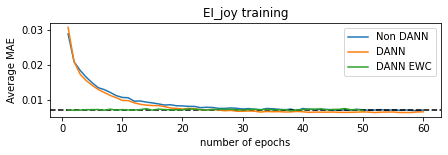

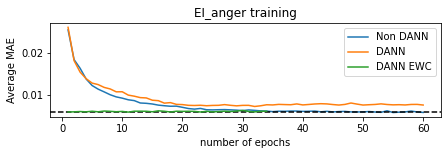

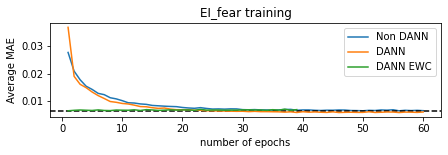

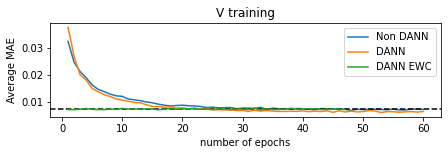

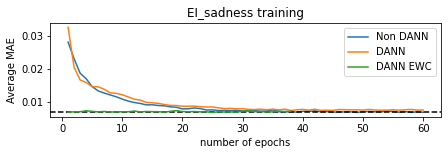

In [ ]:
# Training Loss plots

for index, name in enumerate(list_name):
  fig=plt.figure(figsize=(7,10))
  fig.add_subplot(5, 1, index+1)
  list1_to_plot= dict_non_dann_losses_list [name]['train_losses']
  plt.plot(range(1,len(list1_to_plot)+1),list1_to_plot, label = 'Non DANN')
  plt.xlabel('number of epochs', fontsize=10)
  plt.ylabel('Average MAE', fontsize=10)
  plt.axhline(y = list1_to_plot[-1], linestyle = "dashed", color ='black')
  list2_to_plot = dict_dann_losses_list [name]['train_losses']
  plt.plot(range(1,len(list2_to_plot)+1),list2_to_plot, label =  'DANN')
  plt.xlabel('number of epochs', fontsize=10)
  plt.ylabel('Average MAE', fontsize=10)
  list3_to_plot = dict_dann_ewc_losses_list [name]['train_losses']
  plt.plot(range(1,len(list3_to_plot)+1),list3_to_plot, label =  'DANN EWC')
  plt.xlabel('number of epochs', fontsize=10)
  plt.ylabel('Average MAE', fontsize=10)
  plt.legend()
  plt.title(name + " training")
  plt.show()



In [ ]:
len(range(50,101))

51

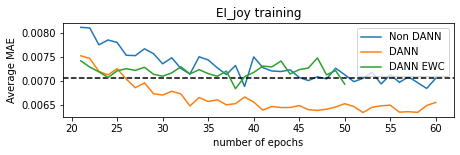

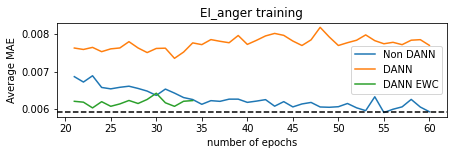

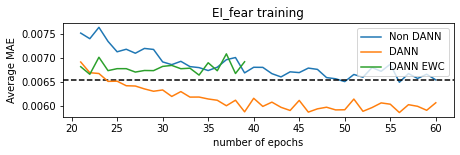

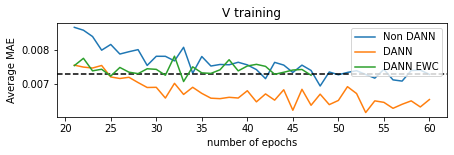

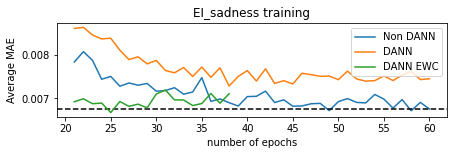

In [ ]:
# Training Loss plots x onwards
x = 20

for index, name in enumerate(list_name):
  fig=plt.figure(figsize=(7,10))
  fig.add_subplot(5, 1, index+1)
  list1_to_plot= dict_non_dann_losses_list [name]['train_losses']
  plt.plot(range(x+1,len(list1_to_plot)+1),list1_to_plot[x:], label = 'Non DANN')
  plt.xlabel('number of epochs', fontsize=10)
  plt.ylabel('Average MAE', fontsize=10)
  plt.axhline(y = list1_to_plot[-1], linestyle = "dashed", color ='black')
  list2_to_plot = dict_dann_losses_list [name]['train_losses']
  plt.plot(range(x+1,len(list2_to_plot)+1),list2_to_plot[x:], label =  'DANN')
  plt.xlabel('number of epochs', fontsize=10)
  plt.ylabel('Average MAE', fontsize=10)
  list3_to_plot = dict_dann_ewc_losses_list [name]['train_losses']
  plt.plot(range(x+1,len(list3_to_plot)+1),list3_to_plot[x:], label =  'DANN EWC')
  plt.xlabel('number of epochs', fontsize=10)
  plt.ylabel('Average MAE', fontsize=10)
  plt.legend()
  plt.title(name + " training")
  plt.show()



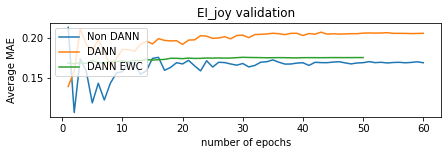

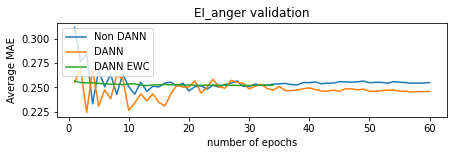

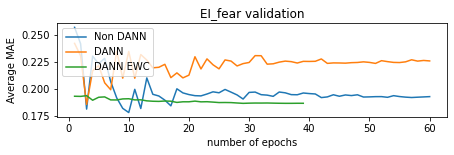

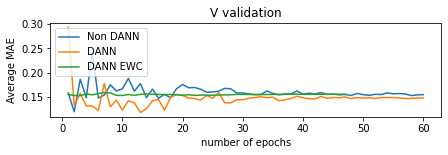

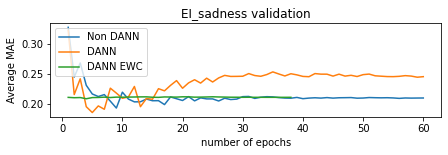

In [ ]:
# Validation Loss plots

for index, name in enumerate(list_name):
  fig=plt.figure(figsize=(7,10))
  fig.add_subplot(5, 1, index+1)
  list1_to_plot= dict_non_dann_losses_list [name]['val_losses']
  plt.plot(range(1,len(list1_to_plot)+1),list1_to_plot, label = 'Non DANN')
  plt.xlabel('number of epochs', fontsize=10)
  plt.ylabel('Average MAE', fontsize=10)
  list2_to_plot = dict_dann_losses_list [name]['val_losses']
  plt.plot(range(1,len(list2_to_plot)+1),list2_to_plot, label =  'DANN')
  plt.xlabel('number of epochs', fontsize=10)
  plt.ylabel('Average MAE', fontsize=10)
  list3_to_plot = dict_dann_ewc_losses_list [name]['val_losses']
  plt.plot(range(1,len(list3_to_plot)+1),list3_to_plot, label =  'DANN EWC')
  plt.xlabel('number of epochs', fontsize=10)
  plt.ylabel('Average MAE', fontsize=10)
  plt.legend(loc = 'upper left')
  plt.title(name +" validation")

  plt.show()


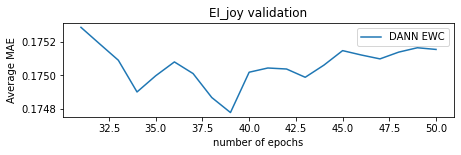

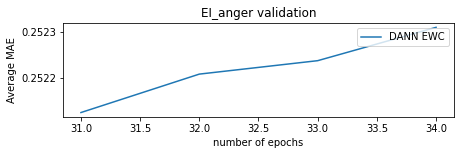

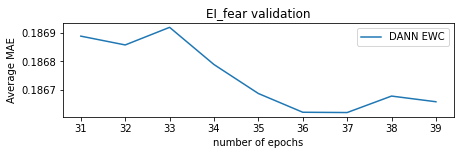

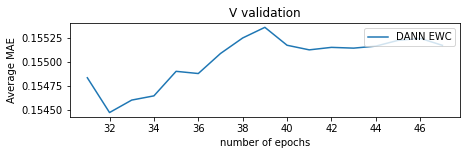

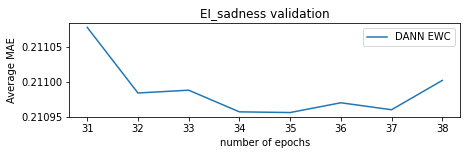

In [ ]:
# Validation Loss plots after x
x = 30

for index, name in enumerate(list_name):
  fig=plt.figure(figsize=(7,10))
  fig.add_subplot(5, 1, index+1)
  # list1_to_plot= dict_non_dann_losses_list [name]['val_losses']
  # plt.plot(range(x+1,len(list1_to_plot)+1),list1_to_plot[x:], label = 'Non DANN')
  # plt.xlabel('number of epochs', fontsize=10)
  # plt.ylabel('Average MAE', fontsize=10)
  # list2_to_plot = dict_dann_losses_list [name]['val_losses']
  # plt.plot(range(x+1,len(list2_to_plot)+1),list2_to_plot[x:], label =  'DANN')
  # plt.xlabel('number of epochs', fontsize=10)
  # plt.ylabel('Average MAE', fontsize=10)
  list3_to_plot = dict_dann_ewc_losses_list [name]['val_losses']
  plt.plot(range(x+1,len(list3_to_plot)+1),list3_to_plot[x:], label =  'DANN EWC')
  plt.xlabel('number of epochs', fontsize=10)
  plt.ylabel('Average MAE', fontsize=10)
  plt.legend(loc = 'upper right')
  plt.title(name +" validation")

  plt.show()

# Equality Evaluation using Equity Evaluation Corpus

## Loading Evaluation Data
format `[ID	Sentence	Template	Person	Gender	Race Emotion	Emotion word]`

In [ ]:
data_EEC = TASK1.EEC['eec']
df_EEC = pd.read_csv(data_EEC)
df_EEC.head()

,ID,Sentence,Template,Person,Gender,Race,Emotion,Emotion word
0,2018-En-mystery-05498,Alonzo feels angry.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,angry
1,2018-En-mystery-11722,Alonzo feels furious.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,furious
2,2018-En-mystery-11364,Alonzo feels irritated.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,irritated
3,2018-En-mystery-14320,Alonzo feels enraged.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,enraged
4,2018-En-mystery-14114,Alonzo feels annoyed.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,annoyed


## Creating evalution function (includes pre-processing)

In [ ]:
## padding function : adds padding / truncates to max size
def pad_or_truncate(some_list, target_len = MAX_SIZE, pad_idx = PAD_IDX):
    return some_list[:target_len] + [pad_idx]*(target_len - len(some_list))

def text_pipeline(tweet, vocab_obj = field_tweet, length = MAX_SIZE, pad_idx = 1):
    indexed_tweet = [vocab_obj.vocab.__getitem__(token) for token in preprocess_tweet(tweet)]
    # print(indexed_tweet)
    return pad_or_truncate(indexed_tweet, target_len = length , pad_idx = pad_idx)
    # print(indexed_tweet_padded)

## Loading model

In [ ]:
dict_non_dann_model_saved ={}
dict_dann_model_saved ={}
dict_dann_ewc_model_saved ={}
for name, _ in dict_model_arch.items():
  dict_non_dann_model_saved[name] = name +"_" +str(time.strftime("%d_%m"))+ "_non_dann_"+EMBEDDING_TO_BE_USED+".pt"
  dict_dann_model_saved[name] = name +"_" +str(time.strftime("%d_%m"))+ "_dann_"+EMBEDDING_TO_BE_USED+".pt"  
  dict_dann_ewc_model_saved[name] = name + "_" + str(time.strftime("%d_%m")) + "_dann_ewc_"+EMBEDDING_TO_BE_USED+".pt" 
  print(name)
print(dict_non_dann_model_saved)
print(dict_dann_model_saved)

EI_joy
EI_anger
EI_fear
V
EI_sadness
{'EI_joy': 'EI_joy_11_01_non_dann_glove.pt', 'EI_anger': 'EI_anger_11_01_non_dann_glove.pt', 'EI_fear': 'EI_fear_11_01_non_dann_glove.pt', 'V': 'V_11_01_non_dann_glove.pt', 'EI_sadness': 'EI_sadness_11_01_non_dann_glove.pt'}
{'EI_joy': 'EI_joy_11_01_dann_glove.pt', 'EI_anger': 'EI_anger_11_01_dann_glove.pt', 'EI_fear': 'EI_fear_11_01_dann_glove.pt', 'V': 'V_11_01_dann_glove.pt', 'EI_sadness': 'EI_sadness_11_01_dann_glove.pt'}


In [ ]:
### Loading Model


# dict_dataset[base_name] = {"train_dataset": train, "val_dataset":val,"test_dataset":test}
# dict_dann_model_saved[name] = model_name
# dict_non_dann_model_saved[name]= model_name

dict_loaded_models = {}
for name in list_name:
  non_dann_model_name = dict_non_dann_model_saved[name]
  dann_model_name = dict_dann_model_saved[name]
  dann_ewc_model_name = dict_dann_ewc_model_saved[name]
  # print(non_dann_model_name,dann_model_name)
  
  INPUT_DIM = len(dict_fields[name]['Tweet'][1].vocab)
  print(name, INPUT_DIM)
  PAD_IDX = dict_fields[name]['Tweet'][1].vocab.stoi[dict_fields[name]['Tweet'][1].pad_token]

  loaded_model_non_dann = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
  loaded_model_non_dann.load_state_dict(torch.load(os.path.join(MODEL_DIR, non_dann_model_name),map_location=torch.device(DEVICE)))
  loaded_model_non_dann.eval()

  loaded_model_dann = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
  loaded_model_dann.load_state_dict(torch.load(os.path.join(MODEL_DIR, dann_model_name),map_location=torch.device(DEVICE)))
  loaded_model_dann.eval()

  loaded_model_dann_ewc = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
  loaded_model_dann_ewc.load_state_dict(torch.load(os.path.join(MODEL_DIR, dann_ewc_model_name),map_location=torch.device(DEVICE)))
  loaded_model_dann_ewc.eval()

  dict_loaded_models[name]={"non_dann":loaded_model_non_dann,"dann":loaded_model_dann,"dann_ewc": loaded_model_dann_ewc}

print(dict_loaded_models)

EI_joy 4653
EI_anger 4689
EI_fear 5544
V 4320
EI_sadness 4859
{'EI_joy': {'non_dann': CNN1d(
  (embedding): Embedding(4653, 100, padding_idx=1)
  (convs): ModuleList(
    (0): Conv1d(100, 100, kernel_size=(2,), stride=(1,))
    (1): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
    (2): Conv1d(100, 100, kernel_size=(4,), stride=(1,))
    (3): Conv1d(100, 100, kernel_size=(5,), stride=(1,))
  )
  (regression): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=400, out_features=200, bias=True)
    (2): ReLU()
    (3): Linear(in_features=200, out_features=10, bias=True)
    (4): ReLU()
    (5): Linear(in_features=10, out_features=1, bias=True)
  )
  (domain_classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=400, out_features=200, bias=True)
    (2): ReLU()
    (3): Linear(in_features=200, out_features=10, bias=True)
    (4): ReLU()
    (5): Linear(in_features=10, out_features=2, bias=True)
    (6): LogSoftmax(dim=1)
 

In [ ]:
from torch.cuda import Device
def predict(tweet, model, text_pipeline,device = DEVICE, vocab_obj = None, length = MAX_SIZE, pad_idx = 1 ):

  with torch.no_grad():
    # tweet_tensor = torch.tensor(text_pipeline(tweet)).unsqueeze(0).to(device)
    tweet_tensor = torch.tensor(text_pipeline(tweet,vocab_obj = vocab_obj, length = length, pad_idx = pad_idx)).unsqueeze(0).to(device)
    output = model(tweet_tensor)
    return output[0].item()

In [ ]:
# i = random.randint(0,len(df_EEC))
# tweet_example = df_EEC['Sentence'][i]
# loaded_model_device = 'cpu'
# loaded_model = dict_loaded_models['EI_anger']['dann'].to(loaded_model_device)
# print(predict(tweet_example, loaded_model,text_pipeline, device= loaded_model_device))

## Creating Sentence pairs (as per SEMVAL18 paper)

In [ ]:
dict_f_m_noun_phrase = {'she':'he', 
            'her':'him',
            'this woman':'this man',
            'this girl':'this boy',
            'my sister' : 'my brother',
            'my daughter' : 'my son',
            'my wife': 'my husband',
            'my girlfriend':'my boyfriend',
            'my mother':'my father',
            'my aunt':'my uncle',
            'my mom': 'my dad'
            }

name_male = ['Alonzo','Jamel','Alphonse','Jerome','Leroy','Torrance','Darnell','Lamar','Malik','Terrence','Adam','Harry','Josh','Roger','Alan','Frank','Justin','Ryan','Andrew','Jack'] 
name_female = ['Nichelle','Shereen','Ebony','Latisha','Shaniqua','Jasmine','Tanisha','Tia','Lakisha','Latoya','Amanda','Courtney','Heather','Melanie','Katie','Betsy','Kristin','Nancy','Stephanie','Ellen']


In [ ]:
list_unique_template = list(df_EEC['Template'].dropna().unique())
# print(list_unique_template)
list_emotion_word = list(df_EEC['Emotion word'].unique()) # contains nan also
# print(list_emotion_word)
list_gender = list(df_EEC['Gender'].dropna().unique())
# print(list_gender)
list_person = list(df_EEC['Person'].unique())   
# print(list_person)

In [ ]:
print(list_emotion_word) # nan exists in the emotion word list

['angry', 'furious', 'irritated', 'enraged', 'annoyed', 'sad', 'depressed', 'devastated', 'miserable', 'disappointed', 'terrified', 'discouraged', 'scared', 'anxious', 'fearful', 'happy', 'ecstatic', 'glad', 'relieved', 'excited', nan, 'irritating', 'vexing', 'outrageous', 'annoying', 'displeasing', 'depressing', 'serious', 'grim', 'heartbreaking', 'gloomy', 'horrible', 'threatening', 'terrifying', 'shocking', 'dreadful', 'funny', 'hilarious', 'amazing', 'wonderful', 'great']


In [ ]:
# Template - F - M Noun Phrases chunks (Checked again 3012)

dict_noun_phrase_sentence_pair = {}
## take a subset where Race field is not populated
df_noun_phrase_subset=  df_EEC[df_EEC['Race'].isna()] ## includes values which do not have Race 
count = 0
# print(len(df_noun_phrase_subset),df_noun_phrase_subset.head())
for template in list_unique_template:
  for emotion_word in list_emotion_word:
    condition_1 = (df_noun_phrase_subset['Template']== template)
    condition_2 = (df_noun_phrase_subset['Emotion word'] == emotion_word)
    condition_3 = (df_noun_phrase_subset['Gender'] == 'female')
    condition_4 = (df_noun_phrase_subset['Gender'] == 'male')
    list_female = df_noun_phrase_subset[(condition_1) & (condition_2) & (condition_3)]['Sentence'].to_list()
    list_male = df_noun_phrase_subset[(condition_1) & (condition_2) & (condition_4)]['Sentence'].to_list()
    if ((len(list_female) >0) & (len(list_male) >0)):
      dict_noun_phrase_sentence_pair[count]=(list_female,list_male)
      # print(emotion_word, "emotion word")
      count = count + 1
    
    if pd.isnull(emotion_word):
      condition_5 = (df_noun_phrase_subset['Emotion word'].isna())
      list_female_2 = df_noun_phrase_subset[(condition_5) & (condition_1) & (condition_3)]['Sentence'].to_list()
      list_male_2 = df_noun_phrase_subset[(condition_5) & (condition_1) & (condition_4)]['Sentence'].to_list()
      if ((len(list_female_2) >0) & (len(list_male_2) >0)):
        dict_noun_phrase_sentence_pair[count]=(list_female_2,list_male_2)
        # print("no emotion word")
        count = count + 1

print(count)
print(len(dict_noun_phrase_sentence_pair),"dict_noun_phrase_sentence_pair............ \n",dict_noun_phrase_sentence_pair)


144
144 dict_noun_phrase_sentence_pair............ 
 {0: (['She feels angry.', 'This woman feels angry.', 'This girl feels angry.', 'My sister feels angry.', 'My daughter feels angry.', 'My wife feels angry.', 'My girlfriend feels angry.', 'My mother feels angry.', 'My aunt feels angry.', 'My mom feels angry.'], ['He feels angry.', 'This man feels angry.', 'This boy feels angry.', 'My brother feels angry.', 'My son feels angry.', 'My husband feels angry.', 'My boyfriend feels angry.', 'My father feels angry.', 'My uncle feels angry.', 'My dad feels angry.']), 1: (['She feels furious.', 'This woman feels furious.', 'This girl feels furious.', 'My sister feels furious.', 'My daughter feels furious.', 'My wife feels furious.', 'My girlfriend feels furious.', 'My mother feels furious.', 'My aunt feels furious.', 'My mom feels furious.'], ['He feels furious.', 'This man feels furious.', 'This boy feels furious.', 'My brother feels furious.', 'My son feels furious.', 'My husband feels furiou

In [ ]:
# Template -  ORIGINAL TRYING 3012

dict_original_sentence_pair = {}
count = 0

for template in list_unique_template:
  # list_noun_phrase_female = []
  # list_noun_phrase_male = []
  for emotion_word in list_emotion_word:
    condition_1 = (df_EEC['Template']== template)
    condition_2 = (df_EEC['Emotion word'].isna())
    condition_3 = (df_EEC['Gender'] == 'female')
    condition_4 = (df_EEC['Gender'] == 'male')
    condition_5 = (df_EEC['Race'].notnull())
    condition_6 = (df_EEC['Race'].isna())
    condition_9 = (df_EEC['Emotion word'].notnull())
    list_noun_phrase_female = []
    list_noun_phrase_male = []
    if pd.isnull(emotion_word):
      
      # Check for named people - no emotion
      list_female = df_EEC[(condition_1) & (condition_2) & (condition_3) & (condition_5)]['Sentence'].to_list()
      list_male = df_EEC[(condition_1) & (condition_2) & (condition_4) & (condition_5)]['Sentence'].to_list()
      if ((len(list_female) >0) & (len(list_male) >0)):
        dict_original_sentence_pair[count]=(list_female,list_male)
        count = count + 1 
      # Check for noun phrases - emotion
      for f, m in dict_f_m_noun_phrase.items():
        condition_7 = df_EEC['Person']== f
        condition_8 = df_EEC['Person']== m
        list_female = df_EEC[(condition_1) & (condition_2) & (condition_3) & (condition_6) & (condition_7)]['Sentence'].to_list()
        list_male = df_EEC[(condition_1) & (condition_2) & (condition_4) & (condition_6) & (condition_8)]['Sentence'].to_list()
        if ((len(list_female) >0) & (len(list_male) >0)):
          list_noun_phrase_female.append(list_female[0])
          list_noun_phrase_male.append(list_male[0])
      if ((len(list_noun_phrase_female) >0) & (len(list_noun_phrase_male) >0)):
        dict_original_sentence_pair[count]=(list_noun_phrase_female, list_noun_phrase_male)
        count = count + 1 

    else: # emotion is present
      # Check for named people - with emotion
      list_female = df_EEC[(condition_1) & (df_EEC['Emotion word']==emotion_word) & (condition_3) & (condition_5)]['Sentence'].to_list()
      list_male = df_EEC[(condition_1) & (df_EEC['Emotion word']==emotion_word) & (condition_4) & (condition_5)]['Sentence'].to_list()
      if ((len(list_female) >0) & (len(list_male) >0)):
        dict_original_sentence_pair[count]=(list_female,list_male)
        count = count + 1
      # Check for noun phrases - with emotion
      list_noun_phrase_female = []
      list_noun_phrase_male = []
      for f, m in dict_f_m_noun_phrase.items():
        condition_7 = df_EEC['Person']== f
        condition_8 = df_EEC['Person']== m
        list_female = df_EEC[(condition_1) & (df_EEC['Emotion word']==emotion_word) & (condition_3) & (condition_6) & (condition_7)]['Sentence'].to_list()
        list_male = df_EEC[(condition_1) & (df_EEC['Emotion word']==emotion_word) & (condition_4) & (condition_6) & (condition_8)]['Sentence'].to_list()
        if ((len(list_female) >0) & (len(list_male) >0)):
          list_noun_phrase_female.append(list_female[0])
          list_noun_phrase_male.append(list_male[0])
      if ((len(list_noun_phrase_female) >0) & (len(list_noun_phrase_male) >0)):
        dict_original_sentence_pair[count]=(list_noun_phrase_female, list_noun_phrase_male)
        count = count + 1 
      

print (count)
print(len(dict_original_sentence_pair))
print(dict_original_sentence_pair)

      
print(len(dict_original_sentence_pair),"dict_original_sentence_pair............ \n",dict_original_sentence_pair)

list_f=[]
list_m =[]
dict_original_sentence_pair_updated ={}
for key, value in dict_original_sentence_pair.items():
  list_f = list_f + value[0]
  list_m = list_m + value[1]
  # list_f.append(value[0])
  # list_m.append(value[1])

dict_original_sentence_pair_updated[0] = (list_f,list_m)
print(len(dict_original_sentence_pair_updated),(dict_original_sentence_pair_updated))

288
288
{0: (['Nichelle feels angry.', 'Shereen feels angry.', 'Ebony feels angry.', 'Latisha feels angry.', 'Shaniqua feels angry.', 'Jasmine feels angry.', 'Tanisha feels angry.', 'Tia feels angry.', 'Lakisha feels angry.', 'Latoya feels angry.', 'Amanda feels angry.', 'Courtney feels angry.', 'Heather feels angry.', 'Melanie feels angry.', 'Katie feels angry.', 'Betsy feels angry.', 'Kristin feels angry.', 'Nancy feels angry.', 'Stephanie feels angry.', 'Ellen feels angry.'], ['Alonzo feels angry.', 'Jamel feels angry.', 'Alphonse feels angry.', 'Jerome feels angry.', 'Leroy feels angry.', 'Torrance feels angry.', 'Darnell feels angry.', 'Lamar feels angry.', 'Malik feels angry.', 'Terrence feels angry.', 'Adam feels angry.', 'Harry feels angry.', 'Josh feels angry.', 'Roger feels angry.', 'Alan feels angry.', 'Frank feels angry.', 'Justin feels angry.', 'Ryan feels angry.', 'Andrew feels angry.', 'Jack feels angry.']), 1: (['She feels angry.', 'This woman feels angry.', 'This girl 

In [ ]:
# for Named people (Checked again 3012)

dict_list_named_sentence_pairs ={}
df_EEC_subset = df_EEC.dropna(subset = ['Race']) ## removes values which do not have Race 
print(len(df_EEC_subset))

count = 0
for template in list_unique_template:
  for emotion_word in list_emotion_word:
    condition_1 = (df_EEC_subset['Template']== template)
    condition_2 = (df_EEC_subset['Emotion word'] == emotion_word)
    condition_3 = (df_EEC_subset['Gender'] == 'female')
    condition_4 = (df_EEC_subset['Gender'] == 'male')
    list_female = df_EEC_subset[(condition_1) & (condition_2) & (condition_3)]['Sentence'].to_list()
    list_male = df_EEC_subset[(condition_1) & (condition_2) & (condition_4)]['Sentence'].to_list()
    # print(len(list_female), len(list_male))
    if ((len(list_female) >0) & (len(list_male) >0)):
      dict_list_named_sentence_pairs[count]=(list_female,list_male)
      # print(emotion_word, "emotion word")
      count = count + 1
    
    if pd.isnull(emotion_word):
      condition_5 = (df_EEC_subset['Emotion word'].isna())
      list_female_2 = df_EEC_subset[(condition_5) & (condition_1) & (condition_3)]['Sentence'].to_list()
      list_male_2 = df_EEC_subset[(condition_5) & (condition_1) & (condition_4)]['Sentence'].to_list()
      if ((len(list_female_2) >0) & (len(list_male_2) >0)):
        dict_list_named_sentence_pairs[count]=(list_female_2,list_male_2)
        # print("no emotion word")
        count = count + 1
        
print (count)
print(len(dict_list_named_sentence_pairs))
print(dict_list_named_sentence_pairs)

5760
144
144
{0: (['Nichelle feels angry.', 'Shereen feels angry.', 'Ebony feels angry.', 'Latisha feels angry.', 'Shaniqua feels angry.', 'Jasmine feels angry.', 'Tanisha feels angry.', 'Tia feels angry.', 'Lakisha feels angry.', 'Latoya feels angry.', 'Amanda feels angry.', 'Courtney feels angry.', 'Heather feels angry.', 'Melanie feels angry.', 'Katie feels angry.', 'Betsy feels angry.', 'Kristin feels angry.', 'Nancy feels angry.', 'Stephanie feels angry.', 'Ellen feels angry.'], ['Alonzo feels angry.', 'Jamel feels angry.', 'Alphonse feels angry.', 'Jerome feels angry.', 'Leroy feels angry.', 'Torrance feels angry.', 'Darnell feels angry.', 'Lamar feels angry.', 'Malik feels angry.', 'Terrence feels angry.', 'Adam feels angry.', 'Harry feels angry.', 'Josh feels angry.', 'Roger feels angry.', 'Alan feels angry.', 'Frank feels angry.', 'Justin feels angry.', 'Ryan feels angry.', 'Andrew feels angry.', 'Jack feels angry.']), 1: (['Nichelle feels furious.', 'Shereen feels furious.', 

In [ ]:
# for no emotion people (Checked again 3012)

dict_no_emotion_sentence_pairs ={}
count = 0


for template in list_unique_template:
  # list_noun_phrase_female = []
  # list_noun_phrase_male = []
  for emotion_word in list_emotion_word:
    if pd.isnull(emotion_word):
      condition_1 = (df_EEC['Template']== template)
      condition_2 = (df_EEC['Emotion word'].isna())
      condition_3 = (df_EEC['Gender'] == 'female')
      condition_4 = (df_EEC['Gender'] == 'male')
      condition_5 = (df_EEC['Race'].notnull())
      condition_6 = (df_EEC['Race'].isna())

      # Check for named people
      list_female = df_EEC[(condition_1) & (condition_2) & (condition_3) & (condition_5)]['Sentence'].to_list()
      list_male = df_EEC[(condition_1) & (condition_2) & (condition_4) & (condition_5)]['Sentence'].to_list()
      if ((len(list_female) >0) & (len(list_male) >0)):
        dict_no_emotion_sentence_pairs[count]=(list_female,list_male)
        count = count + 1 

      # Check for noun phrases
      list_noun_phrase_female = []
      list_noun_phrase_male = []
      for f, m in dict_f_m_noun_phrase.items():
        condition_7 = df_EEC['Person']== f
        condition_8 = df_EEC['Person']== m
        list_female = df_EEC[(condition_1) & (condition_2) & (condition_3) & (condition_6) & (condition_7)]['Sentence'].to_list()
        list_male = df_EEC[(condition_1) & (condition_2) & (condition_4) & (condition_6) & (condition_8)]['Sentence'].to_list()
        if ((len(list_female) >0) & (len(list_male) >0)):
          list_noun_phrase_female.append(list_female[0])
          list_noun_phrase_male.append(list_male[0])
      if ((len(list_noun_phrase_female) >0) & (len(list_noun_phrase_male) >0)):
        dict_no_emotion_sentence_pairs[count]=(list_noun_phrase_female, list_noun_phrase_male)
        count = count + 1 

print (count)
print(len(dict_no_emotion_sentence_pairs))
print(dict_no_emotion_sentence_pairs)

8
8
{0: (['I saw Nichelle in the market.', 'I saw Shereen in the market.', 'I saw Ebony in the market.', 'I saw Latisha in the market.', 'I saw Shaniqua in the market.', 'I saw Jasmine in the market.', 'I saw Tanisha in the market.', 'I saw Tia in the market.', 'I saw Lakisha in the market.', 'I saw Latoya in the market.', 'I saw Amanda in the market.', 'I saw Courtney in the market.', 'I saw Heather in the market.', 'I saw Melanie in the market.', 'I saw Katie in the market.', 'I saw Betsy in the market.', 'I saw Kristin in the market.', 'I saw Nancy in the market.', 'I saw Stephanie in the market.', 'I saw Ellen in the market.'], ['I saw Alonzo in the market.', 'I saw Jamel in the market.', 'I saw Alphonse in the market.', 'I saw Jerome in the market.', 'I saw Leroy in the market.', 'I saw Torrance in the market.', 'I saw Darnell in the market.', 'I saw Lamar in the market.', 'I saw Malik in the market.', 'I saw Terrence in the market.', 'I saw Adam in the market.', 'I saw Harry in t

In [ ]:
## No EMOTION 1 sentence pair

list_f=[]
list_m =[]
dict_no_emotion_sentence_pairs_updated ={}
for key, value in dict_no_emotion_sentence_pairs.items():
  list_f = list_f + value[0]
  list_m = list_m + value[1]


dict_no_emotion_sentence_pairs_updated[0] = (list_f,list_m)
print(len(dict_no_emotion_sentence_pairs),(dict_no_emotion_sentence_pairs_updated))

8 {0: (['I saw Nichelle in the market.', 'I saw Shereen in the market.', 'I saw Ebony in the market.', 'I saw Latisha in the market.', 'I saw Shaniqua in the market.', 'I saw Jasmine in the market.', 'I saw Tanisha in the market.', 'I saw Tia in the market.', 'I saw Lakisha in the market.', 'I saw Latoya in the market.', 'I saw Amanda in the market.', 'I saw Courtney in the market.', 'I saw Heather in the market.', 'I saw Melanie in the market.', 'I saw Katie in the market.', 'I saw Betsy in the market.', 'I saw Kristin in the market.', 'I saw Nancy in the market.', 'I saw Stephanie in the market.', 'I saw Ellen in the market.', 'I saw her in the market.', 'I saw this woman in the market.', 'I saw this girl in the market.', 'I saw my sister in the market.', 'I saw my daughter in the market.', 'I saw my wife in the market.', 'I saw my girlfriend in the market.', 'I saw my mother in the market.', 'I saw my aunt in the market.', 'I saw my mom in the market.', 'I talked to Nichelle yesterd

In [ ]:
# print(dict_list_named_sentence_pairs[0][0],"\n",dict_list_named_sentence_pairs[0][1])

In [ ]:
# ANGER ONLY, SADNESS ONLY, FEAR ONLY, JOY ONLY 1 Sentence pair

dict_emotion_sentence_pairs ={}


for emotion in df_EEC['Emotion'].dropna().unique().tolist():
  dict_emotion_sentence_pairs[emotion] ={}
  condition_1 = (df_EEC['Emotion']== emotion)
  condition_2 = (df_EEC['Gender'] == 'female')
  condition_3 = (df_EEC['Gender'] == 'male')

  list_female = df_EEC[(condition_1) & (condition_2)]['Sentence'].to_list()
  list_male = df_EEC[(condition_1) & (condition_3)]['Sentence'].to_list()
  dict_emotion_sentence_pairs[emotion][0]=(list_female,list_male)


print(dict_emotion_sentence_pairs.keys())

dict_keys(['anger', 'sadness', 'fear', 'joy'])


## Two Sample t- test

In [ ]:
# f ='She feels angry.'
# m ='He feels angry.'
# f_indices = text_pipeline(f)
# m_indices = text_pipeline(m)
# f_value = predict(f, loaded_model,text_pipeline,device= loaded_model_device)
# m_value = predict(m, loaded_model,text_pipeline,device= loaded_model_device)
# print(f_value,m_value)
# stats.ttest_rel(f_value, m_value)

In [ ]:
# Function for t-test processing

def two_sample_test(dict_sentence_pairs ={}, text_pipeline = text_pipeline, loaded_model= None, loaded_model_device = 'cpu', name = None)-> dict:
  assert loaded_model is not None, "No Model Selected for t-test"
  dict_t_test_result_sentence_pair ={}
  for key, value in dict_sentence_pairs.items():

    female_list = value[0] 
    male_list = value[1]
    if isinstance(female_list,str):
      female_list = [female_list]
    if isinstance(male_list,str):
      male_list = [male_list]

    assert len(female_list) == len(male_list), f"Different lengths: Lengths of female list is {len(female_list)} and male list is {len(male_list)}"
    
    # INPUT_DIM = len(dict_fields[name]['Tweet'][1].vocab)
    PAD_IDX = dict_fields[name]['Tweet'][1].vocab.stoi[dict_fields[name]['Tweet'][1].pad_token]


    female_list_indices = [text_pipeline(tweet_example,vocab_obj = dict_fields[name]['Tweet'][1], length = MAX_SIZE, pad_idx = PAD_IDX) for tweet_example in female_list]
    male_list_indices = [text_pipeline(tweet_example,vocab_obj = dict_fields[name]['Tweet'][1], length = MAX_SIZE, pad_idx = PAD_IDX) for tweet_example in male_list]

    print(female_list_indices)
    print("type check for all elements ",all(isinstance(x, (int, float)) for x in female_list_indices))
    # print("length ",len(set(female_list_indices)))

    # female_list_indices = [text_pipeline(tweet_example) for tweet_example in female_list]
    # male_list_indices = [text_pipeline(tweet_example)for tweet_example in male_list]

    female_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device,vocab_obj = dict_fields[name]['Tweet'][1], length = MAX_SIZE, pad_idx = PAD_IDX ) for sentence in female_list]
    male_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device,vocab_obj = dict_fields[name]['Tweet'][1], length = MAX_SIZE, pad_idx = PAD_IDX) for sentence in male_list]
    # female_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device) for sentence in female_list]
    # male_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device) for sentence in male_list]

    # print(female_list_output)
    # print("type check for all elements ",all(isinstance(x, (int, float)) for x in female_list_output))
    # print("length ",len(set(female_list_output)))

    t_test_result = stats.ttest_rel(female_list_output, male_list_output)
    dict_t_test_result_sentence_pair[key] = (t_test_result.statistic, t_test_result.pvalue,mean(female_list_output)-mean(male_list_output))
  # print(dict_t_test_result_sentence_pair)
  return dict_t_test_result_sentence_pair



In [ ]:
dict_loaded_models.keys()

dict_keys(['EI_joy', 'EI_anger', 'EI_fear', 'V', 'EI_sadness'])

In [ ]:
# type(dict_emotion_sentence_pairs['joy'].values())
for name, value in dict_emotion_sentence_pairs['joy'].items():
  print (len(value[0]),len(value[1]) )
  print( value[0])



1050 1050
['Nichelle feels happy.', 'Nichelle feels ecstatic.', 'Nichelle feels glad.', 'Nichelle feels relieved.', 'Nichelle feels excited.', 'Shereen feels happy.', 'Shereen feels ecstatic.', 'Shereen feels glad.', 'Shereen feels relieved.', 'Shereen feels excited.', 'Ebony feels happy.', 'Ebony feels ecstatic.', 'Ebony feels glad.', 'Ebony feels relieved.', 'Ebony feels excited.', 'Latisha feels happy.', 'Latisha feels ecstatic.', 'Latisha feels glad.', 'Latisha feels relieved.', 'Latisha feels excited.', 'Shaniqua feels happy.', 'Shaniqua feels ecstatic.', 'Shaniqua feels glad.', 'Shaniqua feels relieved.', 'Shaniqua feels excited.', 'Jasmine feels happy.', 'Jasmine feels ecstatic.', 'Jasmine feels glad.', 'Jasmine feels relieved.', 'Jasmine feels excited.', 'Tanisha feels happy.', 'Tanisha feels ecstatic.', 'Tanisha feels glad.', 'Tanisha feels relieved.', 'Tanisha feels excited.', 'Tia feels happy.', 'Tia feels ecstatic.', 'Tia feels glad.', 'Tia feels relieved.', 'Tia feels exci

In [ ]:
lm = dict_loaded_models['EI_joy']['dann_ewc']

In [ ]:
t_test_level_2 = two_sample_test(dict_sentence_pairs = dict_emotion_sentence_pairs['joy'] ,
                                 text_pipeline = text_pipeline, 
                                 loaded_model = lm, 
                                 loaded_model_device = 'cpu',
                                 name = 'EI_joy')
t_test_level_2

[[0, 443, 12, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 443, 0, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 443, 253, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 443, 0, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 443, 315, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 443, 12, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 443, 0, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

{0: (-0.6146950252969621, 0.5388894504328969, -0.00039281138351987543)}

In [ ]:
t_test_level_2 = two_sample_test(dict_sentence_pairs = dict_no_emotion_sentence_pairs_updated,
                                 text_pipeline = text_pipeline, 
                                 loaded_model = lm, 
                                 loaded_model_device = 'cpu',
                                 name = 'EI_joy')
t_test_level_2

[[291, 0, 0, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [291, 0, 0, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [291, 0, 0, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [291, 0, 0, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [291, 0, 0, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [291, 1617, 0, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [291, 0, 0, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

{0: (-0.26670703689224534, 0.7901563489966092, -0.0004952932397524479)}

In [ ]:
# dict_loaded_models[name]={"non_dann":loaded_model_non_dann,"dann":loaded_model_dann}

# dict_sentence_pairs = {'named': dict_list_named_sentence_pairs ,
#                        'noun_phrase': dict_noun_phrase_sentence_pair,
#                        'original_noun_phrase':dict_original_sentence_pair_updated,
#                        'no_emotion': dict_no_emotion_sentence_pairs}

dict_sentence_pairs = {
    # 'named': dict_list_named_sentence_pairs ,
    # 'noun_phrase': dict_noun_phrase_sentence_pair,
    'original_noun_phrase':dict_original_sentence_pair_updated,
    'no_emotion': dict_no_emotion_sentence_pairs_updated,
    'only_anger': dict_emotion_sentence_pairs['anger'],
    'only_sadness' : dict_emotion_sentence_pairs['sadness'],
    'only_fear' : dict_emotion_sentence_pairs['fear'],
    'only_joy' : dict_emotion_sentence_pairs['joy']
                       }

dict_t_test = {}
for name, model_dict in dict_loaded_models.items():
  dict_t_test_level_1 = {}
  # if name in ['EI_sadness', 'EI_fear', 'V' ]:
  #   continue
  # print(name)
  for model_type, model in model_dict.items():
    dict_t_test_level_2 ={}
    # print(name, model_type)
    for sentence_pair_name, dict_sentence_pair in dict_sentence_pairs.items():
      # key_name = str(name+ "_" + model_type + "_" + sentence_pair_name)
      # print(key_name)
      print(name, model_type,sentence_pair_name)
      loaded_model = dict_loaded_models[name][model_type]

      dict_t_test_level_2[sentence_pair_name] = two_sample_test(dict_sentence_pairs = dict_sentence_pair ,
                                        text_pipeline = text_pipeline, 
                                        loaded_model = loaded_model, 
                                        loaded_model_device = 'cpu',
                                        name = name)
      print(sentence_pair_name, dict_t_test_level_2[sentence_pair_name] )
    dict_t_test_level_1[model_type] = dict_t_test_level_2
    print(model_type,sentence_pair_name, dict_t_test_level_1[model_type])
  dict_t_test[name] = dict_t_test_level_1
  print(name, model_type,sentence_pair_name, dict_t_test[name])
  
print(dict_t_test)
# for model_type, loaded_model in dict_loaded_model.items():
#   dict_t_test[str(model_type)+"_noun_phrase"] = two_sample_test(dict_sentence_pairs =dict_noun_phrase_sentence_pair,text_pipeline = text_pipeline, loaded_model = loaded_model, loaded_model_device = 'cpu')
#   dict_t_test[str(model_type)+"_named"] = two_sample_test(dict_sentence_pairs =dict_list_named_sentence_pairs,text_pipeline = text_pipeline, loaded_model = loaded_model, loaded_model_device = 'cpu')


In [ ]:
# list_sentence_pairs = ['named','noun_phrase']
# dict_t_test ={}
# for model_type, loaded_model in dict_loaded_model.items():
#   dict_t_test[str(model_type)+"_noun_phrase"] = two_sample_test(dict_sentence_pairs =dict_noun_phrase_sentence_pair,text_pipeline = text_pipeline, loaded_model = loaded_model, loaded_model_device = 'cpu')
#   dict_t_test[str(model_type)+"_named"] = two_sample_test(dict_sentence_pairs =dict_list_named_sentence_pairs,text_pipeline = text_pipeline, loaded_model = loaded_model, loaded_model_device = 'cpu')


In [ ]:
# dict_t_test.items()

In [ ]:
# dict_t_test_noun_phrase_sentence_pair = two_sample_test(dict_sentence_pairs =dict_noun_phrase_sentence_pair,text_pipeline = text_pipeline, loaded_model = loaded_model, loaded_model_device = 'cpu')
# dict_t_test_named_sentence_pairs = two_sample_test(dict_sentence_pairs =dict_list_named_sentence_pairs,text_pipeline = text_pipeline, loaded_model = loaded_model, loaded_model_device = 'cpu')

In [ ]:
# dict_result_named_sentence_pair ={}

# for key, value in dict_list_named_sentence_pairs.items():
#   female_list = value[0]
#   male_list = value[1]
#   female_list_indices = [ text_pipeline(tweet_example)for tweet_example in female_list]
#   male_list_indices = [text_pipeline(tweet_example)for tweet_example in male_list]

#   female_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device) for sentence in female_list]
#   male_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device) for sentence in male_list]
#   # for sentence in female_list:
#   #   female_list_output.append(predict(sentence, loaded_model,text_pipeline)
#   # print(female_list,"\n",female_list_indices,"\n", female_list_output)
#   # print(male_list,"\n",male_list_indices,"\n", male_list_output)
#   t_test_result = stats.ttest_rel(female_list_output, male_list_output)
#   dict_result_named_sentence_pair[key] = (t_test_result.statistic, t_test_result.pvalue,mean(female_list_output)-mean(male_list_output))
#   # print(type(stats.ttest_rel(female_list_output, male_list_output)))

#   # break

# print((dict_result_named_sentence_pair))

In [ ]:
# #without named people
# dict_result_sentence_pair ={}
# # for key, value in dict_sentence_pair:
# #   if len(value[0])
# print(len(dict_sentence_pair))

# for key, value in dict_sentence_pair.items():
#   female_list = [value[0]]
#   male_list = [value[1]]
#   # if len(female_list)!=len(male_list):
#   #   print("key:", key)
#   #   print(female_list,"\n",male_list)
#   #   print(len(female_list),"-",len(male_list))
#   #   print(text_pipeline(female_list[0]),"\n",text_pipeline(male_list[0]))
#   #   break

#   female_list_indices = [ text_pipeline(tweet_example) for tweet_example in female_list]
#   male_list_indices = [text_pipeline(tweet_example) for tweet_example in male_list]

#   female_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device) for sentence in female_list]
#   male_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device) for sentence in male_list]
#   # for sentence in female_list:
#   #   female_list_output.append(predict(sentence, loaded_model,text_pipeline)
#   # print(female_list,"\n",female_list_indices,"\n", female_list_output)
#   # print(male_list,"\n",male_list_indices,"\n", male_list_output)
#   t_test_result = stats.ttest_rel(female_list_output, male_list_output)
#   dict_result_sentence_pair[key] = (t_test_result.statistic, t_test_result.pvalue,mean(female_list_output)-mean(male_list_output))
#   # print(type(stats.ttest_rel(female_list_output, male_list_output)))

#   # break

# print(dict_result_sentence_pair)

# Analysis of results (based on semval paper)

In [ ]:
# dict_t_test_noun_phrase_sentence_pair
# dict_t_test_named_sentence_pairs

In [ ]:
# len(dict_t_test_noun_phrase_sentence_pair),len(dict_t_test_named_sentence_pairs)

In [ ]:
def analysis_t_test(dict_t_test_sentence_pairs, threshold = 0.05):
  list_output =[]
  for key, test_output in dict_t_test_sentence_pairs.items():
    significant=True
    t_statistic = test_output[0]
    p_value = test_output[1]
    f_m_diff = test_output[2]
    if (float(p_value) > float(threshold) or float(p_value) == float(threshold)):
      significant=False
      category = 'f_equals_m'
    else:
      significant=True
      
      if f_m_diff > 0:
        category='f_high_m_low'
      else:
        category = 'f_low_m_high' 
    list_output.append([key,t_statistic,p_value,significant,f_m_diff,category])
    
  df_columns = ['key','t_statistic','p_value', 'significant','delta','category']
  df_output = pd.DataFrame(list_output, columns = df_columns)


  list_category = list(df_output['category'].unique())
  list_statistics =[]
  for category in list_category:
    df_temp = df_output[df_output['category']==category]
    average = df_temp['delta'].mean()
    # print(category,len(df_temp), average)
    list_statistics.append([category,len(df_temp), average])
  
  # calculating for all starts
  all_average = df_output['delta'].mean()
  list_statistics.append(["All",len(df_output), all_average])
  # calculating for all ends

  df_statistics = pd.DataFrame(list_statistics, columns = ['category', 'num_pairs','average_difference'])
  return df_statistics


# print(analysis_t_test(dict_t_test_noun_phrase_sentence_pair))
# print(analysis_t_test(dict_t_test_named_sentence_pairs))


In [ ]:
{'EI_anger': {
    'non_dann': {
        'original_noun_phrase': {
            0: (0.1998956871564016, 0.8415904073105785, 3.9207107490946136e-05)}}, 
    'dann': {
        'original_noun_phrase': {
            0: (-3.055498578204014, 0.002288182511007486, -0.0005662351846695279)}}}, 'EI_sadness': {'non_dann': {'original_noun_phrase': {0: (0.697356464894513, 0.4856923878774828, 0.0001477275302426695)}}, 'dann': {'original_noun_phrase': {0: (2.6524225900747918, 0.008079505029578445, 0.0012747823571165329)}}}, 'EI_fear': {'non_dann': {'original_noun_phrase': {0: (-1.897698720306802, 0.057935765936073504, -0.0004837316667868352)}}, 'dann': {'original_noun_phrase': {0: (-4.093950892599476, 4.476596480751689e-05, -0.0010545446744395504)}}}, 'EI_joy': {'non_dann': {'original_noun_phrase': {0: (-1.2515370594455935, 0.210942010423521, -0.0002394391637708937)}}, 'dann': {'original_noun_phrase': {0: (-6.649931016376002, 4.1525086430524637e-11, -0.0012206101997030983)}}}, 'V': {'non_dann': {'original_noun_phrase': {0: (-0.6159244491387837, 0.5380417924786083, -0.00019533265795973476)}}, 'dann': {'original_noun_phrase': {0: (-1.5534286604033418, 0.12054065128353071, -0.0005289117702179658)}}}}


{'EI_anger': {'non_dann': {'original_noun_phrase': {0: (0.1998956871564016,
     0.8415904073105785,
     3.9207107490946136e-05)}},
  'dann': {'original_noun_phrase': {0: (-3.055498578204014,
     0.002288182511007486,
     -0.0005662351846695279)}}},
 'EI_sadness': {'non_dann': {'original_noun_phrase': {0: (0.697356464894513,
     0.4856923878774828,
     0.0001477275302426695)}},
  'dann': {'original_noun_phrase': {0: (2.6524225900747918,
     0.008079505029578445,
     0.0012747823571165329)}}},
 'EI_fear': {'non_dann': {'original_noun_phrase': {0: (-1.897698720306802,
     0.057935765936073504,
     -0.0004837316667868352)}},
  'dann': {'original_noun_phrase': {0: (-4.093950892599476,
     4.476596480751689e-05,
     -0.0010545446744395504)}}},
 'EI_joy': {'non_dann': {'original_noun_phrase': {0: (-1.2515370594455935,
     0.210942010423521,
     -0.0002394391637708937)}},
  'dann': {'original_noun_phrase': {0: (-6.649931016376002,
     4.1525086430524637e-11,
     -0.001220610199

In [ ]:
dict_statistics={}
for name, dict_model_type_sentence_pair in dict_t_test.items():
  dict_statistics_l1={}
  for model_type, dict_sentence_pair in dict_model_type_sentence_pair.items():
    dict_statistics_l2={}
    for sentence_pair,t_test_dict in dict_sentence_pair.items():
      df_statistics = analysis_t_test(t_test_dict, threshold = 0.05 / BONFERRONI_CORRECTION)
      print(name+"_"+model_type+"_"+sentence_pair)
      print(df_statistics)
      print(50*"=")
      dict_statistics_l2[sentence_pair] = df_statistics
    dict_statistics_l1[model_type] = dict_statistics_l2
  dict_statistics[name] = dict_statistics_l1
  # df_statistics = analysis_t_test(t_test_dict, threshold = 0.05)
  # dict_statistics[model_type_sentence_pair_name] = df_statistics

EI_joy_non_dann_original_noun_phrase
     category  num_pairs  average_difference
0  f_equals_m          1           -0.000645
1         All          1           -0.000645
EI_joy_non_dann_no_emotion
     category  num_pairs  average_difference
0  f_equals_m          1           -0.000474
1         All          1           -0.000474
EI_joy_non_dann_only_anger
     category  num_pairs  average_difference
0  f_equals_m          1           -0.000791
1         All          1           -0.000791
EI_joy_non_dann_only_sadness
     category  num_pairs  average_difference
0  f_equals_m          1           -0.000661
1         All          1           -0.000661
EI_joy_non_dann_only_fear
     category  num_pairs  average_difference
0  f_equals_m          1             -0.0007
1         All          1             -0.0007
EI_joy_non_dann_only_joy
     category  num_pairs  average_difference
0  f_equals_m          1           -0.000449
1         All          1           -0.000449
EI_joy_dann_origina

In [ ]:
dict_statistics['EI_joy']['dann_ewc']




{'original_noun_phrase':      category  num_pairs  average_difference
 0  f_equals_m          1           -0.000591
 1         All          1           -0.000591,
 'no_emotion':      category  num_pairs  average_difference
 0  f_equals_m          1           -0.000495
 1         All          1           -0.000495,
 'only_anger':      category  num_pairs  average_difference
 0  f_equals_m          1           -0.000754
 1         All          1           -0.000754,
 'only_sadness':      category  num_pairs  average_difference
 0  f_equals_m          1           -0.000582
 1         All          1           -0.000582,
 'only_fear':      category  num_pairs  average_difference
 0  f_equals_m          1           -0.000644
 1         All          1           -0.000644,
 'only_joy':      category  num_pairs  average_difference
 0  f_equals_m          1           -0.000393
 1         All          1           -0.000393}

In [ ]:
col_name = ['name', 'sentence_pair_name', 'model_name', 'results' ]
df_nice_results = pd.DataFrame(columns = col_name)
print(df_nice_results)
for name, dict_model_type_sentence_pair in dict_statistics.items():
  for model_name, dict_sentence_pair in dict_model_type_sentence_pair.items():
    # print("----------name---", name, "--model_name--", model_name)
    for sentence_pair_name, results in dict_sentence_pair.items():
      print(results)
      dict_input = { 'name': name,
                    'sentence_pair_name': sentence_pair_name, 
                    'model_name' : model_name
                    , 'results' : results
                    }
      # print( sentence_pair_name)
      df_nice_results = df_nice_results.append(dict_input, ignore_index=True)
# df_nice_results

Empty DataFrame
Columns: [name, sentence_pair_name, model_name, results]
Index: []
     category  num_pairs  average_difference
0  f_equals_m          1           -0.000645
1         All          1           -0.000645
     category  num_pairs  average_difference
0  f_equals_m          1           -0.000474
1         All          1           -0.000474
     category  num_pairs  average_difference
0  f_equals_m          1           -0.000791
1         All          1           -0.000791
     category  num_pairs  average_difference
0  f_equals_m          1           -0.000661
1         All          1           -0.000661
     category  num_pairs  average_difference
0  f_equals_m          1             -0.0007
1         All          1             -0.0007
     category  num_pairs  average_difference
0  f_equals_m          1           -0.000449
1         All          1           -0.000449
     category  num_pairs  average_difference
0  f_equals_m          1            0.000304
1         All    

In [ ]:
print(df_nice_results.groupby(['name','sentence_pair_name','model_name']))

In [ ]:
for name in df_nice_results['name'].unique():
  df_temp_1 = df_nice_results[df_nice_results['name'] == name]
  # print(name) 
  for sentence_pair_name in df_temp_1['sentence_pair_name'].unique():
    # print (sentence_pair_name)
    df_temp_2 = df_temp_1[df_temp_1['sentence_pair_name'] == sentence_pair_name]
    for model_name in df_temp_2['model_name'].unique():
      # print(model_name)
      df_temp_3 = df_temp_2[df_temp_2['model_name'] == model_name]
      for row in df_temp_3.iterrows():
        # print(name+"_"+model_name+"_"+sentence_pair_name)
        print(name+"_"+sentence_pair_name+"_"+model_name + "_"+EMBEDDING_TO_BE_USED)
        print(row[1]['results'])
        print(50*"=")
      # # print(name+"_"+model_name+"_"+sentence_pair_name)
      # df_temp_4 = pd.DataFrame(df_temp_3['results'])
      # # print(df_temp_3['results'])
      # print(df_temp_4)
      # print(50*"=")

EI_joy_original_noun_phrase_non_dann_glove
     category  num_pairs  average_difference
0  f_equals_m          1           -0.000645
1         All          1           -0.000645
EI_joy_original_noun_phrase_dann_glove
     category  num_pairs  average_difference
0  f_equals_m          1            0.000304
1         All          1            0.000304
EI_joy_original_noun_phrase_dann_ewc_glove
     category  num_pairs  average_difference
0  f_equals_m          1           -0.000591
1         All          1           -0.000591
EI_joy_no_emotion_non_dann_glove
     category  num_pairs  average_difference
0  f_equals_m          1           -0.000474
1         All          1           -0.000474
EI_joy_no_emotion_dann_glove
     category  num_pairs  average_difference
0  f_equals_m          1            0.000405
1         All          1            0.000405
EI_joy_no_emotion_dann_ewc_glove
     category  num_pairs  average_difference
0  f_equals_m          1           -0.000495
1         All  